#  Next Product to Buy Models

This analysis aims to support a sports retailer firm in identifying which customers to target fot each of its product lines through email marketing campaigns


![](images/github-group-workflow.png)

In [54]:
import pandas as pd
import pyrsm as rsm
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
import numpy as np

In [55]:
# setup pyrsm for autoreload
%reload_ext autoreload
%autoreload 2
%aimport pyrsm

In [56]:
## loading the data - this dataset must NOT be changed
pentathlon_nptb = pd.read_parquet("data/pentathlon_nptb.parquet")
pentathlon_nptb.head()

custid buyer  total_os      message       age female  income  education  \
0     U1    no         0         team  30 to 44     no   55000         19   
1     U3    no         0  backcountry  45 to 59     no   35000         22   
2    U13    no         0    endurance  45 to 59    yes   45000         33   
3    U20    no         0        water  45 to 59    yes   25000         24   
4    U25    no         0      racquet     >= 60    yes   65000         32   

   children  freq_endurance  freq_strength  freq_water  freq_team  \
0       0.8               0              4           0          4   
1       1.0               0              0           0          1   
2       0.7               0              0           0          0   
3       0.2               0              0           0          0   
4       1.1               1              2           0          0   

   freq_backcountry  freq_racquet  training  
0                 0             1       1.0  
1                 0             0       0.0  
2                 2             2       1.0  
3                 0             0       1.0  
4                 2             2       0.0

## Base logistic regression model

Possible motivation for the model below:
- The evars message type and age were likely used as references because Primary Business Question the core problem is determining which department's promotional email is most effective for each customer and the message type could affect customer behavior based on preferences. Age is likely used as a reference because it could be a proxy for customer preferences and behavior.
- It helps establish a baseline understanding before testing more complex models. 
- A Logistic regression is used as it provides clear, interpretable coefficients, making it easy to understand the effect of different messages and age groups on purchase probability. 
- Comparing a logistic regression model with a more complex model like a neural network model can help us understand issues like missing interactions, non-linear relationships, and insufficient features, by looking at permutation importance plot comparisons and partial dependence plots.



In [61]:
lrc = rsm.logistic(
    data={"pentathlon_nptb": pentathlon_nptb},
    rvar="buyer",
    lev="yes",
    evar=["message", "age"]
)
lrc.summary()


Logistic regression (GLM)
Data                 : pentathlon_nptb
Response variable    : buyer
Level                : yes
Explanatory variables: message, age
Null hyp.: There is no effect of x on buyer
Alt. hyp.: There is an effect of x on buyer

                       OR     OR%  coefficient  std.error  z.value p.value     
Intercept           0.013  -98.7%       -4.337      0.034 -126.939  < .001  ***
message[control]    0.946   -5.4%       -0.055      0.032   -1.718   0.086    .
message[endurance]  1.109   10.9%        0.103      0.031    3.307  < .001  ***
message[racquet]    0.965   -3.5%       -0.036      0.032   -1.121   0.262     
message[strength]   1.063    6.3%        0.061      0.032    1.945   0.052    .
message[team]       1.024    2.4%        0.024      0.032    0.755    0.45     
message[water]      1.037    3.7%        0.036      0.032    1.146   0.252     
age[30 to 44]       2.421  142.1%        0.884      0.030   29.315  < .001  ***
age[45 to 59]       2.159  115.9% 

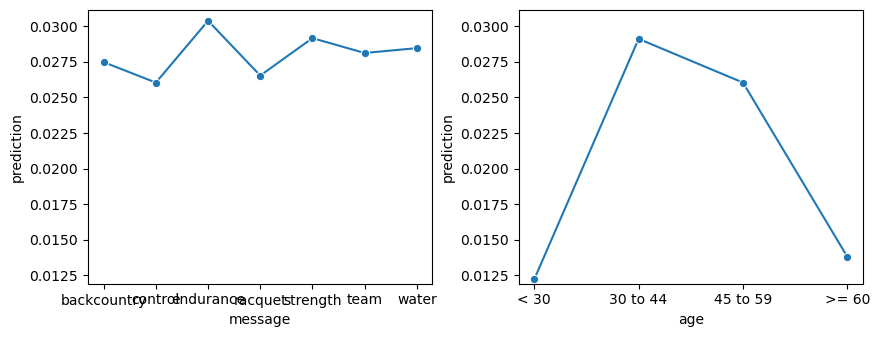

In [62]:
lrc = rsm.logistic(
    data={"pentathlon_nptb": pentathlon_nptb},
    rvar="buyer",
    lev="yes",
    evar=["message", "age"]
)
lrc.plot("pred")

Summary of observed results for lrc model:

- The model has an AUC of 0.589, which is very slightly better if not similar to random guessing. This suggests that the model is not able to predict the target variable better than random guessing.
- The model has a chi square of 1637.256, which is relatively high, and a p-value of <0.001, which suggests that the model is statistically significant and at least one of the variables have a significant effect on the response variable.
- The pseudo R² (McFadden) is very low (0.012), meaning the model still explains only a small portion of the variation in buying behavior.
- This indicates that while the variables contribute statistically, the model still lacks strong predictive power, likely needing more features or interaction terms.
- Coefficients and odds ratio describing trends of each message category and age group (keeing all else constant):
1. Message Type:
-- "Endurance" has the highest positive effect on purchase likelihood (OR = 1.109, meaning a 10.9% increase).
-- "Control" (no message) has an OR < 1, suggesting a slightly negative effect on purchases compared to other messages.
-- Messages from "racquet," "team," and "water" dept are not significantly different from the control group.
2. Age Groups:
-- The 30-44 group is the most likely to purchase (OR = 2.421, 142% more likely than the baseline <30).
-- 45-59 is still high but slightly lower than 30-44 (OR = 2.159).
-- ≥60 has the lowest likelihood of purchase (OR = 1.131, only a 13.1% increase vs. the reference group).
- Prediction Plots (Shown in the Image)
-- Endurance has the highest predicted probability of purchase (~3.0%), keeping all else constant.
-- "Strength" and "Water" also have slightly higher probabilities of purchase, keeping all else constant.
-- The control group is lower, confirming that some messages are more effective, keeping all else constant.
-- <30 has the lowest probability (~1.2%), meaning younger customers are the least likely to buy, keeping all else constant.
-- 30-44 has the highest probability (~2.9%), keeping all else constant, aligning with the high OR in logistic regression.
-- 45-59 is slightly lower but still strong (~2.7%), keeping all else constant.
-- ≥60 drops significantly (~1.3%), reinforcing the finding that older customers purchase less, keeping all else constant.

Overall, The model suggests targeting endurance messaging toward the 30-44 and 45-59 groups for maximum conversion, keeping all else constant. The overall predicted probabilities are low (~1.2% to 3.0%), indicating that purchase likelihood is small across the board, and additional features may be needed to improve targeting.





### Exploratory Data Analysis

In [65]:
# Confirm the percentage of training and test data
training_percentage = pentathlon_nptb['training'].mean() * 100
test_percentage = 100 - training_percentage

print(f"Training data: {training_percentage:.2f}%")
print(f"Test data: {test_percentage:.2f}%")

Training data: 70.00%
Test data: 30.00%


In [66]:
print(pentathlon_nptb.dtypes)

custid                object
buyer               category
total_os               int32
message             category
age                 category
female              category
income                 int32
education              int32
children             float64
freq_endurance         int32
freq_strength          int32
freq_water             int32
freq_team              int32
freq_backcountry       int32
freq_racquet           int32
training             float64
dtype: object


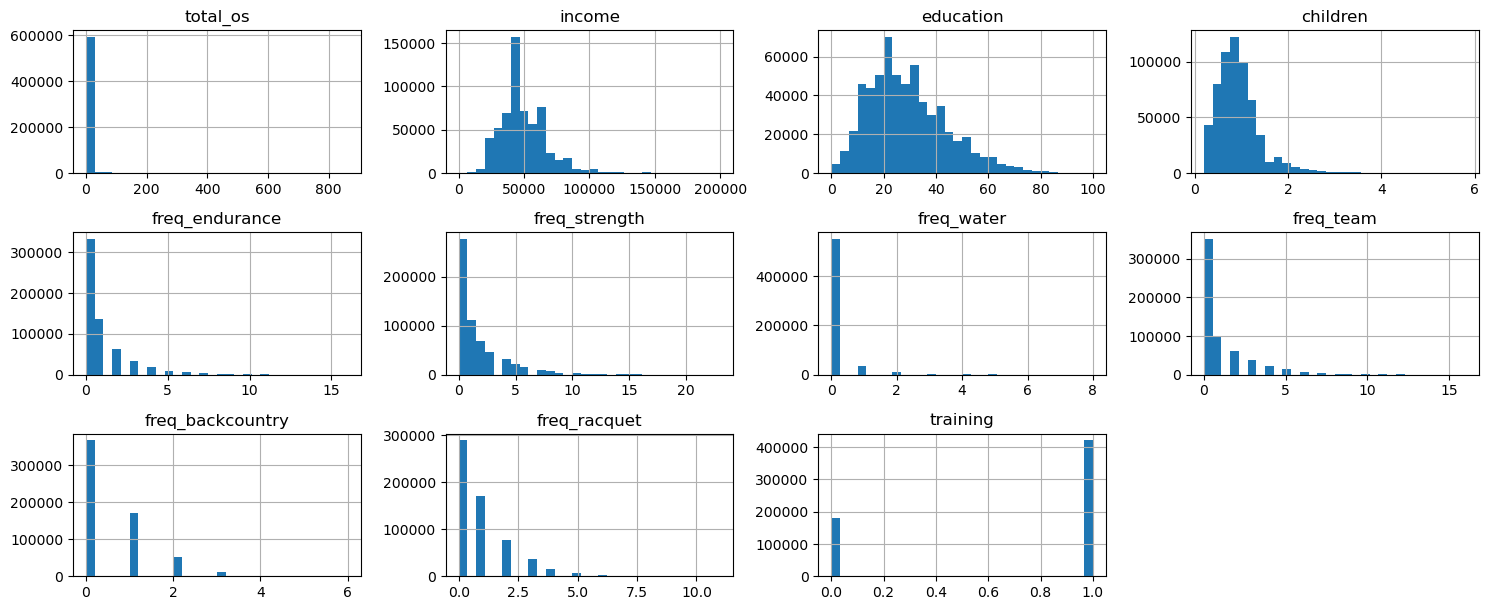

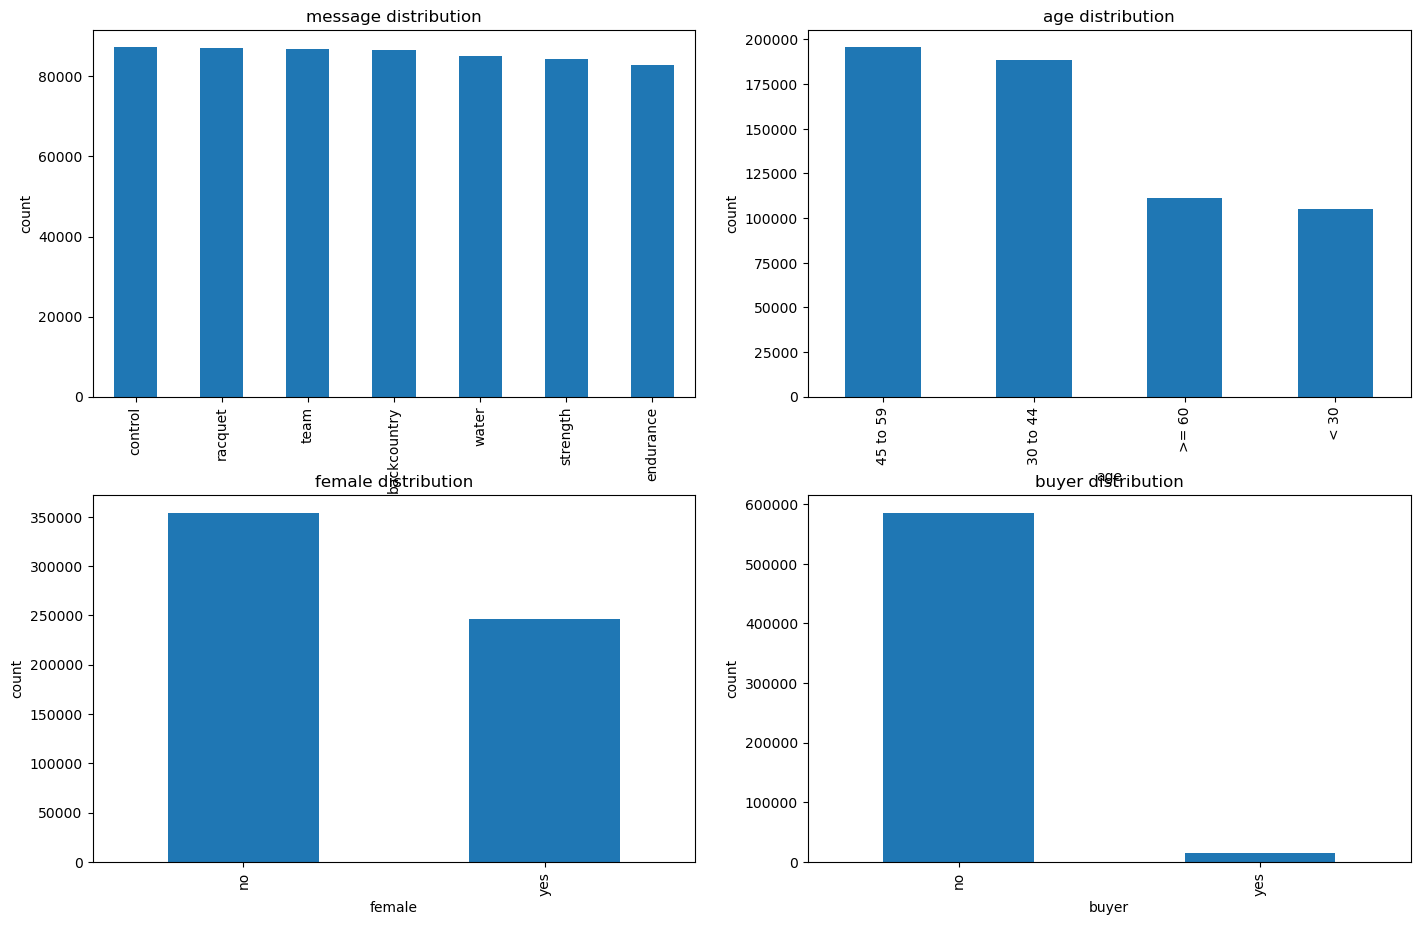

In [67]:
import matplotlib.pyplot as plt

# Plot histograms for each variable
pentathlon_nptb.hist(bins=30, figsize=(15, 10), layout=(5, 4))
plt.tight_layout()
plt.show()

# Plot histograms for 'message', 'age', 'female', and 'buyer' as well
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.tight_layout(pad=5.0)

# List of columns to plot
categorical_columns = ['message', 'age', 'female', 'buyer']

# Plot each categorical variable
for ax, column in zip(axes.flatten(), categorical_columns):
    pentathlon_nptb[column].value_counts().plot(kind='bar', ax=ax)
    ax.set_title(f'{column} distribution')
    ax.set_xlabel(column)
    ax.set_ylabel('count')

plt.show()

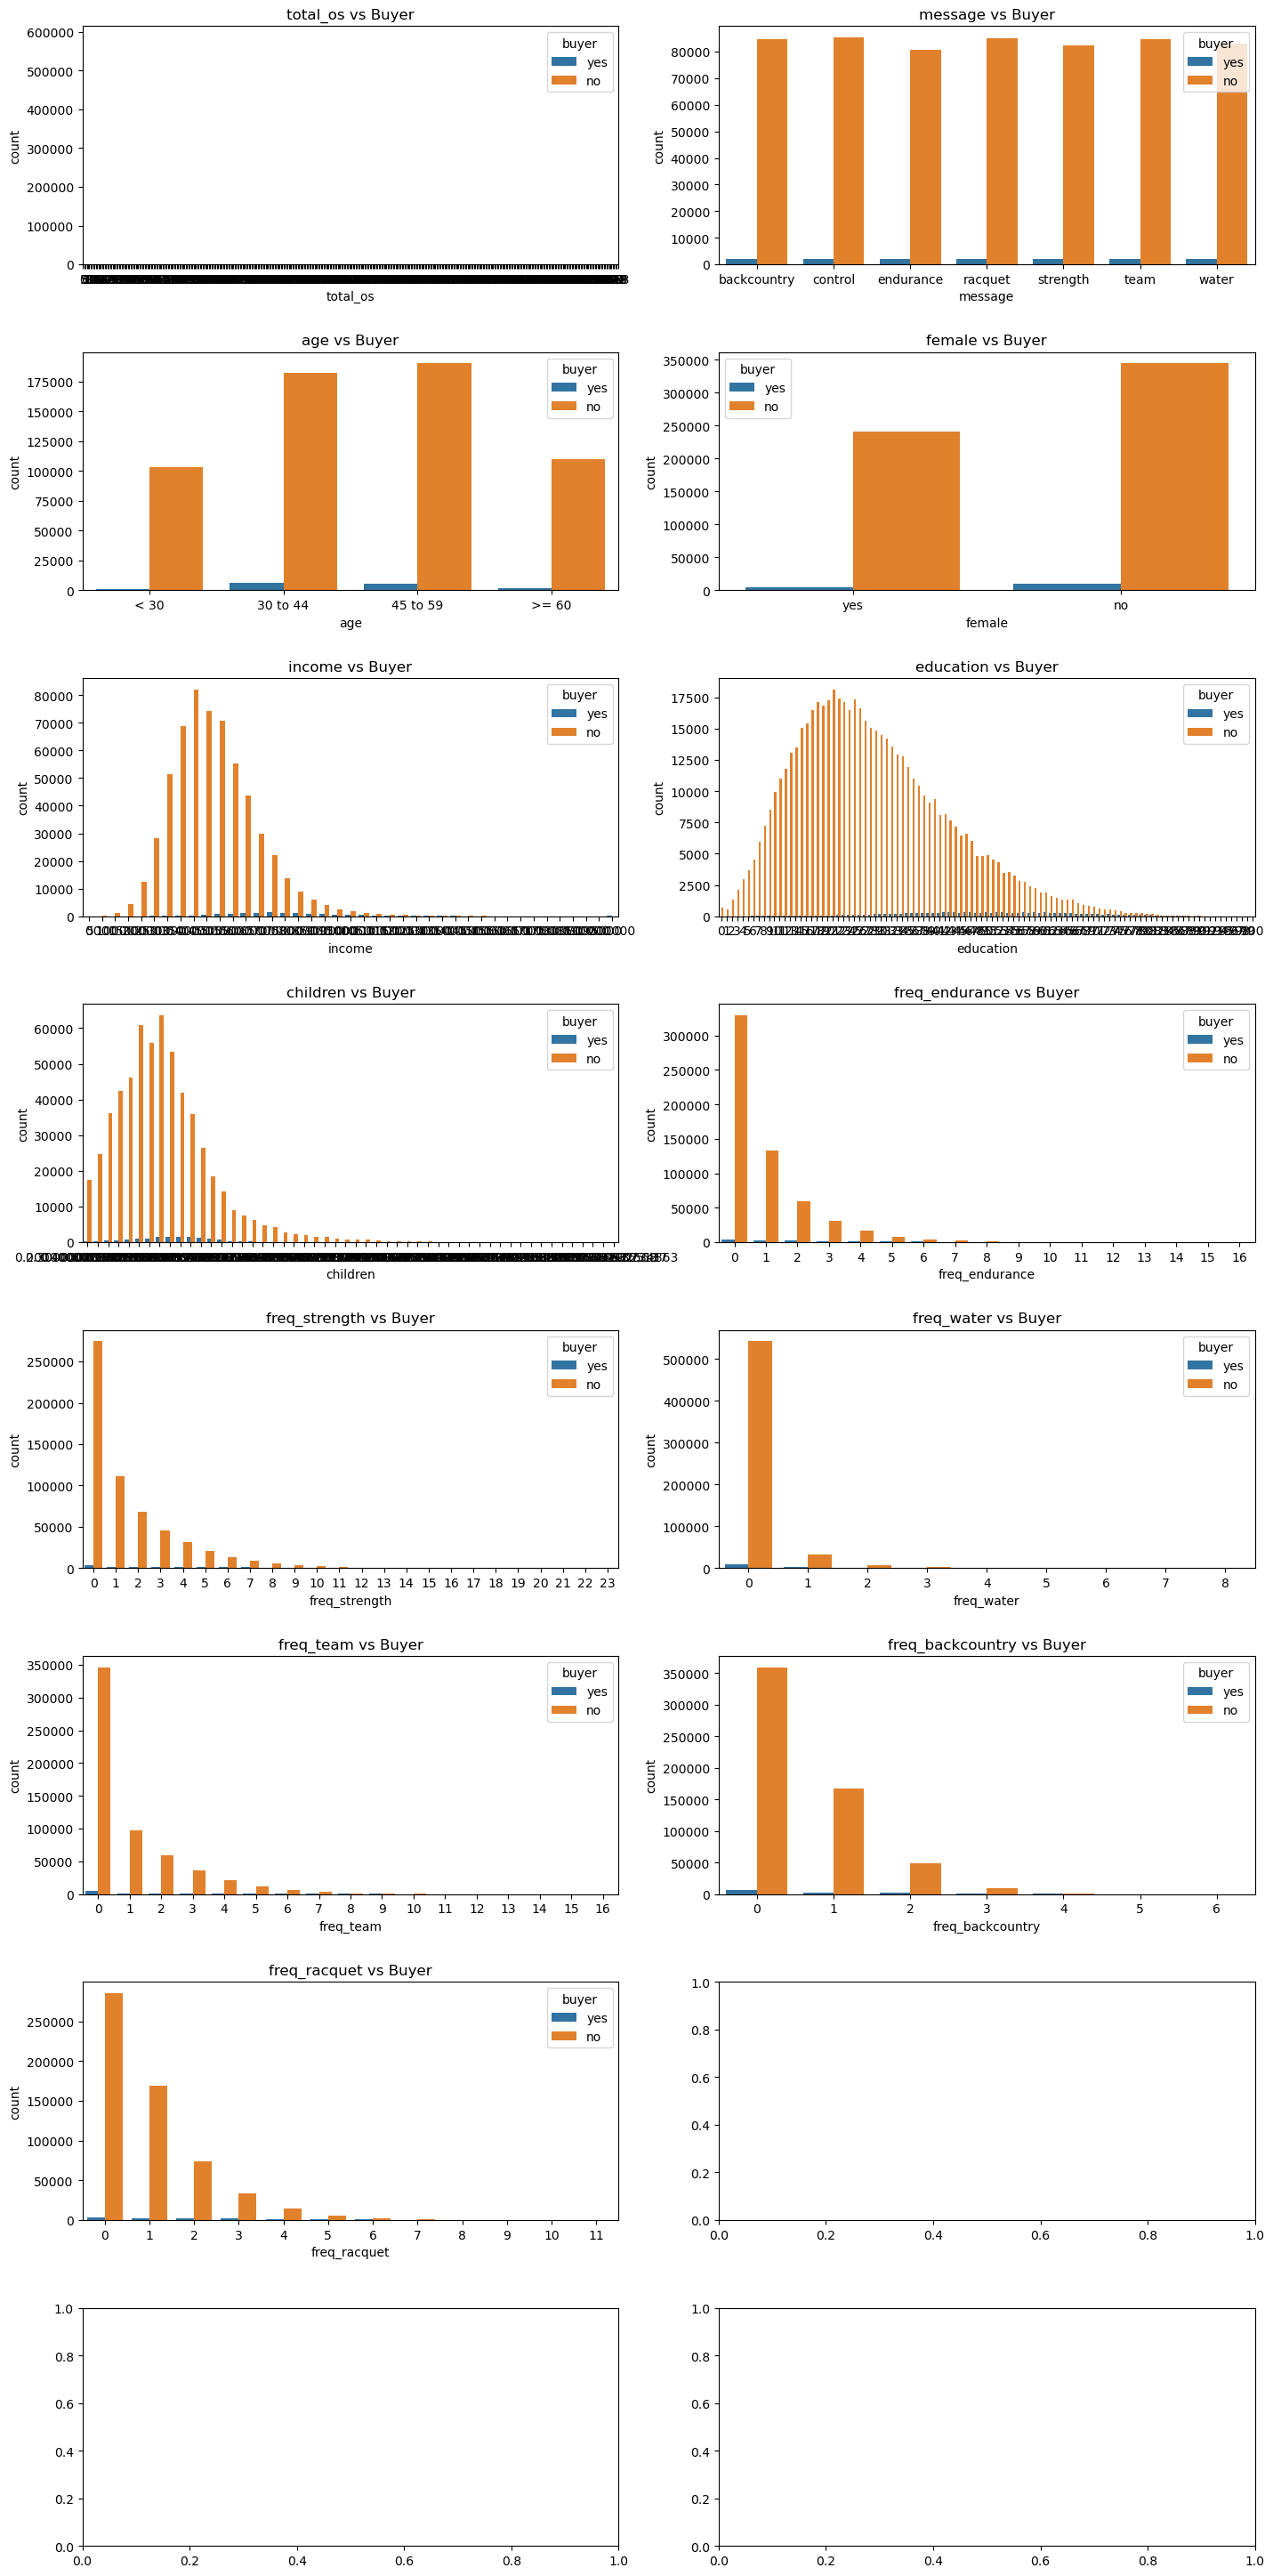

In [68]:
import seaborn as sns

import matplotlib.pyplot as plt

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(15, 30))
fig.tight_layout(pad=5.0)

# List of columns to plot
columns = pentathlon_nptb.columns.drop(['custid', 'buyer', 'training'])

# Plot each variable vs buyer
for ax, column in zip(axes.flatten(), columns):
    sns.countplot(data=pentathlon_nptb, x=column, hue='buyer', ax=ax)
    ax.set_title(f'{column} vs Buyer')

plt.show()

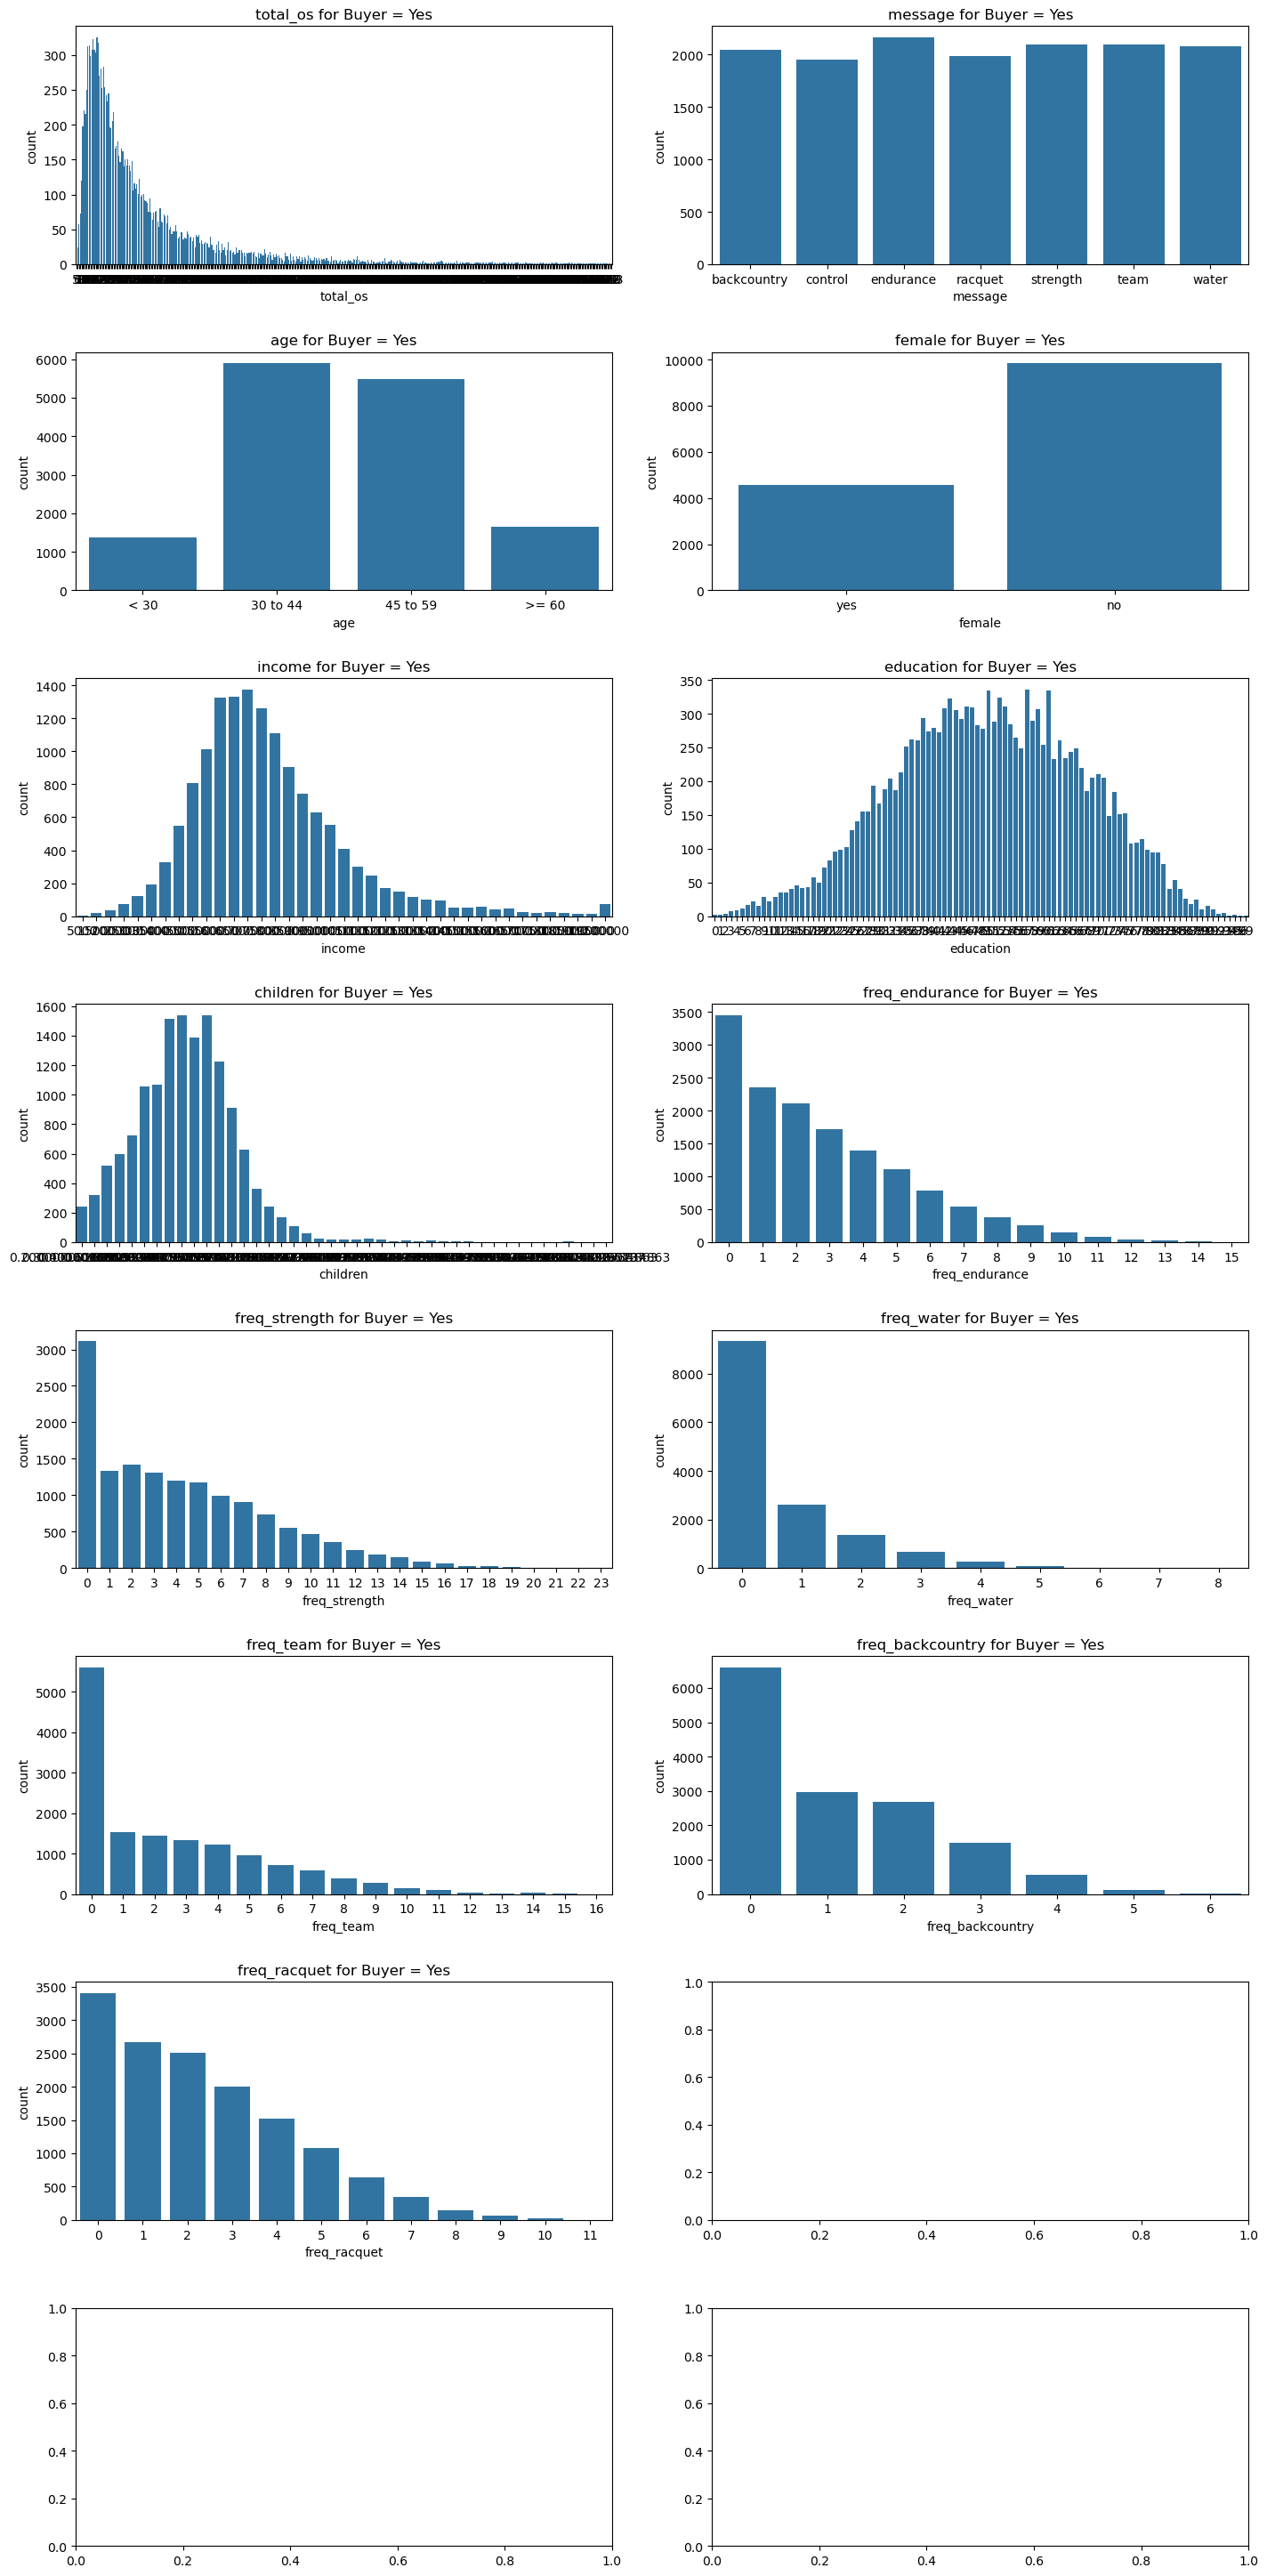

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the dataset for buyer = yes
pentathlon_nptb_yes = pentathlon_nptb[pentathlon_nptb['buyer'] == 'yes']

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(15, 30))
fig.tight_layout(pad=5.0)

# List of columns to plot
columns = pentathlon_nptb_yes.columns.drop(['custid', 'buyer', 'training'])

# Plot each variable vs buyer
for ax, column in zip(axes.flatten(), columns):
    sns.countplot(data=pentathlon_nptb_yes, x=column, ax=ax)
    ax.set_title(f'{column} for Buyer = Yes')

plt.show()

In [70]:
# Calculate the sum of all frequency variables for each customer
pentathlon_nptb['total_freq'] = pentathlon_nptb[['freq_endurance', 'freq_strength', 'freq_water', 'freq_team', 'freq_backcountry', 'freq_racquet']].sum(axis=1)

# Rank customers based on the total frequency of purchases
ranked_customers = pentathlon_nptb[['custid', 'total_freq', 'buyer']].sort_values(by='total_freq', ascending=False)

# Display the ranked customers
print(ranked_customers.head(10))  # Display top 10 customers

          custid  total_freq buyer
115636   U662081          61   yes
102619   U587490          57   yes
314135  U1807983          56   yes
202570  U1165553          56   yes
436127  U2516744          53   yes
261888  U1506354          53   yes
432885  U2498304          53   yes
22666    U129243          52   yes
394698  U2276678          52   yes
568788  U3281941          51   yes


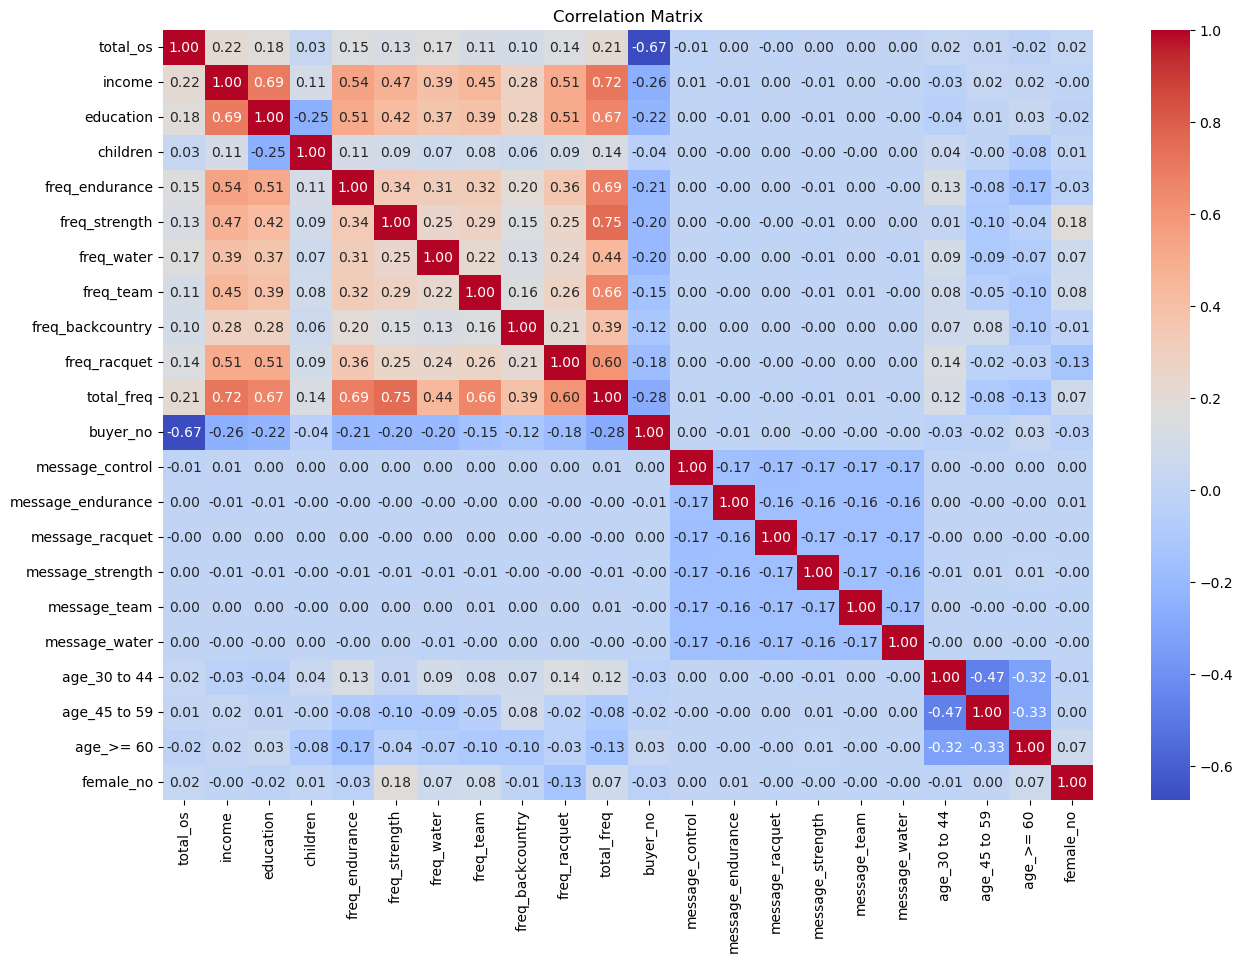

In [71]:
# Drop 'custid' and 'training' columns
data = pentathlon_nptb.drop(columns=['custid', 'training'])

# Convert categorical variables into dummy/indicator variables
data_dummies = pd.get_dummies(data, drop_first=True)

# Calculate the correlation matrix
correlation_matrix = data_dummies.corr()

# Plot the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [72]:
# Calculate the percentage of buyers in the training set
train_buyers_percentage = pentathlon_nptb[pentathlon_nptb['training'] == 1]['buyer'].value_counts(normalize=True) * 100

# Calculate the percentage of buyers in the test set
test_buyers_percentage = pentathlon_nptb[pentathlon_nptb['training'] == 0]['buyer'].value_counts(normalize=True) * 100

print("Training set buyers percentage:")
print(train_buyers_percentage)

print("\nTest set buyers percentage:")
print(test_buyers_percentage)

Training set buyers percentage:
buyer
no     97.6
yes     2.4
Name: proportion, dtype: float64

Test set buyers percentage:
buyer
no     97.6
yes     2.4
Name: proportion, dtype: float64


- Data seems heavily imbalanced and skewed, with only 2.4% buyers - reflected in buyers and freq... columns
- Income and children seemed skewed left
- Education and age are also slightly skewed left but relatively normally distributed
- correlations observed between education and income (0.69)
- order size should not be use because it is a result of the purchase, not a predictor of it


## Part 1 - Generate customized predictions for each customer
Perform the analysis following the instruction e-mailed by Anna to the analytics team 
(Step 1 to 8 above). Use logistic regression, neural networks, random forests, XGBoost. Each ML model must be tuned using at least two hyper parameters (40 
points)  

“Please perform all estimation using the training sample. Use the test sample to assess model 
performance for the binary decision of whether a customer buys after receiving a particular 
message or no-message." 

## Data Transformation

In [73]:
# transform data?
#log transform totalos, income, children, freq...
# std scale education, children
# one hot encode message age female
# Balance buyer "class_weight - 'balanced'"

#corelation between income and education

#do not use order size

# drop custid, training

# check for VIF always!

In [74]:
import numpy as np

# Apply log+1 transformation to specified columns
pentathlon_nptb_log = pentathlon_nptb.copy()
columns_to_transform = ['income', 'children', 'education', 'freq_endurance', 'freq_strength', 'freq_water', 'freq_team', 'freq_backcountry', 'freq_racquet']
pentathlon_nptb_log[columns_to_transform] = pentathlon_nptb_log[columns_to_transform].apply(lambda x: np.log1p(x))

# One hot encode 'message', 'age', and 'female' columns
#pentathlon_nptb_log = pd.get_dummies(pentathlon_nptb_log, columns=['message', 'age', 'female'], drop_first=False)

# Rename columns
pentathlon_nptb_log.rename(columns={'age_30 to 44': 'age_30_44', 'age_45 to 59': 'age_45_59', 'age_>= 60': 'age_60a'}, inplace=True)

# Display the transformed dataset
pentathlon_nptb_log.head()

custid buyer  total_os      message       age female     income  education  \
0     U1    no         0         team  30 to 44     no  10.915107   2.995732   
1     U3    no         0  backcountry  45 to 59     no  10.463132   3.135494   
2    U13    no         0    endurance  45 to 59    yes  10.714440   3.526361   
3    U20    no         0        water  45 to 59    yes  10.126671   3.218876   
4    U25    no         0      racquet     >= 60    yes  11.082158   3.496508   

   children  freq_endurance  freq_strength  freq_water  freq_team  \
0  0.587787        0.000000       1.609438         0.0   1.609438   
1  0.693147        0.000000       0.000000         0.0   0.693147   
2  0.530628        0.000000       0.000000         0.0   0.000000   
3  0.182322        0.000000       0.000000         0.0   0.000000   
4  0.741937        0.693147       1.098612         0.0   0.000000   

   freq_backcountry  freq_racquet  training  total_freq  
0          0.000000      0.693147       1.0           9  
1          0.000000      0.000000       0.0           1  
2          1.098612      1.098612       1.0           4  
3          0.000000      0.000000       1.0           0  
4          1.098612      1.098612       0.0           7

In [75]:
#Balancing buyer weights

import pandas as pd
import numpy as np

# Example: Assuming df is your dataset
class_counts = pentathlon_nptb_log['buyer'].value_counts()
total_samples = len(pentathlon_nptb_log)

# Compute weights inversely proportional to class frequency
class_weights = {cls: total_samples / (2 * count) for cls, count in class_counts.items()}

# Assign weights to each row based on the buyer class
pentathlon_nptb_log['weight'] = pentathlon_nptb_log['buyer'].map(class_weights)


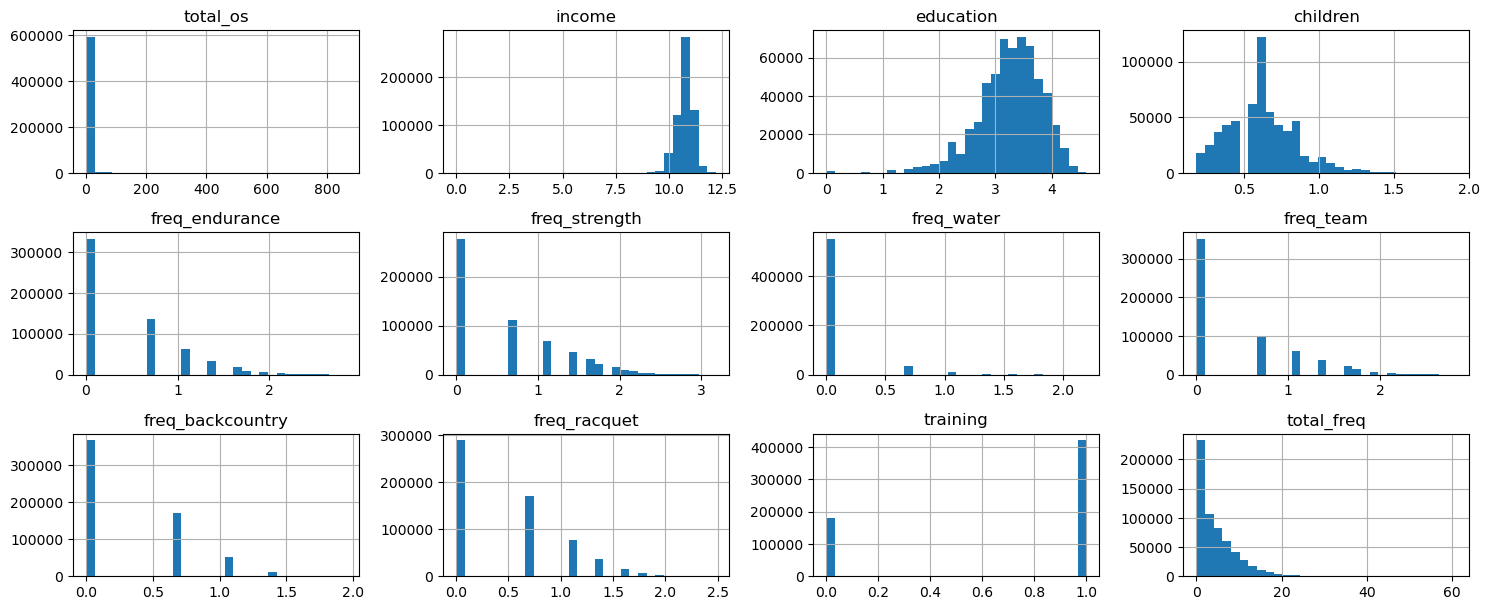

In [76]:
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_columns = pentathlon_nptb_log.select_dtypes(include=['float64', 'int64', 'int32']).columns

# Plot histograms for each numeric variable
pentathlon_nptb_log[numeric_columns].hist(bins=30, figsize=(15, 10), layout=(5, 4))
plt.tight_layout()
plt.show()

In [77]:
print(pentathlon_nptb_log.columns)

Index(['custid', 'buyer', 'total_os', 'message', 'age', 'female', 'income',
       'education', 'children', 'freq_endurance', 'freq_strength',
       'freq_water', 'freq_team', 'freq_backcountry', 'freq_racquet',
       'training', 'total_freq', 'weight'],
      dtype='object')


#### Logistic Regression Model

In [78]:
#evars = ['income', 'education', 'children',
#       'freq_endurance', 'freq_strength', 'freq_water', 'freq_team',
#       'freq_backcountry', 'freq_racquet', 'message_control', 'message_endurance', 'message_racquet',
#       'message_strength', 'message_team', 'message_water', 'age_30_44', 'age_45_59', 'age_60a', 'female_no']

evars = ['income', 'education', 'children',
       'freq_endurance', 'freq_strength', 'freq_water', 'freq_team',
       'freq_backcountry', 'freq_racquet', 'message', 'age', 'female']	

1. For  each  customer  determine  the  message  (i.e.,  endurance,  strength,  water,  team, 
backcountry,  racquet,  or  no-message)  predicted  to  lead  to  the  highest  probability  of 
purchase. 

In [79]:
clf1 = rsm.model.logistic(
    data={"pentathlon_nptb_log_train": pentathlon_nptb_log[pentathlon_nptb_log['training'] == 1]},
    rvar="buyer",
    lev="yes",
    evar= evars,
    #weights= "weight",
)

In [80]:
clf1.summary()

Logistic regression (GLM)
Data                 : pentathlon_nptb_log_train
Response variable    : buyer
Level                : yes
Explanatory variables: income, education, children, freq_endurance, freq_strength, freq_water, freq_team, freq_backcountry, freq_racquet, message, age, female
Null hyp.: There is no effect of x on buyer
Alt. hyp.: There is an effect of x on buyer

                       OR      OR%  coefficient  std.error  z.value p.value     
Intercept           0.000  -100.0%      -30.196      0.519  -58.208  < .001  ***
message[control]    0.911    -8.9%       -0.093      0.041   -2.251   0.024    *
message[endurance]  1.255    25.5%        0.227      0.040    5.648  < .001  ***
message[racquet]    0.993    -0.7%       -0.007      0.041   -0.165   0.869     
message[strength]   1.169    16.9%        0.156      0.040    3.865  < .001  ***
message[team]       1.041     4.1%        0.040      0.041    0.980   0.327     
message[water]      1.067     6.7%        0.064      0

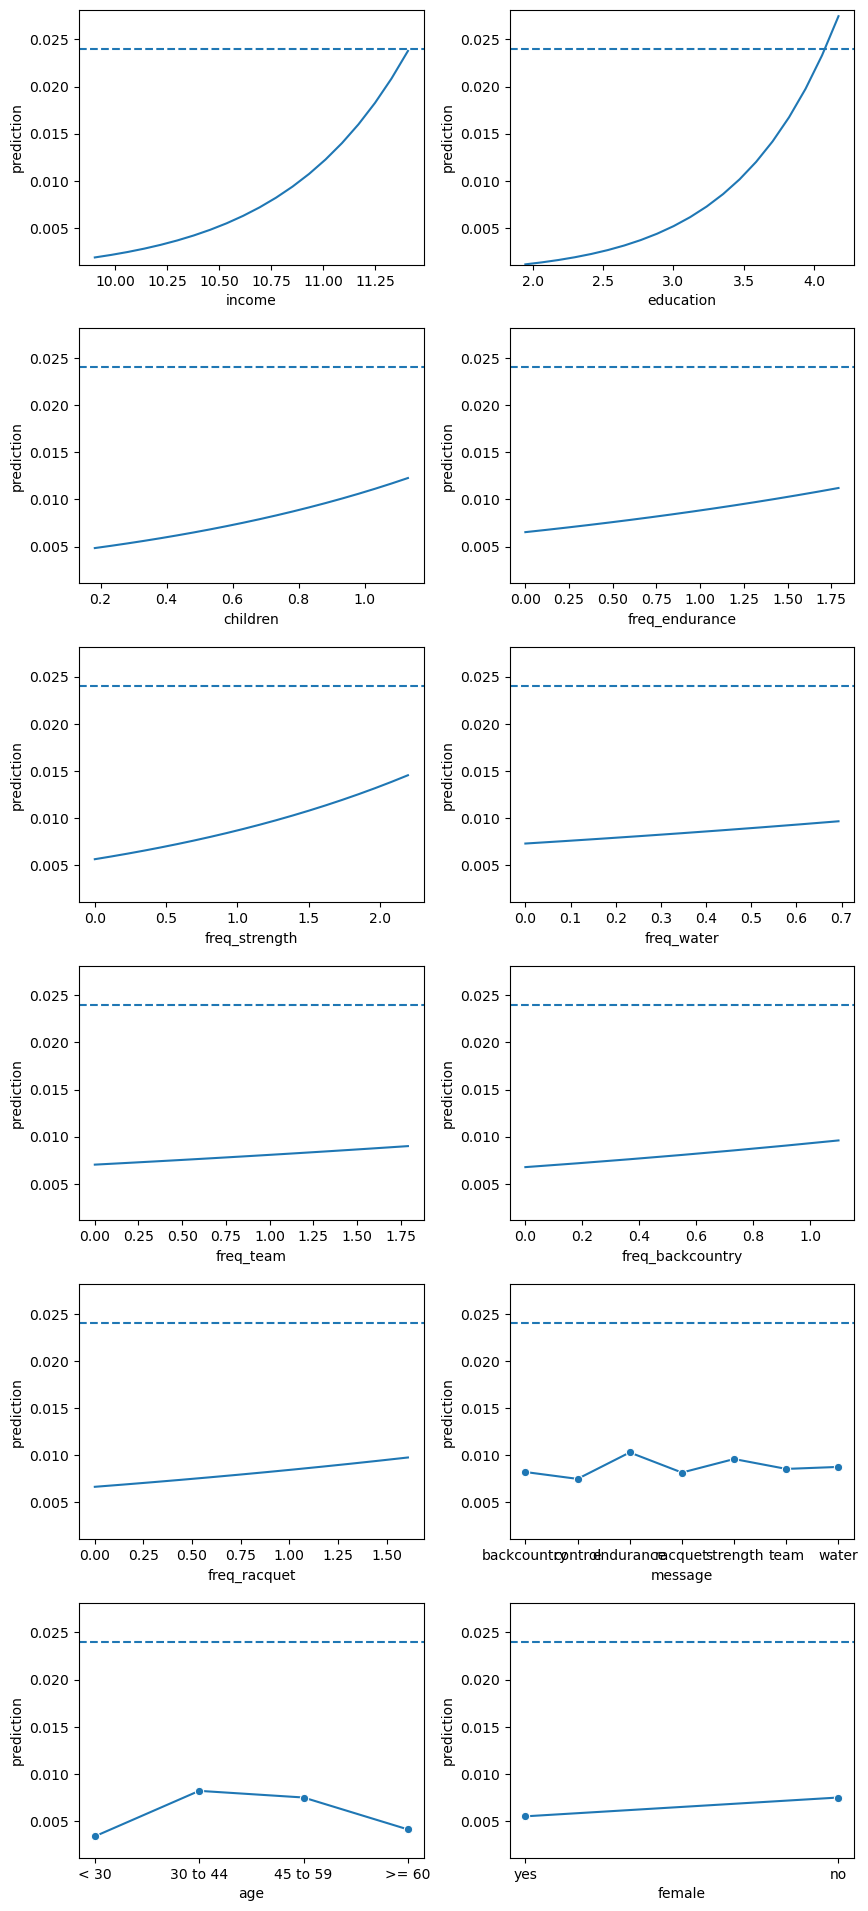

In [81]:
clf1.plot("pred",hline=True)

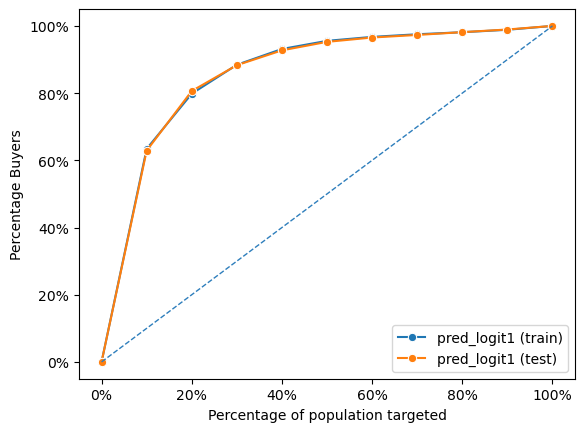

In [82]:
pentathlon_nptb_log['pred_logit1'] = clf1.predict(pentathlon_nptb_log)['prediction']


dct_clf1= {"train": pentathlon_nptb_log[pentathlon_nptb_log['training']==1], "test": pentathlon_nptb_log[pentathlon_nptb_log['training']==0]}
fig_clf1 = rsm.gains_plot(dct_clf1, "buyer", "yes", "pred_logit1")

In [83]:
pentathlon_nptb_log['p_endurance'] = clf1.predict(pentathlon_nptb_log, data_cmd={"message": "endurance"})["prediction"]	
pentathlon_nptb_log['p_strength'] = clf1.predict(pentathlon_nptb_log, data_cmd={"message": "strength"})["prediction"]
pentathlon_nptb_log['p_water'] = clf1.predict(pentathlon_nptb_log, data_cmd={"message": "water"})["prediction"]
pentathlon_nptb_log['p_team'] = clf1.predict(pentathlon_nptb_log, data_cmd={"message": "team"})["prediction"]
pentathlon_nptb_log['p_backcountry'] = clf1.predict(pentathlon_nptb_log, data_cmd={"message": "backcountry"})["prediction"]
pentathlon_nptb_log['p_racquet'] = clf1.predict(pentathlon_nptb_log, data_cmd={"message": "racquet"})["prediction"]
pentathlon_nptb_log['p_control'] = clf1.predict(pentathlon_nptb_log, data_cmd={"message": "control"})["prediction"]
pentathlon_nptb_log


custid buyer  total_os      message       age female     income  \
0             U1    no         0         team  30 to 44     no  10.915107   
1             U3    no         0  backcountry  45 to 59     no  10.463132   
2            U13    no         0    endurance  45 to 59    yes  10.714440   
3            U20    no         0        water  45 to 59    yes  10.126671   
4            U25    no         0      racquet     >= 60    yes  11.082158   
...          ...   ...       ...          ...       ...    ...        ...   
599995  U3462888    no         0        water     >= 60    yes  10.596660   
599996  U3462900    no         0         team      < 30     no  10.915107   
599997  U3462902    no         0         team      < 30    yes  10.915107   
599998  U3462916    no         0         team      < 30     no  10.819798   
599999  U3462922    no         0    endurance  30 to 44    yes  10.819798   

        education  children  freq_endurance  ...  total_freq    weight  \
0        2.995732  0.587787        0.000000  ...           9  0.512295   
1        3.135494  0.693147        0.000000  ...           1  0.512295   
2        3.526361  0.530628        0.000000  ...           4  0.512295   
3        3.218876  0.182322        0.000000  ...           0  0.512295   
4        3.496508  0.741937        0.693147  ...           7  0.512295   
...           ...       ...             ...  ...         ...       ...   
599995   3.295837  0.470004        0.000000  ...           0  0.512295   
599996   3.496508  0.641854        1.386294  ...           5  0.512295   
599997   3.496508  0.641854        0.000000  ...          10  0.512295   
599998   3.583519  0.470004        1.098612  ...           5  0.512295   
599999   3.258097  0.530628        0.693147  ...           5  0.512295   

        pred_logit1  p_endurance  p_strength   p_water    p_team  \
0          0.012173     0.014645    0.013658  0.012473  0.012173   
1          0.002511     0.003149    0.002934  0.002677  0.002612   
2          0.008835     0.008835    0.008236  0.007518  0.007337   
3          0.000686     0.000807    0.000751  0.000686  0.000669   
4          0.016673     0.020975    0.019570  0.017882  0.017454   
...             ...          ...         ...       ...       ...   
599995     0.001237     0.001456    0.001356  0.001237  0.001207   
599996     0.008888     0.010700    0.009976  0.009108  0.008888   
599997     0.011014     0.013253    0.012359  0.011286  0.011014   
599998     0.007908     0.009522    0.008877  0.008104  0.007908   
599999     0.011000     0.011000    0.010256  0.009364  0.009138   

       p_backcountry  p_racquet  p_control  
0           0.011704   0.011626   0.010674  
1           0.002511   0.002494   0.002288  
2           0.007053   0.007005   0.006429  
3           0.000643   0.000638   0.000586  
4           0.016785   0.016673   0.015314  
...              ...        ...        ...  
599995      0.001160   0.001152   0.001057  
599996      0.008545   0.008487   0.007790  
599997      0.010589   0.010518   0.009656  
599998      0.007602   0.007551   0.006930  
599999      0.008785   0.008726   0.008010  

[600000 rows x 26 columns]

In [84]:
#find best message for each customer

pentathlon_nptb_log['best_message'] = pentathlon_nptb_log[['p_endurance', 'p_strength', 'p_water', 'p_team', 'p_backcountry', 'p_racquet', 'p_control']].idxmax(axis=1).str.replace('p_', '')
pentathlon_nptb_log

custid buyer  total_os      message       age female     income  \
0             U1    no         0         team  30 to 44     no  10.915107   
1             U3    no         0  backcountry  45 to 59     no  10.463132   
2            U13    no         0    endurance  45 to 59    yes  10.714440   
3            U20    no         0        water  45 to 59    yes  10.126671   
4            U25    no         0      racquet     >= 60    yes  11.082158   
...          ...   ...       ...          ...       ...    ...        ...   
599995  U3462888    no         0        water     >= 60    yes  10.596660   
599996  U3462900    no         0         team      < 30     no  10.915107   
599997  U3462902    no         0         team      < 30    yes  10.915107   
599998  U3462916    no         0         team      < 30     no  10.819798   
599999  U3462922    no         0    endurance  30 to 44    yes  10.819798   

        education  children  freq_endurance  ...    weight  pred_logit1  \
0        2.995732  0.587787        0.000000  ...  0.512295     0.012173   
1        3.135494  0.693147        0.000000  ...  0.512295     0.002511   
2        3.526361  0.530628        0.000000  ...  0.512295     0.008835   
3        3.218876  0.182322        0.000000  ...  0.512295     0.000686   
4        3.496508  0.741937        0.693147  ...  0.512295     0.016673   
...           ...       ...             ...  ...       ...          ...   
599995   3.295837  0.470004        0.000000  ...  0.512295     0.001237   
599996   3.496508  0.641854        1.386294  ...  0.512295     0.008888   
599997   3.496508  0.641854        0.000000  ...  0.512295     0.011014   
599998   3.583519  0.470004        1.098612  ...  0.512295     0.007908   
599999   3.258097  0.530628        0.693147  ...  0.512295     0.011000   

        p_endurance  p_strength   p_water    p_team  p_backcountry p_racquet  \
0          0.014645    0.013658  0.012473  0.012173       0.011704  0.011626   
1          0.003149    0.002934  0.002677  0.002612       0.002511  0.002494   
2          0.008835    0.008236  0.007518  0.007337       0.007053  0.007005   
3          0.000807    0.000751  0.000686  0.000669       0.000643  0.000638   
4          0.020975    0.019570  0.017882  0.017454       0.016785  0.016673   
...             ...         ...       ...       ...            ...       ...   
599995     0.001456    0.001356  0.001237  0.001207       0.001160  0.001152   
599996     0.010700    0.009976  0.009108  0.008888       0.008545  0.008487   
599997     0.013253    0.012359  0.011286  0.011014       0.010589  0.010518   
599998     0.009522    0.008877  0.008104  0.007908       0.007602  0.007551   
599999     0.011000    0.010256  0.009364  0.009138       0.008785  0.008726   

        p_control  best_message  
0        0.010674     endurance  
1        0.002288     endurance  
2        0.006429     endurance  
3        0.000586     endurance  
4        0.015314     endurance  
...           ...           ...  
599995   0.001057     endurance  
599996   0.007790     endurance  
599997   0.009656     endurance  
599998   0.006930     endurance  
599999   0.008010     endurance  

[600000 rows x 27 columns]

In [85]:
pd.crosstab(index=pentathlon_nptb_log[pentathlon_nptb_log.training == 0].best_message, columns="count").apply(rsm.format_nr)

col_0           count
best_message         
endurance     180,000

Every customer is recommended endurance, which is not customized!!

The whole point of customization is that different offers may work better for different customers. In other words, we want to customize messages because we think that there might be an interaction between (1) who the customer is and (2) how effective the message is. Hence, we need to interact message with the variables that describe customer characteristics.

In [86]:
ivar = [f"{e}:message" for e in evars if e != "message"]
ivar

['income:message',
 'education:message',
 'children:message',
 'freq_endurance:message',
 'freq_strength:message',
 'freq_water:message',
 'freq_team:message',
 'freq_backcountry:message',
 'freq_racquet:message',
 'age:message',
 'female:message']

In [87]:
clf_int = rsm.model.logistic(
    data={"bbb_nptb": pentathlon_nptb_log[pentathlon_nptb_log.training == 1]}, rvar="buyer", lev="yes", evar=evars, ivar=ivar
)
clf_int.summary()

Logistic regression (GLM)
Data                 : bbb_nptb
Response variable    : buyer
Level                : yes
Explanatory variables: income, education, children, freq_endurance, freq_strength, freq_water, freq_team, freq_backcountry, freq_racquet, message, age, female
Null hyp.: There is no effect of x on buyer
Alt. hyp.: There is an effect of x on buyer

                                        OR      OR%  coefficient  std.error  z.value p.value     
Intercept                            0.000  -100.0%      -30.382      1.363  -22.294  < .001  ***
message[control]                     0.778   -22.2%       -0.251      1.974   -0.127   0.899     
message[endurance]                   0.356   -64.4%       -1.034      1.917   -0.539    0.59     
message[racquet]                     1.808    80.8%        0.592      1.944    0.305   0.761     
message[strength]                    4.176   317.6%        1.429      1.904    0.751   0.453     
message[team]                        1.292    29.2

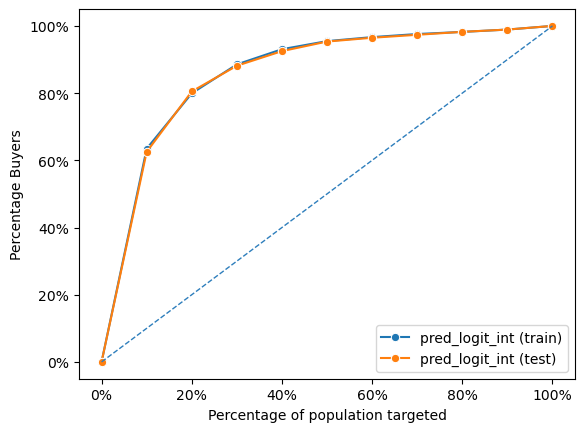

In [88]:
pentathlon_nptb_log['pred_logit_int'] = clf_int.predict(pentathlon_nptb_log)['prediction']


dct_clfint= {"train": pentathlon_nptb_log[pentathlon_nptb_log['training']==1], "test": pentathlon_nptb_log[pentathlon_nptb_log['training']==0]}
fig_clfint = rsm.gains_plot(dct_clfint, "buyer", "yes", "pred_logit_int")

In [89]:
pentathlon_nptb_log_test = pentathlon_nptb_log[pentathlon_nptb_log['training'] == 0]

In [90]:
pentathlon_nptb_log_test['p_endurance_int'] = clf_int.predict(pentathlon_nptb_log_test, data_cmd={"message": "endurance"})["prediction"]	
pentathlon_nptb_log_test['p_strength_int'] = clf_int.predict(pentathlon_nptb_log_test, data_cmd={"message": "strength"})["prediction"]
pentathlon_nptb_log_test['p_water_int'] = clf_int.predict(pentathlon_nptb_log_test, data_cmd={"message": "water"})["prediction"]
pentathlon_nptb_log_test['p_team_int'] = clf_int.predict(pentathlon_nptb_log_test, data_cmd={"message": "team"})["prediction"]
pentathlon_nptb_log_test['p_backcountry_int'] = clf_int.predict(pentathlon_nptb_log_test, data_cmd={"message": "backcountry"})["prediction"]
pentathlon_nptb_log_test['p_racquet_int'] = clf_int.predict(pentathlon_nptb_log_test, data_cmd={"message": "racquet"})["prediction"]
pentathlon_nptb_log_test['p_control_int'] = clf_int.predict(pentathlon_nptb_log_test, data_cmd={"message": "control"})["prediction"]
pentathlon_nptb_log_test


/tmp/ipykernel_35906/53524665.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pentathlon_nptb_log_test['p_endurance_int'] = clf_int.predict(pentathlon_nptb_log_test, data_cmd={"message": "endurance"})["prediction"]
/tmp/ipykernel_35906/53524665.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pentathlon_nptb_log_test['p_strength_int'] = clf_int.predict(pentathlon_nptb_log_test, data_cmd={"message": "strength"})["prediction"]
/tmp/ipykernel_35906/53524665.py:3: SettingWithCopyWarning: 
A value is tryi

custid buyer  total_os      message       age female     income  \
1             U3    no         0  backcountry  45 to 59     no  10.463132   
4            U25    no         0      racquet     >= 60    yes  11.082158   
6            U30    no         0    endurance      < 30    yes  11.082158   
7            U55    no         0     strength  30 to 44     no  10.463132   
15           U97    no         0    endurance      < 30    yes  11.082158   
...          ...   ...       ...          ...       ...    ...        ...   
599991  U3462852    no         0        water  30 to 44    yes  10.819798   
599994  U3462887    no         0      control      < 30    yes  10.308986   
599996  U3462900    no         0         team      < 30     no  10.915107   
599998  U3462916    no         0         team      < 30     no  10.819798   
599999  U3462922    no         0    endurance  30 to 44    yes  10.819798   

        education  children  freq_endurance  ...  p_control  best_message  \
1        3.135494  0.693147        0.000000  ...   0.002288     endurance   
4        3.496508  0.741937        0.693147  ...   0.015314     endurance   
6        4.143135  0.405465        0.693147  ...   0.042241     endurance   
7        2.890372  0.741937        0.000000  ...   0.001849     endurance   
15       3.713572  0.530628        1.609438  ...   0.030523     endurance   
...           ...       ...             ...  ...        ...           ...   
599991   2.995732  0.741937        0.000000  ...   0.004610     endurance   
599994   2.708050  0.641854        0.693147  ...   0.000335     endurance   
599996   3.496508  0.641854        1.386294  ...   0.007790     endurance   
599998   3.583519  0.470004        1.098612  ...   0.006930     endurance   
599999   3.258097  0.530628        0.693147  ...   0.008010     endurance   

        pred_logit_int  p_endurance_int  p_strength_int  p_water_int  \
1             0.002739         0.003268        0.002815     0.002357   
4             0.017395         0.027972        0.015825     0.015807   
6             0.049480         0.049480        0.060008     0.048300   
7             0.002640         0.002757        0.002640     0.001775   
15            0.040344         0.040344        0.037276     0.036075   
...                ...              ...             ...          ...   
599991        0.004500         0.008363        0.005315     0.004500   
599994        0.000358         0.000522        0.000399     0.000291   
599996        0.009549         0.009560        0.009800     0.006688   
599998        0.008417         0.008296        0.008737     0.006023   
599999        0.013286         0.013286        0.009468     0.008062   

        p_team_int p_backcountry_int  p_racquet_int  p_control_int  
1         0.002412          0.002739       0.002885       0.002125  
4         0.016277          0.016779       0.017395       0.015495  
6         0.045821          0.053213       0.040852       0.044656  
7         0.001882          0.001923       0.002292       0.001819  
15        0.033527          0.034800       0.031747       0.033109  
...            ...               ...            ...            ...  
599991    0.004708          0.004824       0.005064       0.005095  
599994    0.000346          0.000402       0.000407       0.000358  
599996    0.009549          0.009601       0.009890       0.008358  
599998    0.008417          0.008586       0.008598       0.007743  
599999    0.008903          0.008053       0.008248       0.009392  

[180000 rows x 35 columns]

In [91]:
#find best message for each customer

pentathlon_nptb_log_test['best_message_int'] = pentathlon_nptb_log_test[['p_endurance_int', 'p_strength_int', 'p_water_int', 'p_team_int', 'p_backcountry_int', 'p_racquet_int', 'p_control_int']].idxmax(axis=1).str.replace('p_', '').str.replace('_int', '')
pentathlon_nptb_log_test

/tmp/ipykernel_35906/2771684821.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pentathlon_nptb_log_test['best_message_int'] = pentathlon_nptb_log_test[['p_endurance_int', 'p_strength_int', 'p_water_int', 'p_team_int', 'p_backcountry_int', 'p_racquet_int', 'p_control_int']].idxmax(axis=1).str.replace('p_', '').str.replace('_int', '')


custid buyer  total_os      message       age female     income  \
1             U3    no         0  backcountry  45 to 59     no  10.463132   
4            U25    no         0      racquet     >= 60    yes  11.082158   
6            U30    no         0    endurance      < 30    yes  11.082158   
7            U55    no         0     strength  30 to 44     no  10.463132   
15           U97    no         0    endurance      < 30    yes  11.082158   
...          ...   ...       ...          ...       ...    ...        ...   
599991  U3462852    no         0        water  30 to 44    yes  10.819798   
599994  U3462887    no         0      control      < 30    yes  10.308986   
599996  U3462900    no         0         team      < 30     no  10.915107   
599998  U3462916    no         0         team      < 30     no  10.819798   
599999  U3462922    no         0    endurance  30 to 44    yes  10.819798   

        education  children  freq_endurance  ...  best_message  \
1        3.135494  0.693147        0.000000  ...     endurance   
4        3.496508  0.741937        0.693147  ...     endurance   
6        4.143135  0.405465        0.693147  ...     endurance   
7        2.890372  0.741937        0.000000  ...     endurance   
15       3.713572  0.530628        1.609438  ...     endurance   
...           ...       ...             ...  ...           ...   
599991   2.995732  0.741937        0.000000  ...     endurance   
599994   2.708050  0.641854        0.693147  ...     endurance   
599996   3.496508  0.641854        1.386294  ...     endurance   
599998   3.583519  0.470004        1.098612  ...     endurance   
599999   3.258097  0.530628        0.693147  ...     endurance   

        pred_logit_int  p_endurance_int  p_strength_int  p_water_int  \
1             0.002739         0.003268        0.002815     0.002357   
4             0.017395         0.027972        0.015825     0.015807   
6             0.049480         0.049480        0.060008     0.048300   
7             0.002640         0.002757        0.002640     0.001775   
15            0.040344         0.040344        0.037276     0.036075   
...                ...              ...             ...          ...   
599991        0.004500         0.008363        0.005315     0.004500   
599994        0.000358         0.000522        0.000399     0.000291   
599996        0.009549         0.009560        0.009800     0.006688   
599998        0.008417         0.008296        0.008737     0.006023   
599999        0.013286         0.013286        0.009468     0.008062   

        p_team_int  p_backcountry_int p_racquet_int  p_control_int  \
1         0.002412           0.002739      0.002885       0.002125   
4         0.016277           0.016779      0.017395       0.015495   
6         0.045821           0.053213      0.040852       0.044656   
7         0.001882           0.001923      0.002292       0.001819   
15        0.033527           0.034800      0.031747       0.033109   
...            ...                ...           ...            ...   
599991    0.004708           0.004824      0.005064       0.005095   
599994    0.000346           0.000402      0.000407       0.000358   
599996    0.009549           0.009601      0.009890       0.008358   
599998    0.008417           0.008586      0.008598       0.007743   
599999    0.008903           0.008053      0.008248       0.009392   

        best_message_int  
1              endurance  
4              endurance  
6               strength  
7              endurance  
15             endurance  
...                  ...  
599991         endurance  
599994         endurance  
599996           racquet  
599998          strength  
599999         endurance  

[180000 rows x 36 columns]

In [92]:
pd.crosstab(index=pentathlon_nptb_log_test[pentathlon_nptb_log_test.training == 0].best_message_int, columns="count").apply(rsm.format_nr)

col_0               count
best_message_int         
backcountry         1,287
control                 1
endurance         131,767
racquet             8,232
strength           34,902
team                1,885
water               1,926

After adding the interaction on the log regression, we observe a distribution across all message types based on the highest probability of purchase predictions. According to our model, most customers have a higher probability of purchase when they receive an endurance promotion email, followed by strength and racquet. We can also see that control group has the least number of customers, which means that the proportion of customers who are predicted to organically purchase without any promotion are almost negligible. 



2.  For each message, report the percentage of customers for whom that message or no-
message  maximizes  their  probability  of  purchase. 

In [93]:
percentages_msg = pentathlon_nptb_log_test['best_message_int'].value_counts() / len(pentathlon_nptb_log_test) * 100
percentages_msg

best_message_int
endurance      73.203889
strength       19.390000
racquet         4.573333
water           1.070000
team            1.047222
backcountry     0.715000
control         0.000556
Name: count, dtype: float64

The distribution of expected response across messages shows that endurance messages' probability of purchase is far greater than that of the other messages. 73.2% of customers respond well to endurance promotions. In fact, the expected second best - Strength - is close to 4 times lesser despite almost 1 in 5 people responding well to this message cateogry. Racquet is about 5 times lesser than Strength suggesting that it does well for a very niche group of customer and has fairly minimal broad applicability. 
Water, team and backcountry have low expected probabilities of purchase and capture only specific subset while control is approximately 0% which strongly supports the idea that sending some form of email is always better than no communication.

3.  For  each  customer,  determine  the  message  (i.e.,  endurance,  strength,  water,  team, 
backcountry, racquet, or no-message) predicted to lead to the highest expected profit 
(COGS is 60%).

Order size predicition approach

We will predict the ordersize utilizing a linear regression model utilizing training data consisting only of BUYERS 
We will assess the model using r^2, F-stat, singificance of coefficients, and other regression diagnostics

First, we will scale the data and one-hot encode in order to develop the model


In [94]:
pentathlon_linear = pentathlon_nptb_log.copy()

from sklearn.preprocessing import OrdinalEncoder

#One hot encode 'message', 'age', and 'female' columns
# Ordinally encode 'age' variable
age_encoder = OrdinalEncoder(categories=[['< 30', '30 to 44', '45 to 59', '>= 60']])
pentathlon_linear['age'] = age_encoder.fit_transform(pentathlon_linear[['age']])
pentathlon_linear['female'] = pentathlon_linear['female'].apply(lambda x: 1 if x == 'yes' else 0)
pentathlon_linear['buyer'] = pentathlon_linear['buyer'].apply(lambda x: 1 if x == 'yes' else 0)
#pentathlon_linear['age'] = age_encoder.fit_transform(pentathlon_linear[['age']])

# One hot encode 'message' and 'female' columns
pentathlon_linear = pd.get_dummies(pentathlon_linear, columns=['message'], drop_first=True)

#log tranform total_os 
pentathlon_linear['total_os'] = np.log1p(pentathlon_linear['total_os'])

print(pentathlon_linear.columns)
pentathlon_linear.head()

Index(['custid', 'buyer', 'total_os', 'age', 'female', 'income', 'education',
       'children', 'freq_endurance', 'freq_strength', 'freq_water',
       'freq_team', 'freq_backcountry', 'freq_racquet', 'training',
       'total_freq', 'weight', 'pred_logit1', 'p_endurance', 'p_strength',
       'p_water', 'p_team', 'p_backcountry', 'p_racquet', 'p_control',
       'best_message', 'pred_logit_int', 'message_control',
       'message_endurance', 'message_racquet', 'message_strength',
       'message_team', 'message_water'],
      dtype='object')


custid buyer  total_os  age female     income  education  children  \
0     U1     0       0.0  1.0      0  10.915107   2.995732  0.587787   
1     U3     0       0.0  2.0      0  10.463132   3.135494  0.693147   
2    U13     0       0.0  2.0      1  10.714440   3.526361  0.530628   
3    U20     0       0.0  2.0      1  10.126671   3.218876  0.182322   
4    U25     0       0.0  3.0      1  11.082158   3.496508  0.741937   

   freq_endurance  freq_strength  ...  p_racquet  p_control  best_message  \
0        0.000000       1.609438  ...   0.011626   0.010674     endurance   
1        0.000000       0.000000  ...   0.002494   0.002288     endurance   
2        0.000000       0.000000  ...   0.007005   0.006429     endurance   
3        0.000000       0.000000  ...   0.000638   0.000586     endurance   
4        0.693147       1.098612  ...   0.016673   0.015314     endurance   

   pred_logit_int  message_control  message_endurance message_racquet  \
0        0.010185            False              False           False   
1        0.002739            False              False           False   
2        0.011156            False               True           False   
3        0.000606            False              False           False   
4        0.017395            False              False            True   

   message_strength  message_team  message_water  
0             False          True          False  
1             False         False          False  
2             False         False          False  
3             False         False           True  
4             False         False          False  

[5 rows x 33 columns]

In [95]:
evar_linear = [ 'income', 'education', 'children', 'freq_endurance', 'freq_strength', 'freq_water',
    'freq_team', 'freq_backcountry', 'freq_racquet','message_control',
    'message_endurance', 'message_racquet', 'message_strength',
    'message_team', 'message_water', 'female', 'age']

In [96]:
# interaction_terms = []
# for message_col in ['message_control', 'message_endurance', 'message_racquet', 'message_strength', 'message_team', 'message_water']:
#     for col in ['age', 'female', 'income', 'education', 'children']:
#         interaction_terms.append(f"{message_col}:{col}")

# interaction_terms

In [97]:
reg_os_size = rsm.model.regress(data={"pentathlon_os_nptb": pentathlon_linear[(pentathlon_linear.training == 1)&(pentathlon_linear.buyer==1)]}, rvar="total_os", evar=evar_linear)
reg_os_size.summary(vif=True)

Linear regression (OLS)
Data                 : pentathlon_os_nptb
Response variable    : total_os
Explanatory variables: income, education, children, freq_endurance, freq_strength, freq_water, freq_team, freq_backcountry, freq_racquet, message_control, message_endurance, message_racquet, message_strength, message_team, message_water, female, age
Null hyp.: the effect of x on total_os is zero
Alt. hyp.: the effect of x on total_os is not zero

                         coefficient  std.error  t.value p.value     
Intercept                     -0.951      0.327   -2.906   0.004   **
message_control[True]         -0.218      0.029   -7.520  < .001  ***
message_endurance[True]       -0.105      0.028   -3.774  < .001  ***
message_racquet[True]         -0.076      0.029   -2.651   0.008   **
message_strength[True]        -0.117      0.028   -4.142  < .001  ***
message_team[True]            -0.078      0.028   -2.757   0.006   **
message_water[True]            0.011      0.028    0.373   0.70

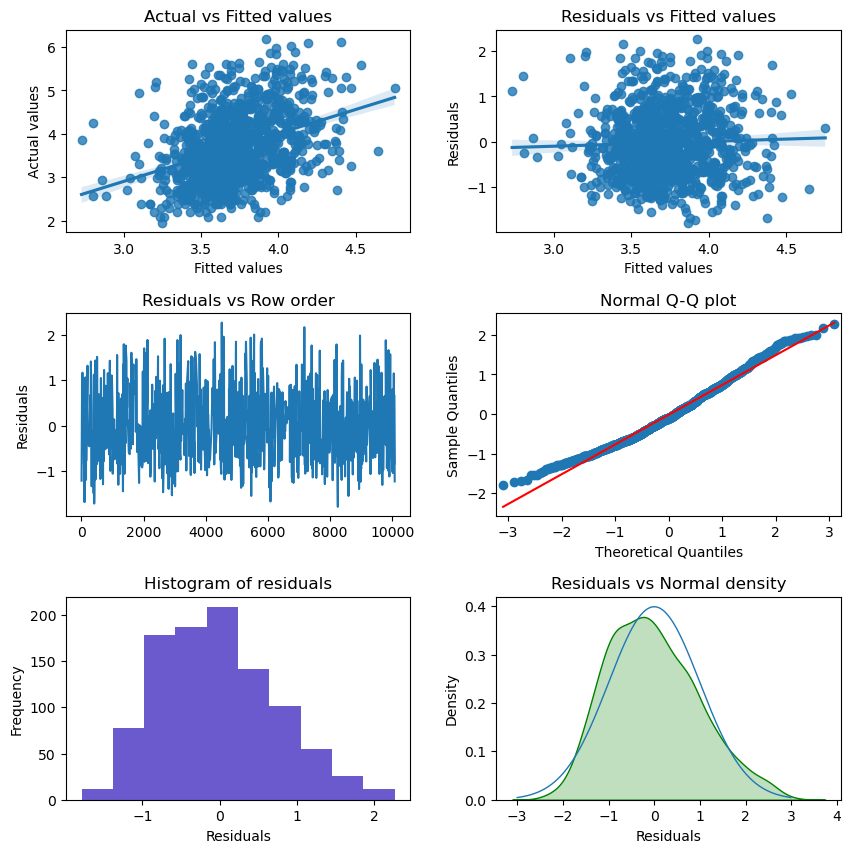

In [98]:
reg_os_size.plot('dashboard')

Focusing on the group of buyers who have already made a purchase to understand the factors that influence the order size is a sensible approach as it allows the company to better identify the factors that drive the number of sessions purchased and tailor future marketing strategies to similar customers, while avoiding biases that might arise from including non-buyers. 

However, The best regression model, after trying and testing multiple combinations, including experimentation with interactions, with no observed heteroscedasticity and multicollinearity is still yielding a very poor R^2 of 0.118, the model does not seem to capture the relationship between the explanatory variables and the response variable well, only explaining only 11.8% of the variance in the data. Lastly, even though the overall model significance based on the F-statistic pvalue is <0.001, the F-stat itself is considerably low. 

Therefore, we will not be able to predict the order size accurately using the given data and the model, and will utilize average order sizes based on the given data itself to calculate the expected profit.

In [99]:
# predictions from linear regression model for order size
pentathlon_linear['pred_os'] = reg_os_size.predict(pentathlon_linear)['prediction']

In [100]:
pentathlon_linear

custid buyer  total_os  age female     income  education  children  \
0             U1     0       0.0  1.0      0  10.915107   2.995732  0.587787   
1             U3     0       0.0  2.0      0  10.463132   3.135494  0.693147   
2            U13     0       0.0  2.0      1  10.714440   3.526361  0.530628   
3            U20     0       0.0  2.0      1  10.126671   3.218876  0.182322   
4            U25     0       0.0  3.0      1  11.082158   3.496508  0.741937   
...          ...   ...       ...  ...    ...        ...        ...       ...   
599995  U3462888     0       0.0  3.0      1  10.596660   3.295837  0.470004   
599996  U3462900     0       0.0  0.0      0  10.915107   3.496508  0.641854   
599997  U3462902     0       0.0  0.0      1  10.915107   3.496508  0.641854   
599998  U3462916     0       0.0  0.0      0  10.819798   3.583519  0.470004   
599999  U3462922     0       0.0  1.0      1  10.819798   3.258097  0.530628   

        freq_endurance  freq_strength  ...  p_control  best_message  \
0             0.000000       1.609438  ...   0.010674     endurance   
1             0.000000       0.000000  ...   0.002288     endurance   
2             0.000000       0.000000  ...   0.006429     endurance   
3             0.000000       0.000000  ...   0.000586     endurance   
4             0.693147       1.098612  ...   0.015314     endurance   
...                ...            ...  ...        ...           ...   
599995        0.000000       0.000000  ...   0.001057     endurance   
599996        1.386294       0.693147  ...   0.007790     endurance   
599997        0.000000       1.791759  ...   0.009656     endurance   
599998        1.098612       1.098612  ...   0.006930     endurance   
599999        0.693147       1.098612  ...   0.008010     endurance   

        pred_logit_int  message_control  message_endurance  message_racquet  \
0             0.010185            False              False            False   
1             0.002739            False              False            False   
2             0.011156            False               True            False   
3             0.000606            False              False            False   
4             0.017395            False              False             True   
...                ...              ...                ...              ...   
599995        0.001039            False              False            False   
599996        0.009549            False              False            False   
599997        0.009749            False              False            False   
599998        0.008417            False              False            False   
599999        0.013286            False               True            False   

       message_strength  message_team  message_water   pred_os  
0                 False          True          False  3.213351  
1                 False         False          False  3.418519  
2                 False         False          False  3.681495  
3                 False         False           True  3.208395  
4                 False         False          False  3.700718  
...                 ...           ...            ...       ...  
599995            False         False           True  3.466500  
599996            False          True          False  3.438609  
599997            False          True          False  3.463985  
599998            False          True          False  3.342072  
599999            False         False          False  3.286065  

[600000 rows x 34 columns]

In [101]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
baseline_prediction_l = np.mean(pentathlon_linear[(pentathlon_linear['training']==1)&(pentathlon_linear['buyer']==1)]['total_os']) 
y_baseline_l = np.full_like(pentathlon_linear[(pentathlon_linear['training']==1)&(pentathlon_linear['buyer']==1)]['total_os'], baseline_prediction_l)
mse_baseline_l = mean_squared_error(pentathlon_linear[(pentathlon_linear['training']==1)&(pentathlon_linear['buyer']==1)]['total_os'], y_baseline_l)

mse_lr = mean_squared_error(pentathlon_linear[(pentathlon_linear['training']==1)&(pentathlon_linear['buyer']==1)]['total_os'], pentathlon_linear[(pentathlon_linear['training']==1)&(pentathlon_linear['buyer']==1)]['pred_os'])

mae_lr = mean_absolute_error(pentathlon_linear[(pentathlon_linear['training']==1)&(pentathlon_linear['buyer']==1)]['total_os'], pentathlon_linear[(pentathlon_linear['training']==1)&(pentathlon_linear['buyer']==1)]['pred_os'])
mae_baseline_l = mean_absolute_error(pentathlon_linear[(pentathlon_linear['training']==1)&(pentathlon_linear['buyer']==1)]['total_os'], y_baseline_l)

r2_lr = r2_score(pentathlon_linear[(pentathlon_linear['training']==1)&(pentathlon_linear['buyer']==1)]['total_os'], pentathlon_linear[(pentathlon_linear['training']==1)&(pentathlon_linear['buyer']==1)]['pred_os'])
r2_baseline_l = r2_score(pentathlon_linear[(pentathlon_linear['training']==1)&(pentathlon_linear['buyer']==1)]['total_os'], y_baseline_l)

print(f"Linear regression MSE: {mse_lr:.4f}, Baseline MSE: {mse_baseline_l:.4f}")
print(f"Linear regression MAE: {mae_lr:.4f}, Baseline MAE: {mae_baseline_l:.4f}")

print(f"Linear regression R2: {r2_lr:.4f}, Baseline R2: {r2_baseline_l:.4f}")




Linear regression MSE: 0.5732, Baseline MSE: 0.6498
Linear regression MAE: 0.6117, Baseline MAE: 0.6533
Linear regression R2: 0.1179, Baseline R2: 0.0000


Since the MSE and MAE of the linear regression model are higher than the baseline model, and the R^2 for linear regression is also much lower than the baseline model we will not use the predictions from the linear regression for total_os.

In [102]:
pred_response_rate = pentathlon_nptb_log_test.loc[pentathlon_nptb_log_test.training == 0, ['p_endurance_int', 'p_strength_int', 'p_water_int', 'p_team_int', 'p_backcountry_int', 'p_racquet_int', 'p_control_int']].agg("mean").sort_values(
    ascending=False
).apply(rsm.format_nr, perc=True)
pred_response_rate

p_endurance_int      2.78%
p_strength_int       2.64%
p_water_int          2.44%
p_team_int           2.39%
p_backcountry_int    2.31%
p_racquet_int        2.29%
p_control_int        2.13%
dtype: object

In [103]:
pentathlon_nptb_log_test[(pentathlon_nptb_log_test['buyer'] == 'yes') & (pentathlon_nptb_log_test['message'] == 'control')]

custid buyer  total_os  message       age female     income  \
337        U2011   yes        15  control  30 to 44    yes  11.082158   
2237      U12841   yes       224  control  30 to 44     no  11.350418   
2627      U15163   yes        35  control     >= 60     no  11.652696   
2868      U16670   yes        46  control     >= 60     no  11.002117   
3045      U17588   yes        18  control  45 to 59     no  11.082158   
...          ...   ...       ...      ...       ...    ...        ...   
596531  U3442506   yes        15  control      < 30     no  11.082158   
596920  U3444605   yes        67  control  30 to 44     no  11.225257   
597314  U3447013   yes        54  control      < 30    yes  10.915107   
599457  U3459821   yes        20  control  45 to 59     no  11.225257   
599871  U3462151   yes        27  control      < 30     no  10.596660   

        education  children  freq_endurance  ...  best_message  \
337      3.555348  0.641854        1.386294  ...     endurance   
2237     3.970292  0.832909        0.000000  ...     endurance   
2627     4.248495  0.641854        1.386294  ...     endurance   
2868     3.663562  1.029619        0.693147  ...     endurance   
3045     4.060443  0.832909        1.386294  ...     endurance   
...           ...       ...             ...  ...           ...   
596531   3.912023  0.741937        1.609438  ...     endurance   
596920   3.850148  0.832909        1.609438  ...     endurance   
597314   3.295837  0.788457        1.098612  ...     endurance   
599457   3.871201  0.530628        1.386294  ...     endurance   
599871   3.465736  0.641854        0.693147  ...     endurance   

        pred_logit_int  p_endurance_int  p_strength_int  p_water_int  \
337           0.061841         0.089602        0.075183     0.075659   
2237          0.173230         0.240399        0.234695     0.230080   
2627          0.254405         0.336046        0.321789     0.334188   
2868          0.010578         0.018442        0.015276     0.012038   
3045          0.128842         0.144029        0.180704     0.171544   
...                ...              ...             ...          ...   
596531        0.070558         0.073835        0.091234     0.080454   
596920        0.301930         0.348912        0.367100     0.357142   
597314        0.005092         0.007322        0.006645     0.005024   
599457        0.119441         0.137170        0.120823     0.120015   
599871        0.002681         0.003382        0.003890     0.002403   

        p_team_int  p_backcountry_int p_racquet_int  p_control_int  \
337       0.063251           0.057669      0.055582       0.061841   
2237      0.194418           0.199962      0.182653       0.173230   
2627      0.271205           0.257565      0.306768       0.254405   
2868      0.014259           0.013695      0.015454       0.010578   
3045      0.170454           0.151945      0.158197       0.128842   
...            ...                ...           ...            ...   
596531    0.080119           0.077850      0.086928       0.070558   
596920    0.338125           0.302953      0.323380       0.301930   
597314    0.005228           0.006121      0.005876       0.005092   
599457    0.141926           0.130252      0.125350       0.119441   
599871    0.003224           0.003721      0.003230       0.002681   

        best_message_int  
337            endurance  
2237           endurance  
2627           endurance  
2868           endurance  
3045            strength  
...                  ...  
596531          strength  
596920          strength  
597314         endurance  
599457              team  
599871          strength  

[610 rows x 36 columns]

In [104]:
# Filter the dataset for buyers who responded "yes"
buyers_yes = pentathlon_nptb_log_test[pentathlon_nptb_log_test['buyer'] == 'yes']

# Calculate average order sizes for each message type based on past data
avg_order_sizes = buyers_yes.groupby('message', observed=False)['total_os'].mean()
avg_order_sizes


message
backcountry    59.091339
control        50.040984
endurance      53.686275
racquet        61.222597
strength       54.489185
team           60.122186
water          63.358578
Name: total_os, dtype: float64

In [105]:
profits_on_message_type = avg_order_sizes * 0.4
profits_on_message_type

message
backcountry    23.636535
control        20.016393
endurance      21.474510
racquet        24.489039
strength       21.795674
team           24.048875
water          25.343431
Name: total_os, dtype: float64

We know that Cost of Sold Goods is 60% meaning for every 1Euro in revenue, 0.60 Euro is spent on costs like logistics, manufacturing etc.
The remaining 40% is the gross profit margin after subtracting costs, that's why take 1 - COGS which is 1 - 0.6 = 0.4. 
Multiplying the above with the average order size would give profits on message type. 

Here, we can see that customers who engage with water related mails are likely to spend more even though water messages were not the most frequent choice. This is because, the avg order size for water category according to our historical buyer data is the highest. On the contrary, endurance messages were the most optimal choice yet, their average profit per order is lower than Water or Racquet, both of which perform fairly well. This suggests that Water products have higher profit margins or that customers order more products after having engaged with this category. 

In [106]:
# Calculate expected profit for each message type by multiplying the average order sizes with the profit
pentathlon_nptb_log_test["ep_endurance_int"] = pentathlon_nptb_log_test.p_endurance_int * profits_on_message_type["endurance"] 
pentathlon_nptb_log_test["ep_strength_int"] = pentathlon_nptb_log_test.p_strength_int * profits_on_message_type["strength"] 
pentathlon_nptb_log_test["ep_water_int"] = pentathlon_nptb_log_test.p_water_int * profits_on_message_type["water"] 
pentathlon_nptb_log_test["ep_team_int"] = pentathlon_nptb_log_test.p_team_int * profits_on_message_type["team"] 
pentathlon_nptb_log_test["ep_backcountry_int"] = pentathlon_nptb_log_test.p_backcountry_int * profits_on_message_type["backcountry"] 
pentathlon_nptb_log_test["ep_racquet_int"] = pentathlon_nptb_log_test.p_racquet_int * profits_on_message_type["racquet"] 
pentathlon_nptb_log_test["ep_control_int"] = pentathlon_nptb_log_test.p_control_int * profits_on_message_type["control"] 
pentathlon_nptb_log_test

/tmp/ipykernel_35906/889651753.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pentathlon_nptb_log_test["ep_endurance_int"] = pentathlon_nptb_log_test.p_endurance_int * profits_on_message_type["endurance"]
/tmp/ipykernel_35906/889651753.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pentathlon_nptb_log_test["ep_strength_int"] = pentathlon_nptb_log_test.p_strength_int * profits_on_message_type["strength"]
/tmp/ipykernel_35906/889651753.py:4: SettingWithCopyWarning: 
A value is trying to be set on a 

custid buyer  total_os      message       age female     income  \
1             U3    no         0  backcountry  45 to 59     no  10.463132   
4            U25    no         0      racquet     >= 60    yes  11.082158   
6            U30    no         0    endurance      < 30    yes  11.082158   
7            U55    no         0     strength  30 to 44     no  10.463132   
15           U97    no         0    endurance      < 30    yes  11.082158   
...          ...   ...       ...          ...       ...    ...        ...   
599991  U3462852    no         0        water  30 to 44    yes  10.819798   
599994  U3462887    no         0      control      < 30    yes  10.308986   
599996  U3462900    no         0         team      < 30     no  10.915107   
599998  U3462916    no         0         team      < 30     no  10.819798   
599999  U3462922    no         0    endurance  30 to 44    yes  10.819798   

        education  children  freq_endurance  ...  p_racquet_int  \
1        3.135494  0.693147        0.000000  ...       0.002885   
4        3.496508  0.741937        0.693147  ...       0.017395   
6        4.143135  0.405465        0.693147  ...       0.040852   
7        2.890372  0.741937        0.000000  ...       0.002292   
15       3.713572  0.530628        1.609438  ...       0.031747   
...           ...       ...             ...  ...            ...   
599991   2.995732  0.741937        0.000000  ...       0.005064   
599994   2.708050  0.641854        0.693147  ...       0.000407   
599996   3.496508  0.641854        1.386294  ...       0.009890   
599998   3.583519  0.470004        1.098612  ...       0.008598   
599999   3.258097  0.530628        0.693147  ...       0.008248   

        p_control_int  best_message_int  ep_endurance_int  ep_strength_int  \
1            0.002125         endurance          0.070189         0.061352   
4            0.015495         endurance          0.600676         0.344923   
6            0.044656          strength          1.062559         1.307919   
7            0.001819         endurance          0.059208         0.057546   
15           0.033109         endurance          0.866370         0.812450   
...               ...               ...               ...              ...   
599991       0.005095         endurance          0.179601         0.115834   
599994       0.000358         endurance          0.011206         0.008694   
599996       0.008358           racquet          0.205297         0.213593   
599998       0.007743          strength          0.178149         0.190426   
599999       0.009392         endurance          0.285308         0.206364   

        ep_water_int  ep_team_int ep_backcountry_int  ep_racquet_int  \
1           0.059736     0.058017           0.064740        0.070653   
4           0.400598     0.391445           0.396593        0.425999   
6           1.224090     1.101951           1.257773        1.000437   
7           0.044991     0.045269           0.045449        0.056119   
15          0.914270     0.806291           0.822549        0.777451   
...              ...          ...                ...             ...   
599991      0.114057     0.113232           0.114028        0.124008   
599994      0.007369     0.008320           0.009500        0.009978   
599996      0.169498     0.229639           0.226923        0.242188   
599998      0.152645     0.202429           0.202934        0.210562   
599999      0.204314     0.214114           0.190347        0.201992   

        ep_control_int  
1             0.042537  
4             0.310157  
6             0.893845  
7             0.036416  
15            0.662731  
...                ...  
599991        0.101990  
599994        0.007162  
599996        0.167293  
599998        0.154996  
599999        0.187999  

[180000 rows x 43 columns]

In [107]:
repl = {"ep_endurance_int": "endurance", "ep_strength_int": "strength", "ep_water_int": "water", "ep_team_int": "team", "ep_backcountry_int": "backcountry", "ep_racquet_int": "racquet", "ep_control_int": "control"}

pentathlon_nptb_log_test['msg_ep'] = pentathlon_nptb_log_test[['ep_endurance_int', 'ep_strength_int', 'ep_water_int', 'ep_team_int', 'ep_backcountry_int', 'ep_racquet_int', 'ep_control_int']].idxmax(axis=1).map(repl)
pentathlon_nptb_log_test

/tmp/ipykernel_35906/3044189505.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pentathlon_nptb_log_test['msg_ep'] = pentathlon_nptb_log_test[['ep_endurance_int', 'ep_strength_int', 'ep_water_int', 'ep_team_int', 'ep_backcountry_int', 'ep_racquet_int', 'ep_control_int']].idxmax(axis=1).map(repl)


custid buyer  total_os      message       age female     income  \
1             U3    no         0  backcountry  45 to 59     no  10.463132   
4            U25    no         0      racquet     >= 60    yes  11.082158   
6            U30    no         0    endurance      < 30    yes  11.082158   
7            U55    no         0     strength  30 to 44     no  10.463132   
15           U97    no         0    endurance      < 30    yes  11.082158   
...          ...   ...       ...          ...       ...    ...        ...   
599991  U3462852    no         0        water  30 to 44    yes  10.819798   
599994  U3462887    no         0      control      < 30    yes  10.308986   
599996  U3462900    no         0         team      < 30     no  10.915107   
599998  U3462916    no         0         team      < 30     no  10.819798   
599999  U3462922    no         0    endurance  30 to 44    yes  10.819798   

        education  children  freq_endurance  ...  p_control_int  \
1        3.135494  0.693147        0.000000  ...       0.002125   
4        3.496508  0.741937        0.693147  ...       0.015495   
6        4.143135  0.405465        0.693147  ...       0.044656   
7        2.890372  0.741937        0.000000  ...       0.001819   
15       3.713572  0.530628        1.609438  ...       0.033109   
...           ...       ...             ...  ...            ...   
599991   2.995732  0.741937        0.000000  ...       0.005095   
599994   2.708050  0.641854        0.693147  ...       0.000358   
599996   3.496508  0.641854        1.386294  ...       0.008358   
599998   3.583519  0.470004        1.098612  ...       0.007743   
599999   3.258097  0.530628        0.693147  ...       0.009392   

        best_message_int  ep_endurance_int  ep_strength_int  ep_water_int  \
1              endurance          0.070189         0.061352      0.059736   
4              endurance          0.600676         0.344923      0.400598   
6               strength          1.062559         1.307919      1.224090   
7              endurance          0.059208         0.057546      0.044991   
15             endurance          0.866370         0.812450      0.914270   
...                  ...               ...              ...           ...   
599991         endurance          0.179601         0.115834      0.114057   
599994         endurance          0.011206         0.008694      0.007369   
599996           racquet          0.205297         0.213593      0.169498   
599998          strength          0.178149         0.190426      0.152645   
599999         endurance          0.285308         0.206364      0.204314   

        ep_team_int  ep_backcountry_int ep_racquet_int  ep_control_int  \
1          0.058017            0.064740       0.070653        0.042537   
4          0.391445            0.396593       0.425999        0.310157   
6          1.101951            1.257773       1.000437        0.893845   
7          0.045269            0.045449       0.056119        0.036416   
15         0.806291            0.822549       0.777451        0.662731   
...             ...                 ...            ...             ...   
599991     0.113232            0.114028       0.124008        0.101990   
599994     0.008320            0.009500       0.009978        0.007162   
599996     0.229639            0.226923       0.242188        0.167293   
599998     0.202429            0.202934       0.210562        0.154996   
599999     0.214114            0.190347       0.201992        0.187999   

           msg_ep  
1         racquet  
4       endurance  
6        strength  
7       endurance  
15          water  
...           ...  
599991  endurance  
599994  endurance  
599996    racquet  
599998    racquet  
599999  endurance  

[180000 rows x 44 columns]

In [108]:
pentathlon_nptb_log_test["ep_max"] = pentathlon_nptb_log_test[['ep_endurance_int', 'ep_strength_int', 'ep_water_int', 'ep_team_int', 'ep_backcountry_int', 'ep_racquet_int', 'ep_control_int' ]].max(axis=1)
pentathlon_nptb_log_test

/tmp/ipykernel_35906/656132894.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pentathlon_nptb_log_test["ep_max"] = pentathlon_nptb_log_test[['ep_endurance_int', 'ep_strength_int', 'ep_water_int', 'ep_team_int', 'ep_backcountry_int', 'ep_racquet_int', 'ep_control_int' ]].max(axis=1)


custid buyer  total_os      message       age female     income  \
1             U3    no         0  backcountry  45 to 59     no  10.463132   
4            U25    no         0      racquet     >= 60    yes  11.082158   
6            U30    no         0    endurance      < 30    yes  11.082158   
7            U55    no         0     strength  30 to 44     no  10.463132   
15           U97    no         0    endurance      < 30    yes  11.082158   
...          ...   ...       ...          ...       ...    ...        ...   
599991  U3462852    no         0        water  30 to 44    yes  10.819798   
599994  U3462887    no         0      control      < 30    yes  10.308986   
599996  U3462900    no         0         team      < 30     no  10.915107   
599998  U3462916    no         0         team      < 30     no  10.819798   
599999  U3462922    no         0    endurance  30 to 44    yes  10.819798   

        education  children  freq_endurance  ...  best_message_int  \
1        3.135494  0.693147        0.000000  ...         endurance   
4        3.496508  0.741937        0.693147  ...         endurance   
6        4.143135  0.405465        0.693147  ...          strength   
7        2.890372  0.741937        0.000000  ...         endurance   
15       3.713572  0.530628        1.609438  ...         endurance   
...           ...       ...             ...  ...               ...   
599991   2.995732  0.741937        0.000000  ...         endurance   
599994   2.708050  0.641854        0.693147  ...         endurance   
599996   3.496508  0.641854        1.386294  ...           racquet   
599998   3.583519  0.470004        1.098612  ...          strength   
599999   3.258097  0.530628        0.693147  ...         endurance   

        ep_endurance_int  ep_strength_int  ep_water_int  ep_team_int  \
1               0.070189         0.061352      0.059736     0.058017   
4               0.600676         0.344923      0.400598     0.391445   
6               1.062559         1.307919      1.224090     1.101951   
7               0.059208         0.057546      0.044991     0.045269   
15              0.866370         0.812450      0.914270     0.806291   
...                  ...              ...           ...          ...   
599991          0.179601         0.115834      0.114057     0.113232   
599994          0.011206         0.008694      0.007369     0.008320   
599996          0.205297         0.213593      0.169498     0.229639   
599998          0.178149         0.190426      0.152645     0.202429   
599999          0.285308         0.206364      0.204314     0.214114   

        ep_backcountry_int  ep_racquet_int ep_control_int     msg_ep    ep_max  
1                 0.064740        0.070653       0.042537    racquet  0.070653  
4                 0.396593        0.425999       0.310157  endurance  0.600676  
6                 1.257773        1.000437       0.893845   strength  1.307919  
7                 0.045449        0.056119       0.036416  endurance  0.059208  
15                0.822549        0.777451       0.662731      water  0.914270  
...                    ...             ...            ...        ...       ...  
599991            0.114028        0.124008       0.101990  endurance  0.179601  
599994            0.009500        0.009978       0.007162  endurance  0.011206  
599996            0.226923        0.242188       0.167293    racquet  0.242188  
599998            0.202934        0.210562       0.154996    racquet  0.210562  
599999            0.190347        0.201992       0.187999  endurance  0.285308  

[180000 rows x 45 columns]

In [109]:
message_ep_counts = pd.crosstab(index=pentathlon_nptb_log_test.loc[pentathlon_nptb_log_test.training == 0, "msg_ep"], columns="count").reindex(['backcountry', 'control', 'endurance', 'racquet', 'strength', 'team', 'water'], fill_value=0).applymap(rsm.format_nr)
message_ep_counts

/tmp/ipykernel_35906/1691493263.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  message_ep_counts = pd.crosstab(index=pentathlon_nptb_log_test.loc[pentathlon_nptb_log_test.training == 0, "msg_ep"], columns="count").reindex(['backcountry', 'control', 'endurance', 'racquet', 'strength', 'team', 'water'], fill_value=0).applymap(rsm.format_nr)


col_0          count
msg_ep              
backcountry    6,531
control            0
endurance    101,663
racquet       31,472
strength      22,538
team           6,207
water         11,589

101,663 customers (~56%) have Endurance as their most profitable message.
While still the largest segment, it holds a smaller share compared to its lead in probability maximization (~73%).
This suggests that while many customers respond to Endurance emails, they may not generate the highest expected profit.

Racquet and Strength are much larger here compared to when optimizing for purchase probability. Water (11,589) and Backcountry (6,531) have more representation than before. This could mean that even though fewer customers receive these messages, they result in high-value purchases. No customers maximize expected profit under the Control condition, reinforcing the idea that some form of email is always beneficial.


4.  Report for each message, i.e., endurance, racket, etc., and no-message, the percentage 
of customers for whom that (no) message maximizes their expected profit.

In [110]:
message_ep_counts.dtypes
message_ep_counts['count'] = message_ep_counts['count'].str.replace(',', '').astype(int)

In [111]:
# Calculate the percentage of customers for whom each message maximizes their expected profit
message_ep_percentages = message_ep_counts['count'] / message_ep_counts['count'].sum() * 100

# Display the percentages
message_ep_percentages.rename("percentage of customers", inplace=True)
message_ep_percentages

message_ep_perc = pd.DataFrame(
    {
        "message": message_ep_percentages.index,
        "percentage of customers": message_ep_percentages.values,
    }
)     

message_ep_perc


message  percentage of customers
0  backcountry                 3.628333
1      control                 0.000000
2    endurance                56.479444
3      racquet                17.484444
4     strength                12.521111
5         team                 3.448333
6        water                 6.438333

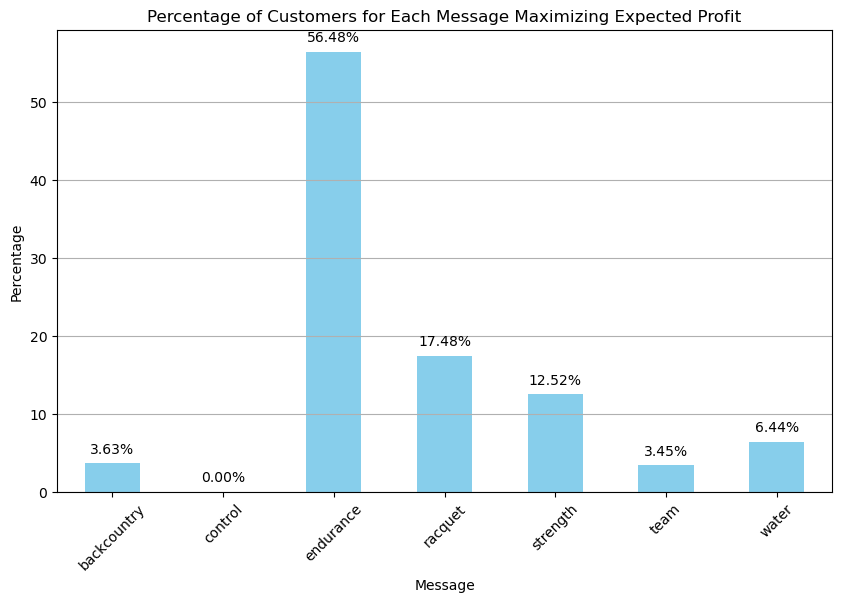

In [112]:
import matplotlib.pyplot as plt

# Plot the message_ep_percentages
ax = message_ep_percentages.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Percentage of Customers for Each Message Maximizing Expected Profit')
plt.xlabel('Message')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Add percentage values on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

This bar chart represents the percentage of customers for whom each promotional email message maximized expected profit.

Majority of customers respond best to Endurance-related promotions while Racquet and Strength collectively account for nearly 30% of customer indicating that they may be niche but are valuable segments. 
While water, backcountry and team contribute to relatively smaller percentages and control is 0% which reinforces the importance of sending targeted emails rather than not engaging customers at all. insert comments

5.  What  expected  profit  can  we  obtain,  on  average,  per  customer  if  we  customize  the 
message to each customer? Include no-message as an option as well. 


In [113]:
# Calculate the average expected profit per customer
average_expected_profit = pentathlon_nptb_log_test['ep_max'].mean()
print(f"Average expected profit per customer: {average_expected_profit:.2f} Euros")

Average expected profit per customer: 0.68 Euros


6.  What is the expected profit per e-mailed customer if every customer receives the same 
message?  Answer  this  question  for  each  of  the  possible  messages  (i.e.,  endurance, 
strength, water, team, backcountry, racquet) and the no-message option. 

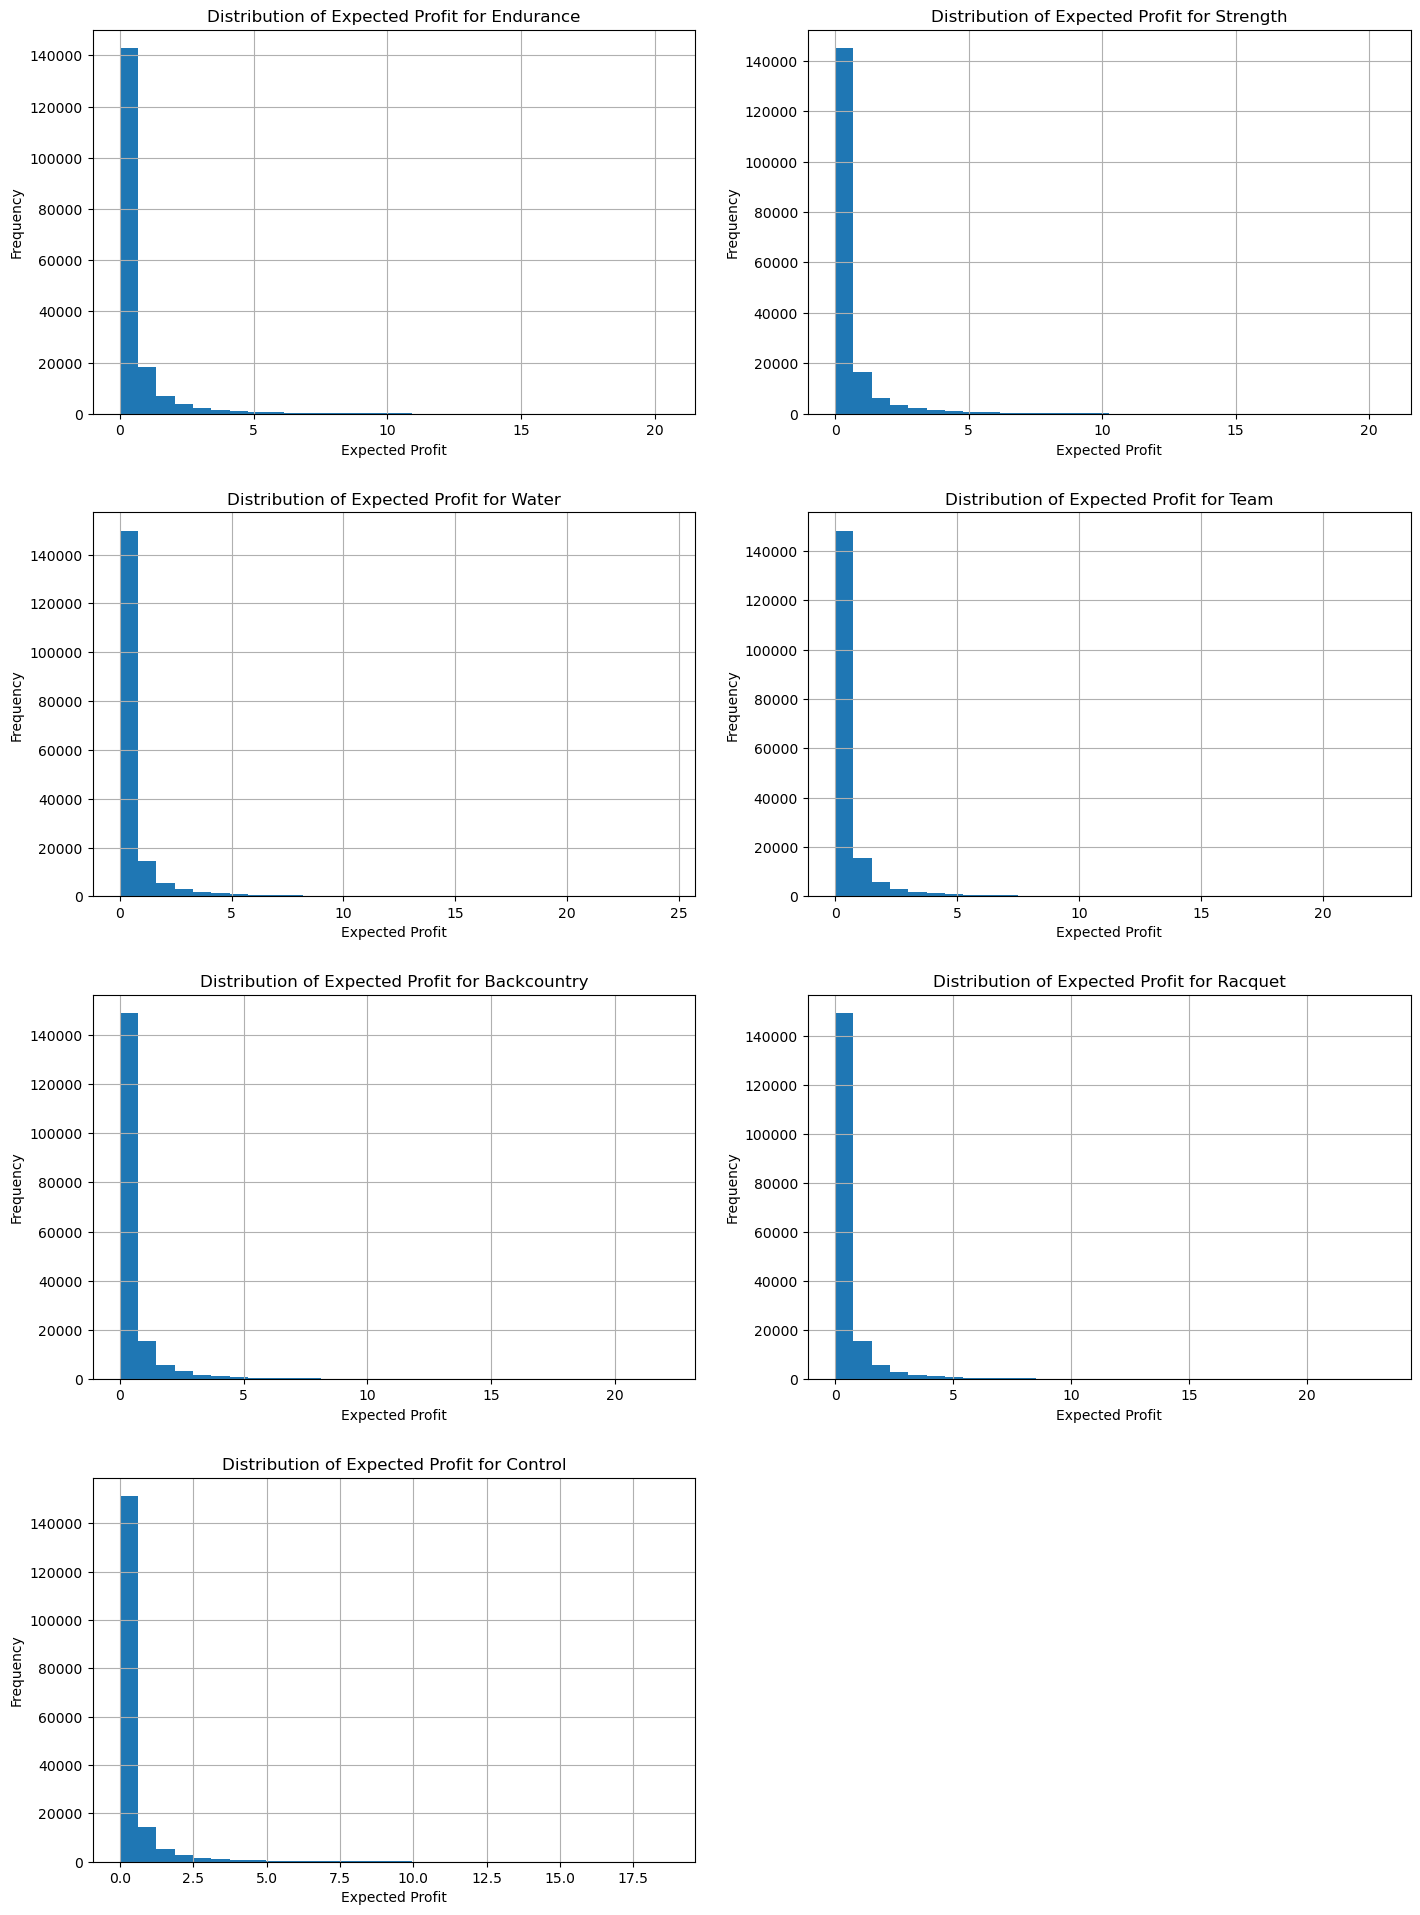

In [114]:
import matplotlib.pyplot as plt

# List of expected profit columns
ep_columns = ['ep_endurance_int', 'ep_strength_int', 'ep_water_int', 'ep_team_int', 'ep_backcountry_int', 'ep_racquet_int', 'ep_control_int']

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
fig.tight_layout(pad=5.0)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each expected profit column
for ax, column in zip(axes, ep_columns):
    pentathlon_nptb_log_test[column].hist(bins=30, ax=ax)
    ax.set_title(f'Distribution of Expected Profit for {column.replace("ep_", "").replace("_int", "").capitalize()}')
    ax.set_xlabel('Expected Profit')
    ax.set_ylabel('Frequency')
    
  
# Remove the last empty subplot
fig.delaxes(axes[-1])

plt.show()

These histograms show the distribution of expected profit per customer for each email message type and a key observation here is that the expected profit for each message type look similar to one another in terms of skew because all messages are right skewed distributions. 

The long right tails indicate that most customers have low profit but a few have high values. Endurance, Strength, Racquet, and Backcountry have more customers with nonzero profits, aligning with earlier findings that these messages perform best.
Water and Team messages have similar distributions but lower high-value outliers, meaning they may not be as effective for maximizing high spenders.

This essentially highlights the importance of targeted messaging, where certain customers should receive specific types of emails rather than a one-size-fits-all approach.

In [115]:
# Calculate the average expected profit for each message type
avg_ep_values = pentathlon_nptb_log_test[['ep_endurance_int', 'ep_strength_int', 'ep_water_int', 'ep_team_int', 'ep_backcountry_int', 'ep_racquet_int', 'ep_control_int']].mean()

# Create a table to compare the values
avg_ep_table = pd.DataFrame(avg_ep_values, columns=['Expected Profit'])
avg_ep_table.index = avg_ep_table.index.str.replace('ep_', '').str.replace('_int', '').str.capitalize()
avg_ep_table

Expected Profit
Endurance           0.597968
Strength            0.576203
Water               0.618317
Team                0.573610
Backcountry         0.544836
Racquet             0.561756
Control             0.425868

We can see from the avg expected profits table above, Water emails generate an average expected profit of €0.618 per customer, making it the most profitable. Compared to the Control group (€0.425), Water emails yield a 45.4% higher profit.This suggests that although Water emails are not the most commonly assigned, they drive high-value purchases.

Endurance (€0.598): The most commonly assigned message ranks 2nd in profit.
Strength (€0.576): Also performs well, trailing Endurance by ~3.7% and Water by ~7%.
Compared to Control, Endurance emails increase profit by 40.7% and Strength by 35.5%


7.  What is the expected profit per e-mailed customer if every customer is assigned randomly 
to one of the messages or the no-message condition?   


In [116]:
message_counts = pentathlon_nptb[pentathlon_nptb.training == 0]['message'].value_counts()
print(message_counts)

message
racquet        26316
backcountry    26179
control        26043
team           25942
water          25496
strength       25251
endurance      24773
Name: count, dtype: int64


In [117]:
# profits based on message col

pentathlon_nptb_log_test['profits'] = pentathlon_nptb_log_test['total_os'] * 0.4
pentathlon_nptb_log_test


/tmp/ipykernel_35906/4275715246.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pentathlon_nptb_log_test['profits'] = pentathlon_nptb_log_test['total_os'] * 0.4


custid buyer  total_os      message       age female     income  \
1             U3    no         0  backcountry  45 to 59     no  10.463132   
4            U25    no         0      racquet     >= 60    yes  11.082158   
6            U30    no         0    endurance      < 30    yes  11.082158   
7            U55    no         0     strength  30 to 44     no  10.463132   
15           U97    no         0    endurance      < 30    yes  11.082158   
...          ...   ...       ...          ...       ...    ...        ...   
599991  U3462852    no         0        water  30 to 44    yes  10.819798   
599994  U3462887    no         0      control      < 30    yes  10.308986   
599996  U3462900    no         0         team      < 30     no  10.915107   
599998  U3462916    no         0         team      < 30     no  10.819798   
599999  U3462922    no         0    endurance  30 to 44    yes  10.819798   

        education  children  freq_endurance  ...  ep_endurance_int  \
1        3.135494  0.693147        0.000000  ...          0.070189   
4        3.496508  0.741937        0.693147  ...          0.600676   
6        4.143135  0.405465        0.693147  ...          1.062559   
7        2.890372  0.741937        0.000000  ...          0.059208   
15       3.713572  0.530628        1.609438  ...          0.866370   
...           ...       ...             ...  ...               ...   
599991   2.995732  0.741937        0.000000  ...          0.179601   
599994   2.708050  0.641854        0.693147  ...          0.011206   
599996   3.496508  0.641854        1.386294  ...          0.205297   
599998   3.583519  0.470004        1.098612  ...          0.178149   
599999   3.258097  0.530628        0.693147  ...          0.285308   

        ep_strength_int  ep_water_int  ep_team_int  ep_backcountry_int  \
1              0.061352      0.059736     0.058017            0.064740   
4              0.344923      0.400598     0.391445            0.396593   
6              1.307919      1.224090     1.101951            1.257773   
7              0.057546      0.044991     0.045269            0.045449   
15             0.812450      0.914270     0.806291            0.822549   
...                 ...           ...          ...                 ...   
599991         0.115834      0.114057     0.113232            0.114028   
599994         0.008694      0.007369     0.008320            0.009500   
599996         0.213593      0.169498     0.229639            0.226923   
599998         0.190426      0.152645     0.202429            0.202934   
599999         0.206364      0.204314     0.214114            0.190347   

        ep_racquet_int  ep_control_int     msg_ep    ep_max  profits  
1             0.070653        0.042537    racquet  0.070653      0.0  
4             0.425999        0.310157  endurance  0.600676      0.0  
6             1.000437        0.893845   strength  1.307919      0.0  
7             0.056119        0.036416  endurance  0.059208      0.0  
15            0.777451        0.662731      water  0.914270      0.0  
...                ...             ...        ...       ...      ...  
599991        0.124008        0.101990  endurance  0.179601      0.0  
599994        0.009978        0.007162  endurance  0.011206      0.0  
599996        0.242188        0.167293    racquet  0.242188      0.0  
599998        0.210562        0.154996    racquet  0.210562      0.0  
599999        0.201992        0.187999  endurance  0.285308      0.0  

[180000 rows x 46 columns]

In [118]:
print("The average profit per customer when randomly assigned to message types is:  ", pentathlon_nptb_log_test['profits'].mean(),' Euros')

The average profit per customer when randomly assigned to message types is:   0.5518799999999999  Euros


8.  For the typical promotional e-mail blast to 5,000,000 customers, what improvement (in 
percent and in total Euros) could Pentathlon achieve by customizing the message (or no-
message) to each customer. Compare the performance predictions from this personalized 
approach to scenarios where (1) each customer is sent the same message selected based 
on average performance, (2) a random message assignment approach is used (i.e., the 
status quo), and (3) no message is sent (i.e., the control condition)? 

In [119]:
avg_profits_msg = pentathlon_nptb_log_test[['ep_endurance_int', 'ep_strength_int', 'ep_water_int', 'ep_team_int', 'ep_backcountry_int', 'ep_racquet_int']].mean()
avg_profits_msg

ep_endurance_int      0.597968
ep_strength_int       0.576203
ep_water_int          0.618317
ep_team_int           0.573610
ep_backcountry_int    0.544836
ep_racquet_int        0.561756
dtype: float64

In [120]:
n = 5_000_000
extrpolated_p = pentathlon_nptb_log_test['ep_max'].mean() * n #best scenario from targeting
extrpolated_p

3394907.779048057

In [121]:
n = 5_000_000

avg_profits_max = avg_profits_msg.max()
e_profits1 = avg_profits_max * n

print("Extrapolated profits based on each customer if sent the same message selected based on average performance: ", e_profits1)
print("Improvement in profits (in Euros) if each customer is sent a personalized msg vs the same msg selected based on average performance: ",  extrpolated_p - e_profits1, "Euros")
print("Improvement in profits (in %) if each customer is sent a personalized msg vs the same msg selected based on average performance:  ",  (extrpolated_p - e_profits1) / e_profits1 * 100, "%")



Extrapolated profits based on each customer if sent the same message selected based on average performance:  3091584.865168047
Improvement in profits (in Euros) if each customer is sent a personalized msg vs the same msg selected based on average performance:  303322.91388000967 Euros
Improvement in profits (in %) if each customer is sent a personalized msg vs the same msg selected based on average performance:   9.811243330159146 %


In [122]:

#2
extrpolated_profit_random = pentathlon_nptb_log_test['profits'].mean() * n # profits extrapolated based on random assignment

print("Profit improvement (in %) by using the best message as compared to random messaging: ", (extrpolated_p - extrpolated_profit_random)/extrpolated_profit_random * 100, "%")
print("Profit improvement (in Euros) by using the best message as compared to random messaging: ", extrpolated_p - extrpolated_profit_random, "Euros")


Profit improvement (in %) by using the best message as compared to random messaging:  23.030650831632144 %
Profit improvement (in Euros) by using the best message as compared to random messaging:  635507.7790480573 Euros


In [123]:
#3
avg_e_profit_control = pentathlon_nptb_log_test['ep_control_int'].mean()
extrapolated_control_profit = avg_e_profit_control * n
print("Extrapolated profit by best message: ", extrpolated_p)
print("Extrapolated profits based on control message: ", extrapolated_control_profit)
print("Profit improvement (in Euros) by using the best message as compared to control message: ", extrpolated_p - extrapolated_control_profit, "Euros")
print("Profit improvement (in %) by using the best message as compared to control message: ", (extrpolated_p - extrapolated_control_profit) / extrapolated_control_profit * 100, "%")

Extrapolated profit by best message:  3394907.779048057
Extrapolated profits based on control message:  2129337.936043835
Profit improvement (in Euros) by using the best message as compared to control message:  1265569.843004222 Euros
Profit improvement (in %) by using the best message as compared to control message:  59.43489859367108 %


From the above calculations we can infer that, personalized targeting outperforms sending the same message that gives the best performance across the entire population. Personalized targeting significantly outperforms random email allocation. Random assignment is inefficient—personalization leads to significant revenue gains. Not sending emails is the worst strategy. Even a basic targeting approach vastly outperforms doing nothing.

#### Neural Network Model

In [124]:
#Scale data

pentathlon_nptb_scaled = pentathlon_nptb.copy()
pentathlon_nptb_scaled = rsm.scale_df(pentathlon_nptb_scaled, sf=1)
pentathlon_nptb_scaled

custid buyer  total_os      message       age female    income  \
0             U1    no -0.105526         team  30 to 44     no  0.388615   
1             U3    no -0.105526  backcountry  45 to 59     no -0.756221   
2            U13    no -0.105526    endurance  45 to 59    yes -0.183803   
3            U20    no -0.105526        water  45 to 59    yes -1.328639   
4            U25    no -0.105526      racquet     >= 60    yes  0.961033   
...          ...   ...       ...          ...       ...    ...       ...   
599995  U3462888    no -0.105526        water     >= 60    yes -0.470012   
599996  U3462900    no -0.105526         team      < 30     no  0.388615   
599997  U3462902    no -0.105526         team      < 30    yes  0.388615   
599998  U3462916    no -0.105526         team      < 30     no  0.102406   
599999  U3462922    no -0.105526    endurance  30 to 44    yes  0.102406   

        education  children  freq_endurance  freq_strength  freq_water  \
0       -0.664869 -0.264323       -0.639889       1.101113   -0.261529   
1       -0.462915  0.164886       -0.639889      -0.706772   -0.261529   
2        0.277582 -0.478928       -0.639889      -0.706772   -0.261529   
3       -0.328279 -1.551951       -0.639889      -0.706772   -0.261529   
4        0.210264  0.379491        0.060737       0.197170   -0.261529   
...           ...       ...             ...            ...         ...   
599995  -0.193643 -0.693532       -0.639889      -0.706772   -0.261529   
599996   0.210264 -0.049719        1.461990      -0.254801   -0.261529   
599997   0.210264 -0.049719       -0.639889       1.553084   -0.261529   
599998   0.412217 -0.693532        0.761364       0.197170   -0.261529   
599999  -0.260961 -0.478928        0.060737       0.197170   -0.261529   

        freq_team  freq_backcountry  freq_racquet  training  total_freq  
0        1.891791         -0.690183      0.058205       1.0    0.810001  
1        0.007882         -0.690183     -0.764272       0.0   -0.820409  
2       -0.620088          1.956790      0.880683       1.0   -0.209005  
3       -0.620088         -0.690183     -0.764272       1.0   -1.024210  
4       -0.620088          1.956790      0.880683       0.0    0.402398  
...           ...               ...           ...       ...         ...  
599995  -0.620088         -0.690183     -0.764272       1.0   -1.024210  
599996  -0.620088         -0.690183      0.058205       0.0   -0.005204  
599997   0.635852          0.633304      0.880683       1.0    1.013802  
599998  -0.620088         -0.690183      0.058205       0.0   -0.005204  
599999  -0.620088         -0.690183      0.880683       0.0   -0.005204  

[600000 rows x 17 columns]

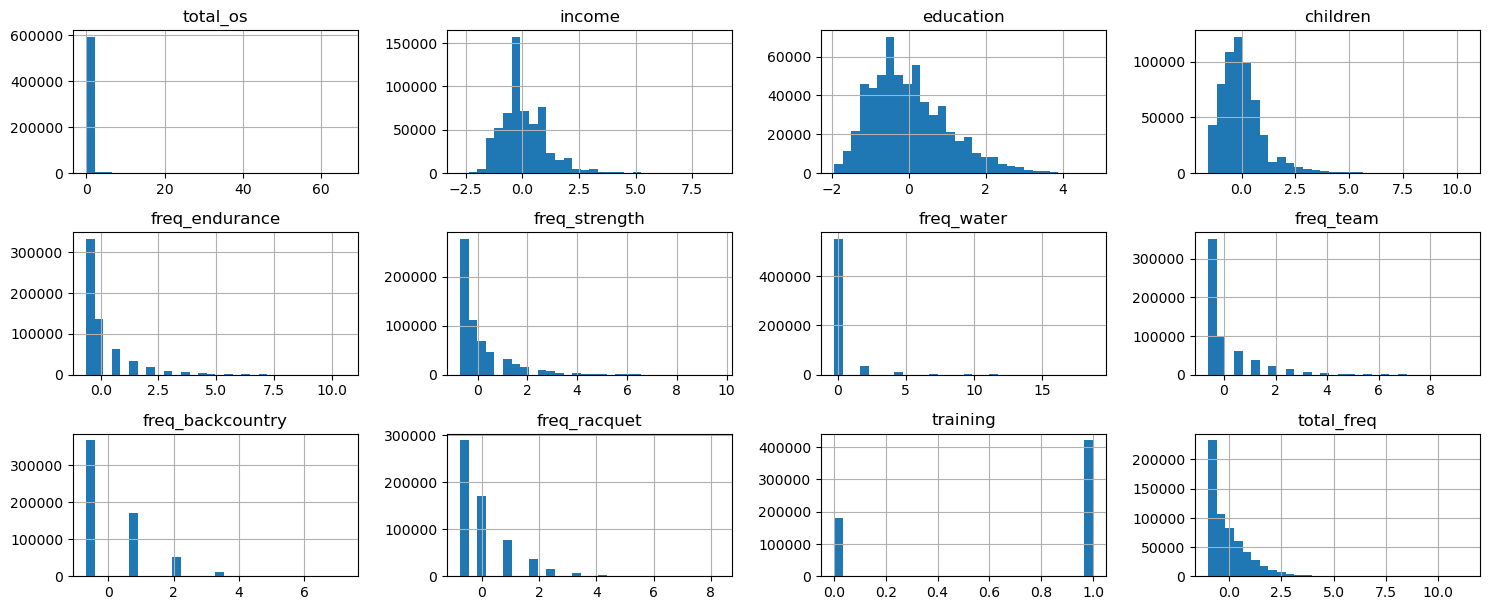

In [125]:
import matplotlib.pyplot as plt

# Plot histograms for each numeric variable in pentathlon_nptb_scaled
pentathlon_nptb_scaled.hist(bins=30, figsize=(15, 10), layout=(5, 4))
plt.tight_layout()
plt.show()

In [126]:
pentathlon_nptb_scaled.columns

Index(['custid', 'buyer', 'total_os', 'message', 'age', 'female', 'income',
       'education', 'children', 'freq_endurance', 'freq_strength',
       'freq_water', 'freq_team', 'freq_backcountry', 'freq_racquet',
       'training', 'total_freq'],
      dtype='object')

In [127]:
# Convert 'female' column to binary variable
pentathlon_nptb_scaled['female'] = pentathlon_nptb_scaled['female'].apply(lambda x: 1 if x == 'yes' else 0)

# One hot encode 'age' column
pentathlon_nptb_scaled = pd.get_dummies(pentathlon_nptb_scaled, columns=['age','message'], drop_first=True)

# Display the updated dataframe
pentathlon_nptb_scaled.head()

custid buyer  total_os female    income  education  children  \
0     U1    no -0.105526      0  0.388615  -0.664869 -0.264323   
1     U3    no -0.105526      0 -0.756221  -0.462915  0.164886   
2    U13    no -0.105526      1 -0.183803   0.277582 -0.478928   
3    U20    no -0.105526      1 -1.328639  -0.328279 -1.551951   
4    U25    no -0.105526      1  0.961033   0.210264  0.379491   

   freq_endurance  freq_strength  freq_water  ...  total_freq  age_30 to 44  \
0       -0.639889       1.101113   -0.261529  ...    0.810001          True   
1       -0.639889      -0.706772   -0.261529  ...   -0.820409         False   
2       -0.639889      -0.706772   -0.261529  ...   -0.209005         False   
3       -0.639889      -0.706772   -0.261529  ...   -1.024210         False   
4        0.060737       0.197170   -0.261529  ...    0.402398         False   

   age_45 to 59  age_>= 60  message_control  message_endurance  \
0         False      False            False              False   
1          True      False            False              False   
2          True      False            False               True   
3          True      False            False              False   
4         False       True            False              False   

   message_racquet  message_strength  message_team  message_water  
0            False             False          True          False  
1            False             False         False          False  
2            False             False         False          False  
3            False             False         False           True  
4             True             False         False          False  

[5 rows x 24 columns]

In [128]:
pentathlon_nptb_scaled.columns

Index(['custid', 'buyer', 'total_os', 'female', 'income', 'education',
       'children', 'freq_endurance', 'freq_strength', 'freq_water',
       'freq_team', 'freq_backcountry', 'freq_racquet', 'training',
       'total_freq', 'age_30 to 44', 'age_45 to 59', 'age_>= 60',
       'message_control', 'message_endurance', 'message_racquet',
       'message_strength', 'message_team', 'message_water'],
      dtype='object')

In [129]:
# Convert all age and message columns to binary
age_columns = ['age_30 to 44', 'age_45 to 59', 'age_>= 60']
message_columns = ['message_control', 'message_endurance', 'message_racquet', 'message_strength', 'message_team', 'message_water']

for col in age_columns + message_columns:
    pentathlon_nptb_scaled[col] = pentathlon_nptb_scaled[col].astype(int)

pentathlon_nptb_scaled


custid buyer  total_os female    income  education  children  \
0             U1    no -0.105526      0  0.388615  -0.664869 -0.264323   
1             U3    no -0.105526      0 -0.756221  -0.462915  0.164886   
2            U13    no -0.105526      1 -0.183803   0.277582 -0.478928   
3            U20    no -0.105526      1 -1.328639  -0.328279 -1.551951   
4            U25    no -0.105526      1  0.961033   0.210264  0.379491   
...          ...   ...       ...    ...       ...        ...       ...   
599995  U3462888    no -0.105526      1 -0.470012  -0.193643 -0.693532   
599996  U3462900    no -0.105526      0  0.388615   0.210264 -0.049719   
599997  U3462902    no -0.105526      1  0.388615   0.210264 -0.049719   
599998  U3462916    no -0.105526      0  0.102406   0.412217 -0.693532   
599999  U3462922    no -0.105526      1  0.102406  -0.260961 -0.478928   

        freq_endurance  freq_strength  freq_water  ...  total_freq  \
0            -0.639889       1.101113   -0.261529  ...    0.810001   
1            -0.639889      -0.706772   -0.261529  ...   -0.820409   
2            -0.639889      -0.706772   -0.261529  ...   -0.209005   
3            -0.639889      -0.706772   -0.261529  ...   -1.024210   
4             0.060737       0.197170   -0.261529  ...    0.402398   
...                ...            ...         ...  ...         ...   
599995       -0.639889      -0.706772   -0.261529  ...   -1.024210   
599996        1.461990      -0.254801   -0.261529  ...   -0.005204   
599997       -0.639889       1.553084   -0.261529  ...    1.013802   
599998        0.761364       0.197170   -0.261529  ...   -0.005204   
599999        0.060737       0.197170   -0.261529  ...   -0.005204   

        age_30 to 44  age_45 to 59  age_>= 60  message_control  \
0                  1             0          0                0   
1                  0             1          0                0   
2                  0             1          0                0   
3                  0             1          0                0   
4                  0             0          1                0   
...              ...           ...        ...              ...   
599995             0             0          1                0   
599996             0             0          0                0   
599997             0             0          0                0   
599998             0             0          0                0   
599999             1             0          0                0   

        message_endurance  message_racquet  message_strength  message_team  \
0                       0                0                 0             1   
1                       0                0                 0             0   
2                       1                0                 0             0   
3                       0                0                 0             0   
4                       0                1                 0             0   
...                   ...              ...               ...           ...   
599995                  0                0                 0             0   
599996                  0                0                 0             1   
599997                  0                0                 0             1   
599998                  0                0                 0             1   
599999                  1                0                 0             0   

        message_water  
0                   0  
1                   0  
2                   0  
3                   1  
4                   0  
...               ...  
599995              1  
599996              0  
599997              0  
599998              0  
599999              0  

[600000 rows x 24 columns]

1. For  each  customer  determine  the  message  (i.e.,  endurance,  strength,  water,  team, 
backcountry,  racquet,  or  no-message)  predicted  to  lead  to  the  highest  probability  of 
purchase. 

In [130]:
pentathlon_nptb_scaled.columns

Index(['custid', 'buyer', 'total_os', 'female', 'income', 'education',
       'children', 'freq_endurance', 'freq_strength', 'freq_water',
       'freq_team', 'freq_backcountry', 'freq_racquet', 'training',
       'total_freq', 'age_30 to 44', 'age_45 to 59', 'age_>= 60',
       'message_control', 'message_endurance', 'message_racquet',
       'message_strength', 'message_team', 'message_water'],
      dtype='object')

In [131]:
evar_nn = ['income', 'education', 'children', 'female',
            'freq_endurance', 'freq_strength', 'freq_water', 'freq_team', 'freq_backcountry',
            'freq_racquet', 'age_30 to 44', 'age_45 to 59', 'age_>= 60',
            'message_control', 'message_endurance', 'message_racquet', 'message_strength', 'message_team',
            'message_water']

In [132]:
import math

sqrt_len_evar_nn = math.sqrt(len(evar_nn))
print(sqrt_len_evar_nn)

4.358898943540674


In [133]:
nn0 = rsm.mlp({
    "p_nptb_scaled": pentathlon_nptb_scaled.query("training == 1")}, 
    rvar="buyer",
    lev="yes",
    evar= evar_nn,
    hidden_layer_sizes=(1,),
    mod_type="classification",
)
nn0.summary()

Multi-layer Perceptron (NN)
Data                 : p_nptb_scaled
Response variable    : buyer
Level                : yes
Explanatory variables: income, education, children, female, freq_endurance, freq_strength, freq_water, freq_team, freq_backcountry, freq_racquet, age_30 to 44, age_45 to 59, age_>= 60, message_control, message_endurance, message_racquet, message_strength, message_team, message_water
Model type           : classification
Nr. of features      : (19, 19)
Nr. of weights       : 22
Nr. of observations  : 420,000
Hidden_layer_sizes   : (1,)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.0001
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 1000000
random_state         : 1234
AUC                  : 0.884

Raw data             :
   income  education  children female  freq_endurance  freq_strength  freq_water  freq_team  freq_backcountry  freq_racquet  age_30 to 44  age_45 to 59  age_>= 60  message_control  mes

In [134]:
import numpy as np
hls = [(1,), (2,), (2, 1), (2, 2), (3,), (3, 1), (3, 2), (2,3), (3, 3), (2, 5)]
param_grid = {
    'hidden_layer_sizes': hls,
    'alpha': [0.0001, 0.001, 0.01, 0.1]
}
param_grid

{'hidden_layer_sizes': [(1,),
  (2,),
  (2, 1),
  (2, 2),
  (3,),
  (3, 1),
  (3, 2),
  (2, 3),
  (3, 3),
  (2, 5)],
 'alpha': [0.0001, 0.001, 0.01, 0.1]}

In [135]:
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

if os.path.exists('cv-objects/cross-validation-object_nn0.pkl'):
    cvnn=rsm.load_state('cv-objects/cross-validation-object_nn0.pkl')["cv"]
else:
    stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
    cvnn=GridSearchCV(nn0.fitted, param_grid, scoring = {"AUC": "roc_auc"}, cv=stratified_k_fold, n_jobs=5,refit="AUC", verbose=5).fit(nn0.data_onehot, nn0.data.buyer)
    if not os.path.exists('cv-objects'):
        os.mkdir('cv-objects')
    rsm.save_state({"cv": cvnn},'cv-objects/cross-validation-object_nn0.pkl')

In [136]:
nn_pred = rsm.mlp(
    {"p_nptb_scaled": pentathlon_nptb_scaled.query("training == 1")}, 
    rvar="buyer",
    lev="yes",
    evar= evar_nn,
    mod_type="classification",
    random_state=1234,
    **cvnn.best_params_,
)
nn_pred.summary()

Multi-layer Perceptron (NN)
Data                 : p_nptb_scaled
Response variable    : buyer
Level                : yes
Explanatory variables: income, education, children, female, freq_endurance, freq_strength, freq_water, freq_team, freq_backcountry, freq_racquet, age_30 to 44, age_45 to 59, age_>= 60, message_control, message_endurance, message_racquet, message_strength, message_team, message_water
Model type           : classification
Nr. of features      : (19, 19)
Nr. of weights       : 76
Nr. of observations  : 420,000
Hidden_layer_sizes   : (3, 3)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.1
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 1000000
random_state         : 1234
AUC                  : 0.891

Raw data             :
   income  education  children female  freq_endurance  freq_strength  freq_water  freq_team  freq_backcountry  freq_racquet  age_30 to 44  age_45 to 59  age_>= 60  message_control  mess

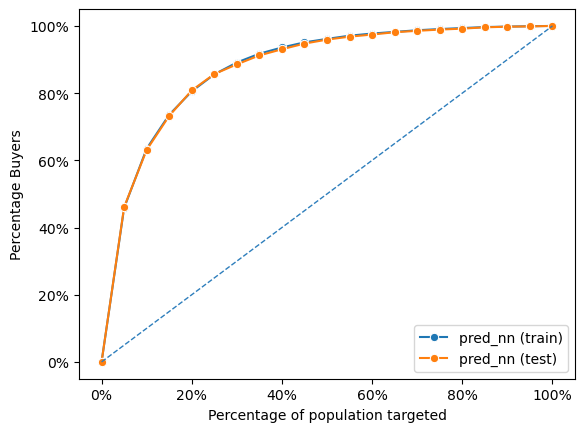

In [137]:
pentathlon_nptb_scaled['pred_nn'] = nn_pred.predict(pentathlon_nptb_scaled)['prediction']
dct_clf_nn = {"train": pentathlon_nptb_scaled.query("training == 1"), "test": pentathlon_nptb_scaled.query("training == 0")}
fig_clf_nn = rsm.gains_plot(dct_clf_nn, "buyer", "yes", "pred_nn", qnt=20)

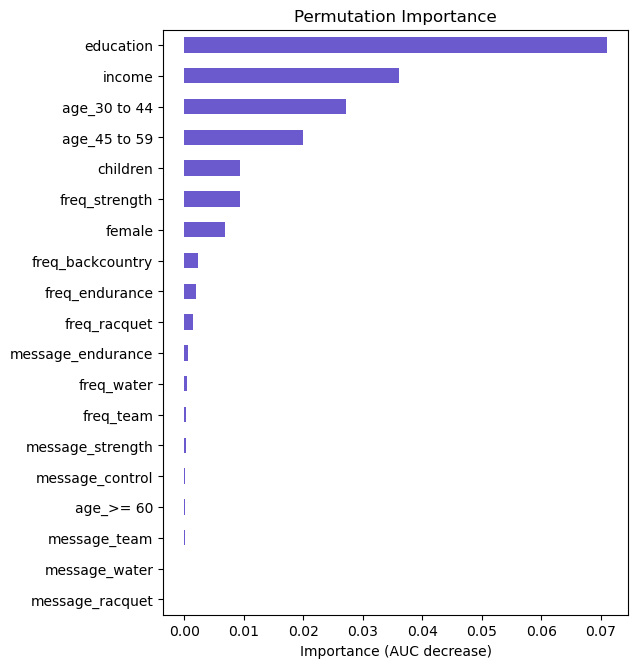

In [138]:
nn_pred.plot("vimp")

Education customers from areas with higher levels of education may be more predictable in their purchasing behavior or have distinct spending patterns, education is the most important feature, keeping all else constant. 

Income being the second most important feature, when all other features are kept constant, suggests that higher income levels could be associated with larger order sizes and higher spending across categories.
This aligns with general business insights where disposable income is a strong predictor of purchasing behavior.

Age Groups (30-44, 45-59) are key drivers - these age groups significantly impact predictions, meaning middle-aged customers exhibit clear purchase patterns.

Features like gender and children have moderate impact on the model, when other features are kept constant. This may be attributed to the fact that households with children exhibit different spending behaviours and gender could indicate differing interests in products. 

Overall, this implies that general customer demographic matters more. 

In [139]:
pentathlon_nptb_scaled_test = pentathlon_nptb_scaled[pentathlon_nptb_scaled['training'] == 0]

In [140]:
pentathlon_nptb_scaled_test.loc[:, 'p_endurance_nn'] = nn_pred.predict(pentathlon_nptb_scaled_test, data_cmd={"message_endurance": 1})["prediction"]
pentathlon_nptb_scaled_test.loc[:, 'p_strength_nn'] = nn_pred.predict(pentathlon_nptb_scaled_test, data_cmd={"message_strength": 1})["prediction"]
pentathlon_nptb_scaled_test.loc[:, 'p_water_nn'] = nn_pred.predict(pentathlon_nptb_scaled_test, data_cmd={"message_water": 1})["prediction"]
pentathlon_nptb_scaled_test.loc[:, 'p_team_nn'] = nn_pred.predict(pentathlon_nptb_scaled_test, data_cmd={"message_team": 1})["prediction"]
pentathlon_nptb_scaled_test.loc[:, 'p_backcountry_nn'] = nn_pred.predict(pentathlon_nptb_scaled_test, data_cmd={"message_backcountry": 1})["prediction"]
pentathlon_nptb_scaled_test.loc[:, 'p_racquet_nn'] = nn_pred.predict(pentathlon_nptb_scaled_test, data_cmd={"message_racquet": 1})["prediction"]
pentathlon_nptb_scaled_test.loc[:, 'p_control_nn'] = nn_pred.predict(pentathlon_nptb_scaled_test, data_cmd={"message_control": 1})["prediction"]

pentathlon_nptb_scaled_test


/tmp/ipykernel_35906/3370400935.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pentathlon_nptb_scaled_test.loc[:, 'p_endurance_nn'] = nn_pred.predict(pentathlon_nptb_scaled_test, data_cmd={"message_endurance": 1})["prediction"]
/tmp/ipykernel_35906/3370400935.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pentathlon_nptb_scaled_test.loc[:, 'p_strength_nn'] = nn_pred.predict(pentathlon_nptb_scaled_test, data_cmd={"message_strength": 1})["prediction"]
/tmp/ipykernel_35906/3370400935.py:3: SettingWit

custid buyer  total_os female    income  education  children  \
1             U3    no -0.105526      0 -0.756221  -0.462915  0.164886   
4            U25    no -0.105526      1  0.961033   0.210264  0.379491   
6            U30    no -0.105526      1  0.961033   2.229800 -0.908137   
7            U55    no -0.105526      0 -0.756221  -0.799504  0.379491   
15           U97    no -0.105526      1  0.961033   0.748807 -0.478928   
...          ...   ...       ...    ...       ...        ...       ...   
599991  U3462852    no -0.105526      1  0.102406  -0.664869  0.379491   
599994  U3462887    no -0.105526      1 -1.042430  -1.001458 -0.049719   
599996  U3462900    no -0.105526      0  0.388615   0.210264 -0.049719   
599998  U3462916    no -0.105526      0  0.102406   0.412217 -0.693532   
599999  U3462922    no -0.105526      1  0.102406  -0.260961 -0.478928   

        freq_endurance  freq_strength  freq_water  ...  message_team  \
1            -0.639889      -0.706772   -0.261529  ...             0   
4             0.060737       0.197170   -0.261529  ...             0   
6             0.060737       1.553084   -0.261529  ...             0   
7            -0.639889      -0.706772   -0.261529  ...             0   
15            2.162617       2.005055    2.109507  ...             0   
...                ...            ...         ...  ...           ...   
599991       -0.639889      -0.254801   -0.261529  ...             0   
599994        0.060737      -0.706772   -0.261529  ...             0   
599996        1.461990      -0.254801   -0.261529  ...             1   
599998        0.761364       0.197170   -0.261529  ...             1   
599999        0.060737       0.197170   -0.261529  ...             0   

        message_water   pred_nn  p_endurance_nn  p_strength_nn  p_water_nn  \
1                   0  0.001721        0.001551       0.001853    0.001593   
4                   0  0.006985        0.005487       0.007557    0.007455   
6                   0  0.057356        0.057356       0.064943    0.062730   
7                   0  0.001617        0.001382       0.001617    0.001499   
15                  0  0.005929        0.005929       0.006558    0.006387   
...               ...       ...             ...            ...         ...   
599991              1  0.002737        0.002303       0.002966    0.002737   
599994              0  0.005073        0.006211       0.005308    0.004944   
599996              0  0.004860        0.004009       0.005290    0.004817   
599998              0  0.003620        0.002920       0.003880    0.003655   
599999              0  0.003299        0.003299       0.003542    0.003312   

        p_team_nn  p_backcountry_nn  p_racquet_nn  p_control_nn  
1        0.001805          0.001721      0.001635      0.001511  
4        0.008137          0.006985      0.006985      0.006978  
6        0.062946          0.057356      0.060530      0.054679  
7        0.001737          0.001617      0.001568      0.001441  
15       0.006653          0.005929      0.006393      0.005818  
...           ...               ...           ...           ...  
599991   0.002981          0.002737      0.002667      0.002415  
599994   0.004652          0.005073      0.004596      0.005073  
599996   0.004860          0.004860      0.004984      0.004496  
599998   0.003620          0.003620      0.003837      0.003478  
599999   0.003779          0.003299      0.003495      0.003158  

[180000 rows x 32 columns]

In [141]:
#find best message for each customer

pentathlon_nptb_scaled_test['best_message_nn'] = pentathlon_nptb_scaled_test[['p_endurance_nn', 'p_strength_nn', 'p_water_nn', 'p_team_nn', 'p_backcountry_nn', 'p_racquet_nn', 'p_control_nn']].idxmax(axis=1).str.replace('p_', '').str.replace('_nn', '')
pentathlon_nptb_scaled_test

/tmp/ipykernel_35906/3189279952.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pentathlon_nptb_scaled_test['best_message_nn'] = pentathlon_nptb_scaled_test[['p_endurance_nn', 'p_strength_nn', 'p_water_nn', 'p_team_nn', 'p_backcountry_nn', 'p_racquet_nn', 'p_control_nn']].idxmax(axis=1).str.replace('p_', '').str.replace('_nn', '')


custid buyer  total_os female    income  education  children  \
1             U3    no -0.105526      0 -0.756221  -0.462915  0.164886   
4            U25    no -0.105526      1  0.961033   0.210264  0.379491   
6            U30    no -0.105526      1  0.961033   2.229800 -0.908137   
7            U55    no -0.105526      0 -0.756221  -0.799504  0.379491   
15           U97    no -0.105526      1  0.961033   0.748807 -0.478928   
...          ...   ...       ...    ...       ...        ...       ...   
599991  U3462852    no -0.105526      1  0.102406  -0.664869  0.379491   
599994  U3462887    no -0.105526      1 -1.042430  -1.001458 -0.049719   
599996  U3462900    no -0.105526      0  0.388615   0.210264 -0.049719   
599998  U3462916    no -0.105526      0  0.102406   0.412217 -0.693532   
599999  U3462922    no -0.105526      1  0.102406  -0.260961 -0.478928   

        freq_endurance  freq_strength  freq_water  ...  message_water  \
1            -0.639889      -0.706772   -0.261529  ...              0   
4             0.060737       0.197170   -0.261529  ...              0   
6             0.060737       1.553084   -0.261529  ...              0   
7            -0.639889      -0.706772   -0.261529  ...              0   
15            2.162617       2.005055    2.109507  ...              0   
...                ...            ...         ...  ...            ...   
599991       -0.639889      -0.254801   -0.261529  ...              1   
599994        0.060737      -0.706772   -0.261529  ...              0   
599996        1.461990      -0.254801   -0.261529  ...              0   
599998        0.761364       0.197170   -0.261529  ...              0   
599999        0.060737       0.197170   -0.261529  ...              0   

         pred_nn  p_endurance_nn  p_strength_nn  p_water_nn  p_team_nn  \
1       0.001721        0.001551       0.001853    0.001593   0.001805   
4       0.006985        0.005487       0.007557    0.007455   0.008137   
6       0.057356        0.057356       0.064943    0.062730   0.062946   
7       0.001617        0.001382       0.001617    0.001499   0.001737   
15      0.005929        0.005929       0.006558    0.006387   0.006653   
...          ...             ...            ...         ...        ...   
599991  0.002737        0.002303       0.002966    0.002737   0.002981   
599994  0.005073        0.006211       0.005308    0.004944   0.004652   
599996  0.004860        0.004009       0.005290    0.004817   0.004860   
599998  0.003620        0.002920       0.003880    0.003655   0.003620   
599999  0.003299        0.003299       0.003542    0.003312   0.003779   

        p_backcountry_nn  p_racquet_nn  p_control_nn  best_message_nn  
1               0.001721      0.001635      0.001511         strength  
4               0.006985      0.006985      0.006978             team  
6               0.057356      0.060530      0.054679         strength  
7               0.001617      0.001568      0.001441             team  
15              0.005929      0.006393      0.005818             team  
...                  ...           ...           ...              ...  
599991          0.002737      0.002667      0.002415             team  
599994          0.005073      0.004596      0.005073        endurance  
599996          0.004860      0.004984      0.004496         strength  
599998          0.003620      0.003837      0.003478         strength  
599999          0.003299      0.003495      0.003158             team  

[180000 rows x 33 columns]

In [142]:
pd.crosstab(index=pentathlon_nptb_scaled_test[pentathlon_nptb_scaled_test.training == 0].best_message_nn, columns="count").apply(rsm.format_nr)
pd.crosstab(index=pentathlon_nptb_scaled_test[pentathlon_nptb_scaled_test.training == 0].best_message_nn, columns="count").reindex(['backcountry', 'control', 'endurance', 'racquet', 'strength', 'team', 'water'], fill_value=0).apply(rsm.format_nr)


col_0             count
best_message_nn        
backcountry           0
control               0
endurance        81,605
racquet             934
strength         54,879
team             42,271
water               311

From the above table we see that Endurance-focused promotions should be prioritized, followed by strength and team-related messaging.
Organic (control group) purchases are minimal, reinforcing the need for well-structured promotions.


2.  For each message, report the percentage of customers for whom that message or no-
message  maximizes  their  probability  of  purchase.  Comment  on  the  distribution  of 
expected response across messages

In [143]:
# Ensure all message types are included, even if their count is 0
all_messages = ['endurance', 'team', 'strength', 'water', 'backcountry', 'racquet', 'control']

percentages_msg_nn = pentathlon_nptb_scaled_test['best_message_nn'].value_counts(normalize=True).reindex(all_messages, fill_value=0) * 100
percentages_msg_nn

best_message_nn
endurance      45.336111
team           23.483889
strength       30.488333
water           0.172778
backcountry     0.000000
racquet         0.518889
control         0.000000
Name: proportion, dtype: float64

From the table above, endurance,  is the optimal message for 45.3% of customers—making it the most impactful. Strength (30.5%) and team (23.5%) also hold substantial shares but trail behind endurance.

Racquet (0.52%), water (0.17%), and backcountry (0%) have minimal reach, indicating that they resonate with only very niche segments. The control group (0%) suggests that sending any promotional message is more effective than no outreach at all

3.  For  each  customer,  determine  the  message  (i.e.,  endurance,  strength,  water,  team, 
backcountry, racquet, or no-message) predicted to lead to the highest expected profit 
(COGS is 60%).

Order size predicition approach

We will predict the ordersize utilizing a neural network model utilizing training data consisting only of BUYERS 
We will assess the model using MAE, MSE, R^2 and other regression model neural network diagnostics


In [144]:
pentathlon_nptb_scaled_buyer = pentathlon_nptb_scaled[pentathlon_nptb_scaled['buyer'] == 'yes']

In [145]:
nn0os = rsm.mlp({
    "p_nptb_scaled_buyer_yes": pentathlon_nptb_scaled_buyer.query("training == 1")}, 
    rvar="total_os",
    evar= evar_nn,
    hidden_layer_sizes=(1,),
    mod_type= 'regression',
    alpha=0.01,
)
nn0os.summary()

Multi-layer Perceptron (NN)
Data                 : p_nptb_scaled_buyer_yes
Response variable    : total_os
Explanatory variables: income, education, children, female, freq_endurance, freq_strength, freq_water, freq_team, freq_backcountry, freq_racquet, age_30 to 44, age_45 to 59, age_>= 60, message_control, message_endurance, message_racquet, message_strength, message_team, message_water
Model type           : regression
Nr. of features      : (19, 19)
Nr. of weights       : 22
Nr. of observations  : 10,080
Hidden_layer_sizes   : (1,)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.01
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 1000000
random_state         : 1234
Model fit            :
      n    r2   mse    mae
  10080  0.08  0.92  0.605

Raw data             :
  income  education  children female  freq_endurance  freq_strength  freq_water  freq_team  freq_backcountry  freq_racquet  age_30 to 44  age_45 to 59  age_>

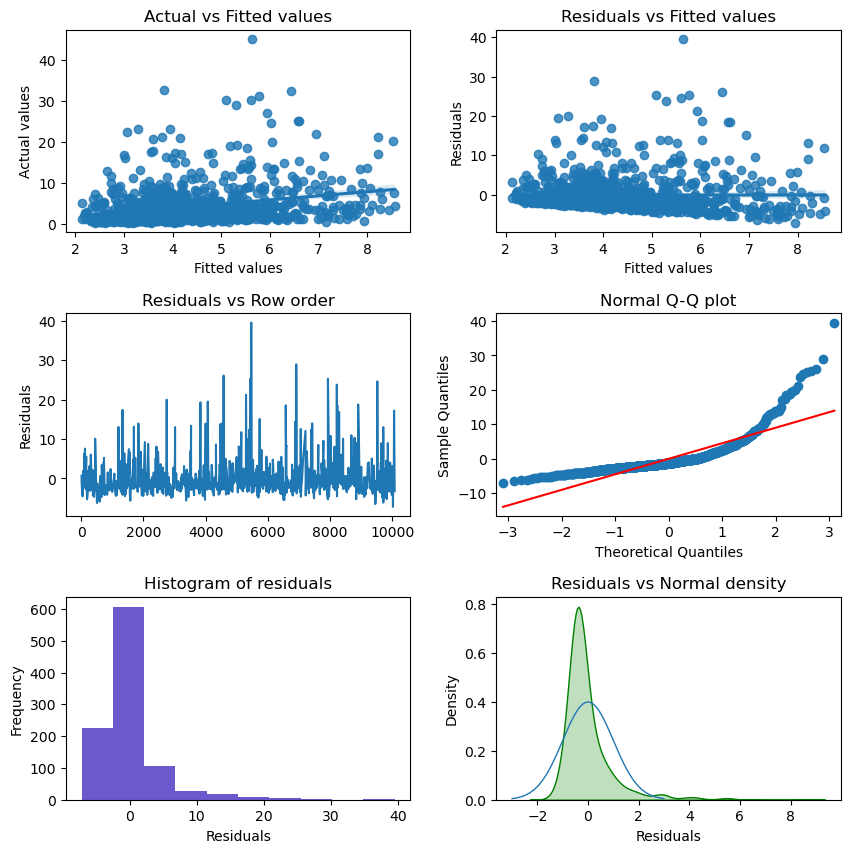

In [146]:
nn0os.plot('dashboard')

The following key metrics:

R² = 0.08 (8% of variance explained)
MSE = 0.92
MAE = 0.605

R² (0.08) is quite low, indicating the your model explains only 8% of the variability in total_os. This suggests that either:
Important predictors are missing.
Nonlinear relationships are not well captured.
The data is inherently noisy (i.e., difficult to predict).

A MAE of 0.605 means that, on average, the predictions are off by 0.605 total_os units.

In [147]:
hls = [(2,5), (3,), (3, 5), (4,), (4, 2), (4, 5), (4, 10), (5,), (5, 5), (5, 10)]

param_grid2 = {
    'hidden_layer_sizes': hls,
    'alpha': [0.0001, 0.001, 0.01, 0.1]
}


In [148]:
import os
from sklearn.model_selection import KFold, GridSearchCV

if os.path.exists('cv-objects/cross-validation-object_nn0os.pkl'):
    cvnnos = rsm.load_state('cv-objects/cross-validation-object_nn0os.pkl')["cv"]
else:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1234)
    cvnnos = GridSearchCV(
        nn0os.fitted,
        param_grid2,
        scoring={"r2": "r2", 'MAE':'neg_mean_absolute_error', 'MSE':'neg_mean_squared_error'},
        cv= kfold,
        n_jobs=5,
        refit="r2",
        verbose=5
    ).fit(nn0os.data_onehot, nn0os.data.total_os)
    
    if not os.path.exists('cv-objects'):
        os.mkdir('cv-objects')
    rsm.save_state({"cv": cvnnos}, 'cv-objects/cross-validation-object_nn0os.pkl')

In [149]:
cvnnos.best_params_

{'alpha': 0.1, 'hidden_layer_sizes': (3,)}

In [150]:
nn_os = rsm.mlp({
    "p_nptb_scaled_buyer_yes": pentathlon_nptb_scaled_buyer.query("training == 1")}, 
    rvar="total_os",
    evar= evar_nn,
    mod_type= 'regression',
    random_state=1234,
    **cvnnos.best_params_,
    
)
nn_os.summary()


Multi-layer Perceptron (NN)
Data                 : p_nptb_scaled_buyer_yes
Response variable    : total_os
Explanatory variables: income, education, children, female, freq_endurance, freq_strength, freq_water, freq_team, freq_backcountry, freq_racquet, age_30 to 44, age_45 to 59, age_>= 60, message_control, message_endurance, message_racquet, message_strength, message_team, message_water
Model type           : regression
Nr. of features      : (19, 19)
Nr. of weights       : 64
Nr. of observations  : 10,080
Hidden_layer_sizes   : (3,)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.1
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 1000000
random_state         : 1234
Model fit            :
      n     r2    mse    mae
  10080  0.092  0.908  0.599

Raw data             :
  income  education  children female  freq_endurance  freq_strength  freq_water  freq_team  freq_backcountry  freq_racquet  age_30 to 44  age_45 to 59  ag

In [151]:
# predictions for total_os
pentathlon_nptb_scaled['nn_os'] = nn_os.predict(pentathlon_nptb_scaled)['prediction']
pentathlon_nptb_scaled

custid buyer  total_os female    income  education  children  \
0             U1    no -0.105526      0  0.388615  -0.664869 -0.264323   
1             U3    no -0.105526      0 -0.756221  -0.462915  0.164886   
2            U13    no -0.105526      1 -0.183803   0.277582 -0.478928   
3            U20    no -0.105526      1 -1.328639  -0.328279 -1.551951   
4            U25    no -0.105526      1  0.961033   0.210264  0.379491   
...          ...   ...       ...    ...       ...        ...       ...   
599995  U3462888    no -0.105526      1 -0.470012  -0.193643 -0.693532   
599996  U3462900    no -0.105526      0  0.388615   0.210264 -0.049719   
599997  U3462902    no -0.105526      1  0.388615   0.210264 -0.049719   
599998  U3462916    no -0.105526      0  0.102406   0.412217 -0.693532   
599999  U3462922    no -0.105526      1  0.102406  -0.260961 -0.478928   

        freq_endurance  freq_strength  freq_water  ...  age_45 to 59  \
0            -0.639889       1.101113   -0.261529  ...             0   
1            -0.639889      -0.706772   -0.261529  ...             1   
2            -0.639889      -0.706772   -0.261529  ...             1   
3            -0.639889      -0.706772   -0.261529  ...             1   
4             0.060737       0.197170   -0.261529  ...             0   
...                ...            ...         ...  ...           ...   
599995       -0.639889      -0.706772   -0.261529  ...             0   
599996        1.461990      -0.254801   -0.261529  ...             0   
599997       -0.639889       1.553084   -0.261529  ...             0   
599998        0.761364       0.197170   -0.261529  ...             0   
599999        0.060737       0.197170   -0.261529  ...             0   

        age_>= 60  message_control  message_endurance  message_racquet  \
0               0                0                  0                0   
1               0                0                  0                0   
2               0                0                  1                0   
3               0                0                  0                0   
4               1                0                  0                1   
...           ...              ...                ...              ...   
599995          1                0                  0                0   
599996          0                0                  0                0   
599997          0                0                  0                0   
599998          0                0                  0                0   
599999          0                0                  1                0   

        message_strength  message_team  message_water   pred_nn     nn_os  
0                      0             1              0  0.013584  2.199748  
1                      0             0              0  0.001721  3.642705  
2                      0             0              0  0.006443  3.683672  
3                      0             0              1  0.000746  2.936104  
4                      0             0              0  0.006985  4.168020  
...                  ...           ...            ...       ...       ...  
599995                 0             0              1  0.001814  3.609809  
599996                 0             1              0  0.004860  2.394033  
599997                 0             1              0  0.002973  3.151690  
599998                 0             1              0  0.003620  2.343517  
599999                 0             0              0  0.003299  2.501079  

[600000 rows x 26 columns]

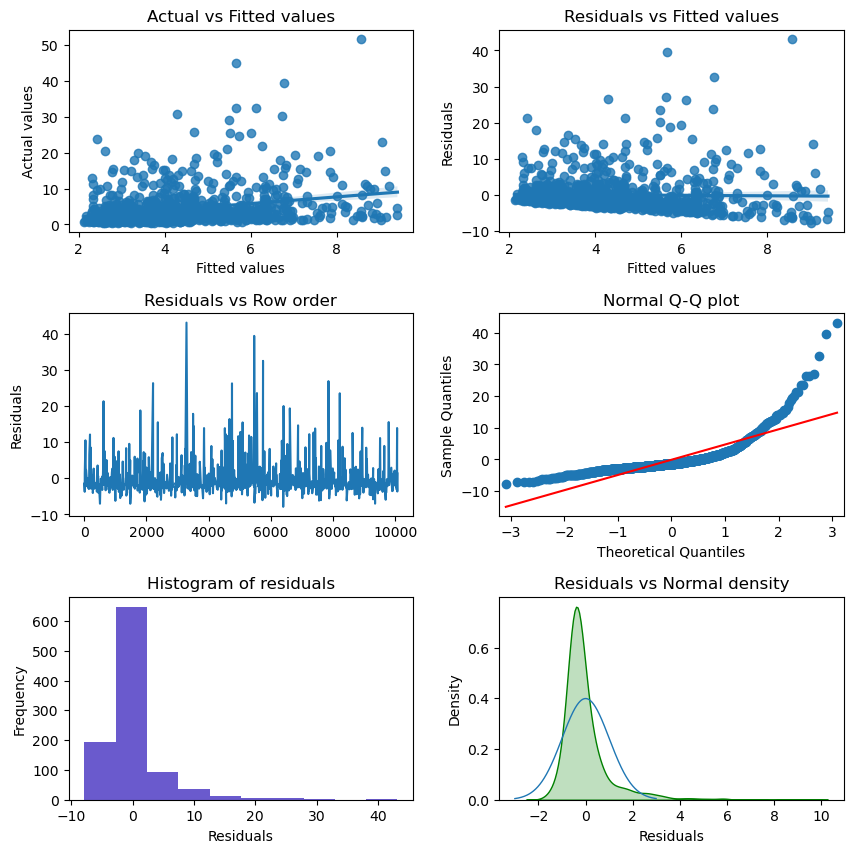

In [152]:
nn_os.plot("dashboard")

In [153]:
nn_os_test = rsm.mlp({
    "p_nptb_scaled_buyer_yes": pentathlon_nptb_scaled_buyer.query("training == 0")}, 
    rvar="total_os",
    evar= evar_nn,
    mod_type= 'regression',
    random_state=1234,
    **cvnnos.best_params_,
    
)
nn_os_test.summary()


Multi-layer Perceptron (NN)
Data                 : p_nptb_scaled_buyer_yes
Response variable    : total_os
Explanatory variables: income, education, children, female, freq_endurance, freq_strength, freq_water, freq_team, freq_backcountry, freq_racquet, age_30 to 44, age_45 to 59, age_>= 60, message_control, message_endurance, message_racquet, message_strength, message_team, message_water
Model type           : regression
Nr. of features      : (19, 19)
Nr. of weights       : 64
Nr. of observations  : 4,320
Hidden_layer_sizes   : (3,)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.1
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 1000000
random_state         : 1234
Model fit            :
     n     r2    mse    mae
  4320  0.115  0.885  0.595

Raw data             :
   income  education  children female  freq_endurance  freq_strength  freq_water  freq_team  freq_backcountry  freq_racquet  age_30 to 44  age_45 to 59  age_

The r^2 value is very low, indicating that the model does not explain much of the variance in the data. The MSE and MAE are also higher than the baseline model, indicating that the model is not performing well.

In [154]:
nn_os_train1 = rsm.mlp({
    "p_nptb_scaled_buyer_yes": pentathlon_nptb_scaled_buyer.query("training == 1")}, 
    rvar="total_os",
    evar= evar_nn,
    mod_type= 'regression',
    random_state=1234,
    hidden_layer_sizes=(5,10),
    alpha=0.01,
    
)
nn_os_train1.summary()


Multi-layer Perceptron (NN)
Data                 : p_nptb_scaled_buyer_yes
Response variable    : total_os
Explanatory variables: income, education, children, female, freq_endurance, freq_strength, freq_water, freq_team, freq_backcountry, freq_racquet, age_30 to 44, age_45 to 59, age_>= 60, message_control, message_endurance, message_racquet, message_strength, message_team, message_water
Model type           : regression
Nr. of features      : (19, 19)
Nr. of weights       : 171
Nr. of observations  : 10,080
Hidden_layer_sizes   : (5, 10)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.01
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 1000000
random_state         : 1234
Model fit            :
      n     r2    mse    mae
  10080  0.218  0.782  0.569

Raw data             :
  income  education  children female  freq_endurance  freq_strength  freq_water  freq_team  freq_backcountry  freq_racquet  age_30 to 44  age_45 to 5

In [155]:
nn_os_test1 = rsm.mlp({
    "p_nptb_scaled_buyer_yes": pentathlon_nptb_scaled_buyer.query("training == 0")}, 
    rvar="total_os",
    evar= evar_nn,
    mod_type= 'regression',
    random_state=1234,
    hidden_layer_sizes=(5,10),
    alpha=0.01,
    
)
nn_os_test1.summary()


Multi-layer Perceptron (NN)
Data                 : p_nptb_scaled_buyer_yes
Response variable    : total_os
Explanatory variables: income, education, children, female, freq_endurance, freq_strength, freq_water, freq_team, freq_backcountry, freq_racquet, age_30 to 44, age_45 to 59, age_>= 60, message_control, message_endurance, message_racquet, message_strength, message_team, message_water
Model type           : regression
Nr. of features      : (19, 19)
Nr. of weights       : 171
Nr. of observations  : 4,320
Hidden_layer_sizes   : (5, 10)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.01
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 1000000
random_state         : 1234
Model fit            :
     n     r2    mse    mae
  4320  0.371  0.629  0.521

Raw data             :
   income  education  children female  freq_endurance  freq_strength  freq_water  freq_team  freq_backcountry  freq_racquet  age_30 to 44  age_45 to 59 

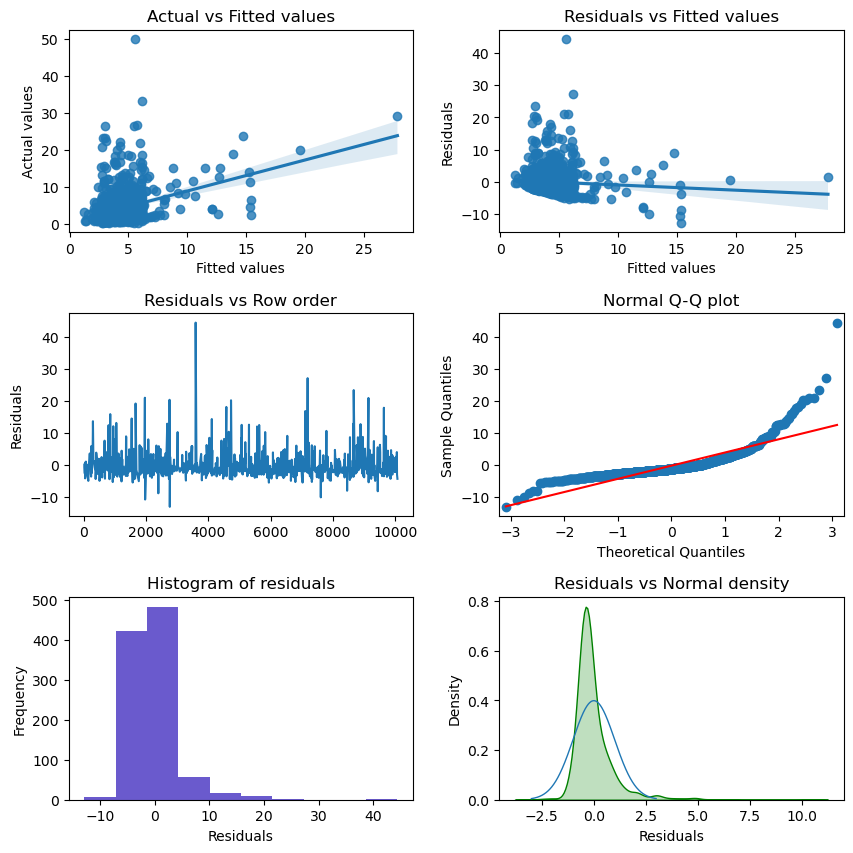

In [156]:
nn_os_train1.plot("dashboard")

Despite the higher R^2 value for the (5,10) hls model, we will proceed with the output with the cross validation  model because it has a better residuals vs fitted values plots showing lower signs of multicollinearity and  heteroscedasticity.

In [157]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
baseline_prediction = np.mean(pentathlon_nptb_scaled[(pentathlon_nptb_scaled['training']==1)&(pentathlon_nptb_scaled['buyer']=='yes')]['total_os']) 
y_baseline = np.full_like(pentathlon_nptb_scaled[(pentathlon_nptb_scaled['training']==0)&(pentathlon_nptb_scaled['buyer']=='yes')]['total_os'], baseline_prediction)
mse_baseline = mean_squared_error(pentathlon_nptb_scaled[(pentathlon_nptb_scaled['training']==0)&(pentathlon_nptb_scaled['buyer']=='yes')]['total_os'], y_baseline)
mse_nn = mean_squared_error(pentathlon_nptb_scaled[(pentathlon_nptb_scaled['training']==0)&(pentathlon_nptb_scaled['buyer']=='yes')]['total_os'], pentathlon_nptb_scaled[(pentathlon_nptb_scaled['training']==0)&(pentathlon_nptb_scaled['buyer']=='yes')]['nn_os'])

mae_nn = mean_absolute_error(pentathlon_nptb_scaled[(pentathlon_nptb_scaled['training']==0)&(pentathlon_nptb_scaled['buyer']=='yes')]['total_os'], pentathlon_nptb_scaled[(pentathlon_nptb_scaled['training']==0)&(pentathlon_nptb_scaled['buyer']=='yes')]['nn_os'])
mae_baseline = mean_absolute_error(pentathlon_nptb_scaled[(pentathlon_nptb_scaled['training']==0)&(pentathlon_nptb_scaled['buyer']=='yes')]['total_os'], y_baseline)

r2_nn = r2_score(pentathlon_nptb_scaled[(pentathlon_nptb_scaled['training']==0)&(pentathlon_nptb_scaled['buyer']=='yes')]['total_os'], pentathlon_nptb_scaled[(pentathlon_nptb_scaled['training']==0)&(pentathlon_nptb_scaled['buyer']=='yes')]['nn_os'])
r2_baseline = r2_score(pentathlon_nptb_scaled[(pentathlon_nptb_scaled['training']==0)&(pentathlon_nptb_scaled['buyer']=='yes')]['total_os'], y_baseline)

print(f"Neural Network MSE: {mse_nn:.4f}, Baseline MSE: {mse_baseline:.4f}")
print(f"Neural Network MAE: {mae_nn:.4f}, Baseline MAE: {mae_baseline:.4f}")
print(f"Neural Network R² Score: {r2_nn:.4f}, Baseline R² Score: {r2_baseline:.4f}")

Neural Network MSE: 21.1965, Baseline MSE: 22.6622
Neural Network MAE: 2.8816, Baseline MAE: 3.0391
Neural Network R² Score: 0.0647, Baseline R² Score: -0.0000


In [158]:
rsm.model.evalreg(pentathlon_nptb_scaled[pentathlon_nptb_scaled['training']==0], 'total_os', 'nn_os')

Type predictor       n      r2     mse    mae
0  All     nn_os  180000 -10.692  11.674  3.268

Since the MSE and MAE of the NN model are higher than the baseline model, and the R^2 for NN is also much lower than the baseline model we will not use the predictions from the NN for total_os.

In [159]:
pred_response_rate_nn = pentathlon_nptb_scaled_test.loc[pentathlon_nptb_scaled_test.training == 0, ['p_endurance_nn', 'p_strength_nn', 'p_water_nn', 'p_team_nn', 'p_backcountry_nn', 'p_racquet_nn', 'p_control_nn']].agg("mean").sort_values(
    ascending=False
).apply(rsm.format_nr, perc=True)
pred_response_rate_nn

p_endurance_nn      2.81%
p_strength_nn       2.67%
p_water_nn          2.52%
p_team_nn           2.46%
p_backcountry_nn    2.41%
p_racquet_nn        2.38%
p_control_nn        2.23%
dtype: object

In [160]:
# # Filter the dataset for buyers who responded "yes"
#buyers_yes_nn = pentathlon_nptb_scaled[(pentathlon_nptb_scaled['buyer'] == 'yes')&(pentathlon_nptb_scaled['training'] == 0)]
#buyers_yes = pentathlon_nptb_log_test[pentathlon_nptb_log_test['buyer'] == 'yes']

#Calculate average order sizes for each message type based on past data
avg_order_sizes = buyers_yes.groupby('message', observed=False)['total_os'].mean()
avg_order_sizes

message
backcountry    59.091339
control        50.040984
endurance      53.686275
racquet        61.222597
strength       54.489185
team           60.122186
water          63.358578
Name: total_os, dtype: float64

In [161]:
profits_on_message_type_nn = avg_order_sizes * 0.4
profits_on_message_type_nn

message
backcountry    23.636535
control        20.016393
endurance      21.474510
racquet        24.489039
strength       21.795674
team           24.048875
water          25.343431
Name: total_os, dtype: float64

In [162]:

# Calculate expected profit for each message type by multiplying the average order sizes with the profit
pentathlon_nptb_scaled_test["ep_endurance_nn"] = pentathlon_nptb_scaled_test.p_endurance_nn * profits_on_message_type_nn["endurance"] 
pentathlon_nptb_scaled_test["ep_strength_nn"] = pentathlon_nptb_scaled_test.p_strength_nn * profits_on_message_type_nn["strength"]
pentathlon_nptb_scaled_test["ep_water_nn"] = pentathlon_nptb_scaled_test.p_water_nn * profits_on_message_type_nn["water"]
pentathlon_nptb_scaled_test["ep_team_nn"] = pentathlon_nptb_scaled_test.p_team_nn * profits_on_message_type_nn["team"]
pentathlon_nptb_scaled_test["ep_backcountry_nn"] = pentathlon_nptb_scaled_test.p_backcountry_nn * profits_on_message_type_nn["backcountry"]
pentathlon_nptb_scaled_test["ep_racquet_nn"] = pentathlon_nptb_scaled_test.p_racquet_nn * profits_on_message_type_nn["racquet"]
pentathlon_nptb_scaled_test["ep_control_nn"] = pentathlon_nptb_scaled_test.p_control_nn * profits_on_message_type_nn["control"]
pentathlon_nptb_scaled_test




/tmp/ipykernel_35906/3782314867.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pentathlon_nptb_scaled_test["ep_endurance_nn"] = pentathlon_nptb_scaled_test.p_endurance_nn * profits_on_message_type_nn["endurance"]
/tmp/ipykernel_35906/3782314867.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pentathlon_nptb_scaled_test["ep_strength_nn"] = pentathlon_nptb_scaled_test.p_strength_nn * profits_on_message_type_nn["strength"]
/tmp/ipykernel_35906/3782314867.py:4: SettingWithCopyWarning: 
A value is tryin

custid buyer  total_os female    income  education  children  \
1             U3    no -0.105526      0 -0.756221  -0.462915  0.164886   
4            U25    no -0.105526      1  0.961033   0.210264  0.379491   
6            U30    no -0.105526      1  0.961033   2.229800 -0.908137   
7            U55    no -0.105526      0 -0.756221  -0.799504  0.379491   
15           U97    no -0.105526      1  0.961033   0.748807 -0.478928   
...          ...   ...       ...    ...       ...        ...       ...   
599991  U3462852    no -0.105526      1  0.102406  -0.664869  0.379491   
599994  U3462887    no -0.105526      1 -1.042430  -1.001458 -0.049719   
599996  U3462900    no -0.105526      0  0.388615   0.210264 -0.049719   
599998  U3462916    no -0.105526      0  0.102406   0.412217 -0.693532   
599999  U3462922    no -0.105526      1  0.102406  -0.260961 -0.478928   

        freq_endurance  freq_strength  freq_water  ...  p_racquet_nn  \
1            -0.639889      -0.706772   -0.261529  ...      0.001635   
4             0.060737       0.197170   -0.261529  ...      0.006985   
6             0.060737       1.553084   -0.261529  ...      0.060530   
7            -0.639889      -0.706772   -0.261529  ...      0.001568   
15            2.162617       2.005055    2.109507  ...      0.006393   
...                ...            ...         ...  ...           ...   
599991       -0.639889      -0.254801   -0.261529  ...      0.002667   
599994        0.060737      -0.706772   -0.261529  ...      0.004596   
599996        1.461990      -0.254801   -0.261529  ...      0.004984   
599998        0.761364       0.197170   -0.261529  ...      0.003837   
599999        0.060737       0.197170   -0.261529  ...      0.003495   

        p_control_nn  best_message_nn  ep_endurance_nn  ep_strength_nn  \
1           0.001511         strength         0.033316        0.040393   
4           0.006978             team         0.117841        0.164700   
6           0.054679         strength         1.231686        1.415474   
7           0.001441             team         0.029679        0.035250   
15          0.005818             team         0.127328        0.142940   
...              ...              ...              ...             ...   
599991      0.002415             team         0.049466        0.064642   
599994      0.005073        endurance         0.133374        0.115698   
599996      0.004496         strength         0.086099        0.115309   
599998      0.003478         strength         0.062707        0.084561   
599999      0.003158             team         0.070852        0.077210   

        ep_water_nn  ep_team_nn  ep_backcountry_nn  ep_racquet_nn  \
1          0.040363    0.043419           0.040685       0.040045   
4          0.188928    0.195692           0.165092       0.171047   
6          1.589800    1.513772           1.355691       1.482326   
7          0.037990    0.041771           0.038228       0.038387   
15         0.161871    0.159990           0.140147       0.156568   
...             ...         ...                ...            ...   
599991     0.069368    0.071698           0.064696       0.065320   
599994     0.125307    0.111868           0.119917       0.112556   
599996     0.122078    0.116875           0.114871       0.122056   
599998     0.092633    0.087057           0.085564       0.093955   
599999     0.083945    0.090891           0.077986       0.085588   

        ep_control_nn  
1            0.030251  
4            0.139668  
6            1.094473  
7            0.028846  
15           0.116451  
...               ...  
599991       0.048347  
599994       0.101551  
599996       0.089999  
599998       0.069621  
599999       0.063212  

[180000 rows x 40 columns]

In [163]:
repl = {"ep_endurance_nn": "endurance", "ep_strength_nn": "strength", "ep_water_nn": "water", "ep_team_nn": "team", "ep_backcountry_nn": "backcountry", "ep_racquet_nn": "racquet", "ep_control_nn": "control"}
pentathlon_nptb_scaled_test['msg_ep_nn'] = pentathlon_nptb_scaled_test[['ep_endurance_nn', 'ep_strength_nn', 'ep_water_nn', 'ep_team_nn', 'ep_backcountry_nn', 'ep_racquet_nn', 'ep_control_nn']].idxmax(axis=1).map(repl)
pentathlon_nptb_scaled_test

/tmp/ipykernel_35906/894550111.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pentathlon_nptb_scaled_test['msg_ep_nn'] = pentathlon_nptb_scaled_test[['ep_endurance_nn', 'ep_strength_nn', 'ep_water_nn', 'ep_team_nn', 'ep_backcountry_nn', 'ep_racquet_nn', 'ep_control_nn']].idxmax(axis=1).map(repl)


custid buyer  total_os female    income  education  children  \
1             U3    no -0.105526      0 -0.756221  -0.462915  0.164886   
4            U25    no -0.105526      1  0.961033   0.210264  0.379491   
6            U30    no -0.105526      1  0.961033   2.229800 -0.908137   
7            U55    no -0.105526      0 -0.756221  -0.799504  0.379491   
15           U97    no -0.105526      1  0.961033   0.748807 -0.478928   
...          ...   ...       ...    ...       ...        ...       ...   
599991  U3462852    no -0.105526      1  0.102406  -0.664869  0.379491   
599994  U3462887    no -0.105526      1 -1.042430  -1.001458 -0.049719   
599996  U3462900    no -0.105526      0  0.388615   0.210264 -0.049719   
599998  U3462916    no -0.105526      0  0.102406   0.412217 -0.693532   
599999  U3462922    no -0.105526      1  0.102406  -0.260961 -0.478928   

        freq_endurance  freq_strength  freq_water  ...  p_control_nn  \
1            -0.639889      -0.706772   -0.261529  ...      0.001511   
4             0.060737       0.197170   -0.261529  ...      0.006978   
6             0.060737       1.553084   -0.261529  ...      0.054679   
7            -0.639889      -0.706772   -0.261529  ...      0.001441   
15            2.162617       2.005055    2.109507  ...      0.005818   
...                ...            ...         ...  ...           ...   
599991       -0.639889      -0.254801   -0.261529  ...      0.002415   
599994        0.060737      -0.706772   -0.261529  ...      0.005073   
599996        1.461990      -0.254801   -0.261529  ...      0.004496   
599998        0.761364       0.197170   -0.261529  ...      0.003478   
599999        0.060737       0.197170   -0.261529  ...      0.003158   

        best_message_nn  ep_endurance_nn  ep_strength_nn  ep_water_nn  \
1              strength         0.033316        0.040393     0.040363   
4                  team         0.117841        0.164700     0.188928   
6              strength         1.231686        1.415474     1.589800   
7                  team         0.029679        0.035250     0.037990   
15                 team         0.127328        0.142940     0.161871   
...                 ...              ...             ...          ...   
599991             team         0.049466        0.064642     0.069368   
599994        endurance         0.133374        0.115698     0.125307   
599996         strength         0.086099        0.115309     0.122078   
599998         strength         0.062707        0.084561     0.092633   
599999             team         0.070852        0.077210     0.083945   

        ep_team_nn  ep_backcountry_nn  ep_racquet_nn  ep_control_nn  msg_ep_nn  
1         0.043419           0.040685       0.040045       0.030251       team  
4         0.195692           0.165092       0.171047       0.139668       team  
6         1.513772           1.355691       1.482326       1.094473      water  
7         0.041771           0.038228       0.038387       0.028846       team  
15        0.159990           0.140147       0.156568       0.116451      water  
...            ...                ...            ...            ...        ...  
599991    0.071698           0.064696       0.065320       0.048347       team  
599994    0.111868           0.119917       0.112556       0.101551  endurance  
599996    0.116875           0.114871       0.122056       0.089999      water  
599998    0.087057           0.085564       0.093955       0.069621    racquet  
599999    0.090891           0.077986       0.085588       0.063212       team  

[180000 rows x 41 columns]

In [164]:
pentathlon_nptb_scaled_test["ep_max_nn"] = pentathlon_nptb_scaled_test[['ep_endurance_nn', 'ep_strength_nn', 'ep_water_nn', 'ep_team_nn', 'ep_backcountry_nn', 'ep_racquet_nn', 'ep_control_nn']].max(axis=1)
pentathlon_nptb_scaled_test

/tmp/ipykernel_35906/11288107.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pentathlon_nptb_scaled_test["ep_max_nn"] = pentathlon_nptb_scaled_test[['ep_endurance_nn', 'ep_strength_nn', 'ep_water_nn', 'ep_team_nn', 'ep_backcountry_nn', 'ep_racquet_nn', 'ep_control_nn']].max(axis=1)


custid buyer  total_os female    income  education  children  \
1             U3    no -0.105526      0 -0.756221  -0.462915  0.164886   
4            U25    no -0.105526      1  0.961033   0.210264  0.379491   
6            U30    no -0.105526      1  0.961033   2.229800 -0.908137   
7            U55    no -0.105526      0 -0.756221  -0.799504  0.379491   
15           U97    no -0.105526      1  0.961033   0.748807 -0.478928   
...          ...   ...       ...    ...       ...        ...       ...   
599991  U3462852    no -0.105526      1  0.102406  -0.664869  0.379491   
599994  U3462887    no -0.105526      1 -1.042430  -1.001458 -0.049719   
599996  U3462900    no -0.105526      0  0.388615   0.210264 -0.049719   
599998  U3462916    no -0.105526      0  0.102406   0.412217 -0.693532   
599999  U3462922    no -0.105526      1  0.102406  -0.260961 -0.478928   

        freq_endurance  freq_strength  freq_water  ...  best_message_nn  \
1            -0.639889      -0.706772   -0.261529  ...         strength   
4             0.060737       0.197170   -0.261529  ...             team   
6             0.060737       1.553084   -0.261529  ...         strength   
7            -0.639889      -0.706772   -0.261529  ...             team   
15            2.162617       2.005055    2.109507  ...             team   
...                ...            ...         ...  ...              ...   
599991       -0.639889      -0.254801   -0.261529  ...             team   
599994        0.060737      -0.706772   -0.261529  ...        endurance   
599996        1.461990      -0.254801   -0.261529  ...         strength   
599998        0.761364       0.197170   -0.261529  ...         strength   
599999        0.060737       0.197170   -0.261529  ...             team   

        ep_endurance_nn  ep_strength_nn  ep_water_nn  ep_team_nn  \
1              0.033316        0.040393     0.040363    0.043419   
4              0.117841        0.164700     0.188928    0.195692   
6              1.231686        1.415474     1.589800    1.513772   
7              0.029679        0.035250     0.037990    0.041771   
15             0.127328        0.142940     0.161871    0.159990   
...                 ...             ...          ...         ...   
599991         0.049466        0.064642     0.069368    0.071698   
599994         0.133374        0.115698     0.125307    0.111868   
599996         0.086099        0.115309     0.122078    0.116875   
599998         0.062707        0.084561     0.092633    0.087057   
599999         0.070852        0.077210     0.083945    0.090891   

        ep_backcountry_nn  ep_racquet_nn  ep_control_nn  msg_ep_nn  ep_max_nn  
1                0.040685       0.040045       0.030251       team   0.043419  
4                0.165092       0.171047       0.139668       team   0.195692  
6                1.355691       1.482326       1.094473      water   1.589800  
7                0.038228       0.038387       0.028846       team   0.041771  
15               0.140147       0.156568       0.116451      water   0.161871  
...                   ...            ...            ...        ...        ...  
599991           0.064696       0.065320       0.048347       team   0.071698  
599994           0.119917       0.112556       0.101551  endurance   0.133374  
599996           0.114871       0.122056       0.089999      water   0.122078  
599998           0.085564       0.093955       0.069621    racquet   0.093955  
599999           0.077986       0.085588       0.063212       team   0.090891  

[180000 rows x 42 columns]

In [165]:
message_ep_counts_nn = pd.crosstab(index=pentathlon_nptb_scaled_test["msg_ep_nn"], columns="count").reindex(['backcountry', 'control', 'endurance', 'racquet', 'strength', 'team', 'water'], fill_value=0).applymap(rsm.format_nr)
message_ep_counts_nn

/tmp/ipykernel_35906/1714067930.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  message_ep_counts_nn = pd.crosstab(index=pentathlon_nptb_scaled_test["msg_ep_nn"], columns="count").reindex(['backcountry', 'control', 'endurance', 'racquet', 'strength', 'team', 'water'], fill_value=0).applymap(rsm.format_nr)


col_0         count
msg_ep_nn          
backcountry       1
control           0
endurance    60,286
racquet       3,924
strength      8,220
team         61,932
water        45,637

After we trained the Neural Network model, the distribution of expected profits shows that Team is the best message while Endurance is a very close second in terms of how customers engage with them. Strenght and Racquet are more niche, but they are still relevant when it comes to capturing a specific group in the market/customer base while backcountry is essentially negligible and control is 0 because some form of communication with the customer is important. 

Endurance leads in purchase probability (45.3%), but team becomes the top choice in profit-based assignments (61,932 customers), suggesting higher profitability.

Water sees a major jump, from 0.17% of customers (probability-based) to 45,637 customers (profit-based), indicating fewer but more profitable conversions.
Strength drops significantly (from 30.5% to 8,220 customers), meaning it's engaging but less profitable.

Control remains zero in both, proving any message is better than none.
Profit-based assignments distribute customers more evenly, while probability-based favors endurance.


4.  Report for each message, i.e., endurance, racket, etc., and no-message, the percentage 
of customers for whom that (no) message maximizes their expected profit. Comment on 
the distribution of expected profit across messages.

In [166]:

message_ep_counts_nn['count'] = message_ep_counts_nn['count'].str.replace(',', '').astype(int)

In [167]:
# Calculate the percentage of customers for whom each message maximizes their expected profit
message_ep_percentages_nn = message_ep_counts_nn['count'] / message_ep_counts_nn['count'].sum() * 100

# Display the percentages
message_ep_percentages_nn.rename("percentage of customers", inplace=True)
message_ep_percentages_nn

message_ep_perc_nn = pd.DataFrame(
    {
        "message": message_ep_percentages_nn.index,
        "percentage of customers": message_ep_percentages_nn.values,
    }
)

message_ep_percentages_nn

msg_ep_nn
backcountry     0.000556
control         0.000000
endurance      33.492222
racquet         2.180000
strength        4.566667
team           34.406667
water          25.353889
Name: percentage of customers, dtype: float64

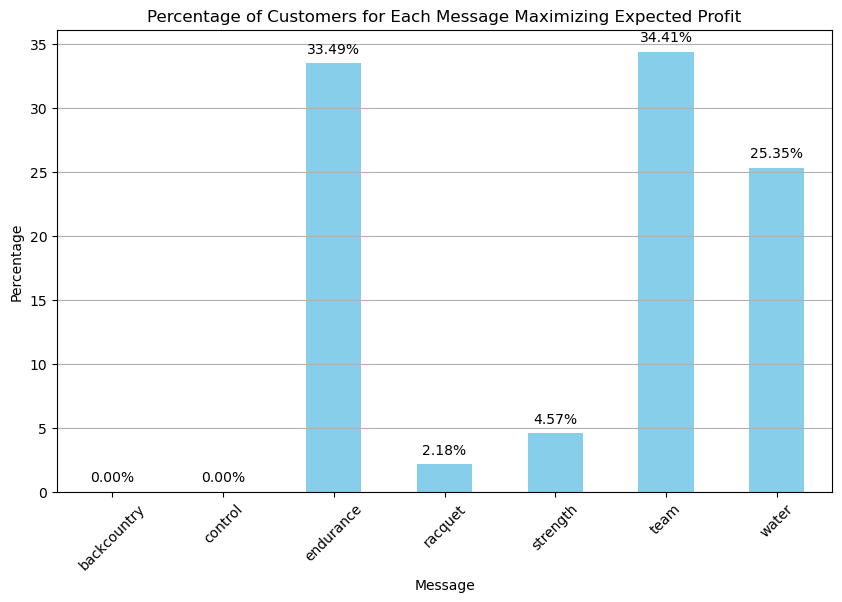

In [168]:
import matplotlib.pyplot as plt

# Plot the message_ep_percentages
ax = message_ep_percentages_nn.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Percentage of Customers for Each Message Maximizing Expected Profit')
plt.xlabel('Message')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Add percentage values on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

The above chart shows the percentage of customers for whom each message maximizes expected profit.
Endurance and team collectively account for approx 68% of all customers suggesting that there is a broad customer base where this emails yield the highest profit. 
A quarter of the customers respond the best to Water messages while RAcquet and Strenght seem to have minimal impact which is likely because they are appealing messages only to a niche subset of customers. 
Backountry and control are at 0%, suggesting that sending these messages is an inefficient use of time. 

5.  What  expected  profit  can  we  obtain,  on  average,  per  customer  if  we  customize  the 
message to each customer? Include no-message as an option as well.

In [169]:
# Calculate the average expected profit per customer
average_expected_profit_nn = pentathlon_nptb_scaled_test["ep_max_nn"].mean()
print(f"Average expected profit per customer with Neural Networks model: {average_expected_profit_nn:.2f} Euros")

Average expected profit per customer with Neural Networks model: 0.65 Euros



6.  What is the expected profit per e-mailed customer if every customer receives the same 
message?  Answer  this  question  for  each  of  the  possible  messages  (i.e.,  endurance, 
strength, water, team, backcountry, racquet) and the no-message option. Comment on 
the distribution of expected profit across messages and the no-message option. 


In [170]:
# Calculate the average expected profit for each message type
avg_ep_values_nn = pentathlon_nptb_scaled_test[['ep_endurance_nn', 'ep_strength_nn', 'ep_water_nn', 'ep_team_nn', 'ep_backcountry_nn', 'ep_racquet_nn', 'ep_control_nn']].mean()

# Create a table to compare the values
avg_ep_table_nn = pd.DataFrame(avg_ep_values_nn, columns=['Expected Profit'])
avg_ep_table_nn.index = avg_ep_table_nn.index.str.replace('ep_', '').str.replace('_nn', '').str.capitalize()
avg_ep_table_nn

Expected Profit
Endurance           0.604316
Strength            0.582801
Water               0.638710
Team                0.592133
Backcountry         0.569941
Racquet             0.584045
Control             0.446713

Water has the highest expected profit (0.6387), making it the most profitable mass email option.
Endurance, team, and strength also perform well, but are slightly lower than water.
Backcountry and racquet have lower profitability, indicating they are less effective.
Control (no message) is the worst option, confirming that sending any email is more profitable than none.

**NN**

7. What is the expected profit per e-mailed customer if every customer is assigned randomly 
to one of the messages or the no-message condition?   

In [171]:
pentathlon_nptb_scaled_test = pentathlon_nptb_scaled_test.merge(pentathlon_nptb[['custid', 'message']], on='custid', how='left')
pentathlon_nptb_scaled_test

custid buyer  total_os female    income  education  children  \
0             U3    no -0.105526      0 -0.756221  -0.462915  0.164886   
1            U25    no -0.105526      1  0.961033   0.210264  0.379491   
2            U30    no -0.105526      1  0.961033   2.229800 -0.908137   
3            U55    no -0.105526      0 -0.756221  -0.799504  0.379491   
4            U97    no -0.105526      1  0.961033   0.748807 -0.478928   
...          ...   ...       ...    ...       ...        ...       ...   
179995  U3462852    no -0.105526      1  0.102406  -0.664869  0.379491   
179996  U3462887    no -0.105526      1 -1.042430  -1.001458 -0.049719   
179997  U3462900    no -0.105526      0  0.388615   0.210264 -0.049719   
179998  U3462916    no -0.105526      0  0.102406   0.412217 -0.693532   
179999  U3462922    no -0.105526      1  0.102406  -0.260961 -0.478928   

        freq_endurance  freq_strength  freq_water  ...  ep_endurance_nn  \
0            -0.639889      -0.706772   -0.261529  ...         0.033316   
1             0.060737       0.197170   -0.261529  ...         0.117841   
2             0.060737       1.553084   -0.261529  ...         1.231686   
3            -0.639889      -0.706772   -0.261529  ...         0.029679   
4             2.162617       2.005055    2.109507  ...         0.127328   
...                ...            ...         ...  ...              ...   
179995       -0.639889      -0.254801   -0.261529  ...         0.049466   
179996        0.060737      -0.706772   -0.261529  ...         0.133374   
179997        1.461990      -0.254801   -0.261529  ...         0.086099   
179998        0.761364       0.197170   -0.261529  ...         0.062707   
179999        0.060737       0.197170   -0.261529  ...         0.070852   

        ep_strength_nn  ep_water_nn  ep_team_nn  ep_backcountry_nn  \
0             0.040393     0.040363    0.043419           0.040685   
1             0.164700     0.188928    0.195692           0.165092   
2             1.415474     1.589800    1.513772           1.355691   
3             0.035250     0.037990    0.041771           0.038228   
4             0.142940     0.161871    0.159990           0.140147   
...                ...          ...         ...                ...   
179995        0.064642     0.069368    0.071698           0.064696   
179996        0.115698     0.125307    0.111868           0.119917   
179997        0.115309     0.122078    0.116875           0.114871   
179998        0.084561     0.092633    0.087057           0.085564   
179999        0.077210     0.083945    0.090891           0.077986   

        ep_racquet_nn  ep_control_nn  msg_ep_nn  ep_max_nn      message  
0            0.040045       0.030251       team   0.043419  backcountry  
1            0.171047       0.139668       team   0.195692      racquet  
2            1.482326       1.094473      water   1.589800    endurance  
3            0.038387       0.028846       team   0.041771     strength  
4            0.156568       0.116451      water   0.161871    endurance  
...               ...            ...        ...        ...          ...  
179995       0.065320       0.048347       team   0.071698        water  
179996       0.112556       0.101551  endurance   0.133374      control  
179997       0.122056       0.089999      water   0.122078         team  
179998       0.093955       0.069621    racquet   0.093955         team  
179999       0.085588       0.063212       team   0.090891    endurance  

[180000 rows x 43 columns]

In [172]:
message_counts_nn = pentathlon_nptb_scaled_test['message'].value_counts()
print(message_counts_nn)

message
racquet        26316
backcountry    26179
control        26043
team           25942
water          25496
strength       25251
endurance      24773
Name: count, dtype: int64


In [173]:
# Merge total_os from pentathlon_nptb onto pentathlon_nptb_scaled_test
pentathlon_nptb_scaled_test = pentathlon_nptb_scaled_test.merge(
    pentathlon_nptb[['custid', 'total_os']], 
    on='custid', 
    how='left', 
    suffixes=('', '_unscaled')
)

pentathlon_nptb_scaled_test

custid buyer  total_os female    income  education  children  \
0             U3    no -0.105526      0 -0.756221  -0.462915  0.164886   
1            U25    no -0.105526      1  0.961033   0.210264  0.379491   
2            U30    no -0.105526      1  0.961033   2.229800 -0.908137   
3            U55    no -0.105526      0 -0.756221  -0.799504  0.379491   
4            U97    no -0.105526      1  0.961033   0.748807 -0.478928   
...          ...   ...       ...    ...       ...        ...       ...   
179995  U3462852    no -0.105526      1  0.102406  -0.664869  0.379491   
179996  U3462887    no -0.105526      1 -1.042430  -1.001458 -0.049719   
179997  U3462900    no -0.105526      0  0.388615   0.210264 -0.049719   
179998  U3462916    no -0.105526      0  0.102406   0.412217 -0.693532   
179999  U3462922    no -0.105526      1  0.102406  -0.260961 -0.478928   

        freq_endurance  freq_strength  freq_water  ...  ep_strength_nn  \
0            -0.639889      -0.706772   -0.261529  ...        0.040393   
1             0.060737       0.197170   -0.261529  ...        0.164700   
2             0.060737       1.553084   -0.261529  ...        1.415474   
3            -0.639889      -0.706772   -0.261529  ...        0.035250   
4             2.162617       2.005055    2.109507  ...        0.142940   
...                ...            ...         ...  ...             ...   
179995       -0.639889      -0.254801   -0.261529  ...        0.064642   
179996        0.060737      -0.706772   -0.261529  ...        0.115698   
179997        1.461990      -0.254801   -0.261529  ...        0.115309   
179998        0.761364       0.197170   -0.261529  ...        0.084561   
179999        0.060737       0.197170   -0.261529  ...        0.077210   

        ep_water_nn  ep_team_nn  ep_backcountry_nn  ep_racquet_nn  \
0          0.040363    0.043419           0.040685       0.040045   
1          0.188928    0.195692           0.165092       0.171047   
2          1.589800    1.513772           1.355691       1.482326   
3          0.037990    0.041771           0.038228       0.038387   
4          0.161871    0.159990           0.140147       0.156568   
...             ...         ...                ...            ...   
179995     0.069368    0.071698           0.064696       0.065320   
179996     0.125307    0.111868           0.119917       0.112556   
179997     0.122078    0.116875           0.114871       0.122056   
179998     0.092633    0.087057           0.085564       0.093955   
179999     0.083945    0.090891           0.077986       0.085588   

        ep_control_nn  msg_ep_nn  ep_max_nn      message  total_os_unscaled  
0            0.030251       team   0.043419  backcountry                  0  
1            0.139668       team   0.195692      racquet                  0  
2            1.094473      water   1.589800    endurance                  0  
3            0.028846       team   0.041771     strength                  0  
4            0.116451      water   0.161871    endurance                  0  
...               ...        ...        ...          ...                ...  
179995       0.048347       team   0.071698        water                  0  
179996       0.101551  endurance   0.133374      control                  0  
179997       0.089999      water   0.122078         team                  0  
179998       0.069621    racquet   0.093955         team                  0  
179999       0.063212       team   0.090891    endurance                  0  

[180000 rows x 44 columns]

In [174]:
# profits based on message col

pentathlon_nptb_scaled_test['profits'] = pentathlon_nptb_scaled_test['total_os_unscaled'] * 0.4 
pentathlon_nptb_scaled_test

custid buyer  total_os female    income  education  children  \
0             U3    no -0.105526      0 -0.756221  -0.462915  0.164886   
1            U25    no -0.105526      1  0.961033   0.210264  0.379491   
2            U30    no -0.105526      1  0.961033   2.229800 -0.908137   
3            U55    no -0.105526      0 -0.756221  -0.799504  0.379491   
4            U97    no -0.105526      1  0.961033   0.748807 -0.478928   
...          ...   ...       ...    ...       ...        ...       ...   
179995  U3462852    no -0.105526      1  0.102406  -0.664869  0.379491   
179996  U3462887    no -0.105526      1 -1.042430  -1.001458 -0.049719   
179997  U3462900    no -0.105526      0  0.388615   0.210264 -0.049719   
179998  U3462916    no -0.105526      0  0.102406   0.412217 -0.693532   
179999  U3462922    no -0.105526      1  0.102406  -0.260961 -0.478928   

        freq_endurance  freq_strength  freq_water  ...  ep_water_nn  \
0            -0.639889      -0.706772   -0.261529  ...     0.040363   
1             0.060737       0.197170   -0.261529  ...     0.188928   
2             0.060737       1.553084   -0.261529  ...     1.589800   
3            -0.639889      -0.706772   -0.261529  ...     0.037990   
4             2.162617       2.005055    2.109507  ...     0.161871   
...                ...            ...         ...  ...          ...   
179995       -0.639889      -0.254801   -0.261529  ...     0.069368   
179996        0.060737      -0.706772   -0.261529  ...     0.125307   
179997        1.461990      -0.254801   -0.261529  ...     0.122078   
179998        0.761364       0.197170   -0.261529  ...     0.092633   
179999        0.060737       0.197170   -0.261529  ...     0.083945   

        ep_team_nn  ep_backcountry_nn  ep_racquet_nn  ep_control_nn  \
0         0.043419           0.040685       0.040045       0.030251   
1         0.195692           0.165092       0.171047       0.139668   
2         1.513772           1.355691       1.482326       1.094473   
3         0.041771           0.038228       0.038387       0.028846   
4         0.159990           0.140147       0.156568       0.116451   
...            ...                ...            ...            ...   
179995    0.071698           0.064696       0.065320       0.048347   
179996    0.111868           0.119917       0.112556       0.101551   
179997    0.116875           0.114871       0.122056       0.089999   
179998    0.087057           0.085564       0.093955       0.069621   
179999    0.090891           0.077986       0.085588       0.063212   

        msg_ep_nn  ep_max_nn      message  total_os_unscaled  profits  
0            team   0.043419  backcountry                  0      0.0  
1            team   0.195692      racquet                  0      0.0  
2           water   1.589800    endurance                  0      0.0  
3            team   0.041771     strength                  0      0.0  
4           water   0.161871    endurance                  0      0.0  
...           ...        ...          ...                ...      ...  
179995       team   0.071698        water                  0      0.0  
179996  endurance   0.133374      control                  0      0.0  
179997      water   0.122078         team                  0      0.0  
179998    racquet   0.093955         team                  0      0.0  
179999       team   0.090891    endurance                  0      0.0  

[180000 rows x 45 columns]

In [175]:
pentathlon_nptb_scaled_test['profits'].mean()

0.5518799999999999

The average profit per customer when randomly assigned to message types is: 0.5518799999999999 Euros

**NN**

8. For the typical promotional e-mail blast to 5,000,000 customers, what improvement (in 
percent and in total Euros) could Pentathlon achieve by customizing the message (or no-
message) to each customer. Compare the performance predictions from this personalized 
approach to scenarios where (1) each customer is sent the same message selected based 
on average performance, (2) a random message assignment approach is used (i.e., the 
status quo), and (3) no message is sent (i.e., the control condition)? 

In [176]:
avg_profits_msg_nn = pentathlon_nptb_scaled_test[['ep_endurance_nn', 'ep_strength_nn', 'ep_water_nn', 'ep_team_nn', 'ep_backcountry_nn', 'ep_racquet_nn']].mean()
avg_profits_msg_nn

ep_endurance_nn      0.604316
ep_strength_nn       0.582801
ep_water_nn          0.638710
ep_team_nn           0.592133
ep_backcountry_nn    0.569941
ep_racquet_nn        0.584045
dtype: float64

In [177]:
n = 5_000_000
extrpolated_p_nn = pentathlon_nptb_scaled_test['ep_max_nn'].mean() * n #best scenario from targeting
extrpolated_p_nn

3267902.9381132997

In [178]:
# (1)

avg_profits_max_nn = avg_profits_msg_nn.max()
e_profits1_nn = avg_profits_max_nn * n

print("Extrapolated profits based on each customer if sent the same message selected based on average performance: ", e_profits1_nn)
print("Improvement in profits (in Euros) if each customer is sent a personalized msg vs the same msg selected based on average performance: ",  extrpolated_p_nn - e_profits1_nn, "Euros")
print("Improvement in profits (in %) if each customer is sent a personalized msg vs the same msg selected based on average performance:  ",  (extrpolated_p_nn - e_profits1_nn) / e_profits1_nn * 100, "%")

Extrapolated profits based on each customer if sent the same message selected based on average performance:  3193550.3209921895
Improvement in profits (in Euros) if each customer is sent a personalized msg vs the same msg selected based on average performance:  74352.6171211102 Euros
Improvement in profits (in %) if each customer is sent a personalized msg vs the same msg selected based on average performance:   2.328211853508854 %


In [179]:
#2
extrpolated_profit_random_nn = pentathlon_nptb_scaled_test['profits'].mean() * n # profits extrapolated based on random assignment

print("Profit improvement (in %) by using the best message as compared to random messaging: ", (extrpolated_p_nn - extrpolated_profit_random_nn)/extrpolated_profit_random_nn * 100, "%")
print("Profit improvement (in Euros) by using the best message as compared to random messaging: ", extrpolated_p_nn - extrpolated_profit_random_nn, "Euros")

Profit improvement (in %) by using the best message as compared to random messaging:  18.428025589378134 %
Profit improvement (in Euros) by using the best message as compared to random messaging:  508502.93811330013 Euros


In [180]:
#3
avg_e_profit_control_nn = pentathlon_nptb_scaled_test['ep_control_nn'].mean()
extrapolated_control_profit_nn = avg_e_profit_control_nn * n
print("extrapoltes profit by best message: ", extrpolated_p_nn)
print("Extrapolated profits based on control message: ", extrapolated_control_profit_nn)
print("Profit improvement (in Euros) by using the best message as compared to control message: ", extrpolated_p_nn - extrapolated_control_profit_nn, "Euros")
print("Profit improvement (in %) by using the best message as compared to control message: ", (extrpolated_p_nn - extrapolated_control_profit_nn) / extrapolated_control_profit_nn * 100, "%")

extrapoltes profit by best message:  3267902.9381132997
Extrapolated profits based on control message:  2233562.7363951853
Profit improvement (in Euros) by using the best message as compared to control message:  1034340.2017181143 Euros
Profit improvement (in %) by using the best message as compared to control message:  46.30898361903491 %


Overall Analysis:

1. Personalized Message Assignment is the best strategy as it outperforms the control group by 46.31% (1.03M Euro gain).

2. Using the same Best Message is better than random but worse that personalization, this strategy yields a ~42% increase in progit when compared to the control group.

3. Random assignment is extremely inefficient yet still results in a profit enhancement of nearly 24% over the control group. 

4. Sending no messages is the least optimal strategy. 

Personalized messaging remains the gold standard, maximizing profits.

## RANDOM FOREST


1. For  each  customer  determine  the  message  (i.e.,  endurance,  strength,  water,  team, 
backcountry,  racquet,  or  no-message)  predicted  to  lead  to  the  highest  probability  of 
purchase. 

In [181]:
pentathlon_nptb_rf = pentathlon_nptb.copy()
pentathlon_nptb_rf

custid buyer  total_os      message       age female  income  \
0             U1    no         0         team  30 to 44     no   55000   
1             U3    no         0  backcountry  45 to 59     no   35000   
2            U13    no         0    endurance  45 to 59    yes   45000   
3            U20    no         0        water  45 to 59    yes   25000   
4            U25    no         0      racquet     >= 60    yes   65000   
...          ...   ...       ...          ...       ...    ...     ...   
599995  U3462888    no         0        water     >= 60    yes   40000   
599996  U3462900    no         0         team      < 30     no   55000   
599997  U3462902    no         0         team      < 30    yes   55000   
599998  U3462916    no         0         team      < 30     no   50000   
599999  U3462922    no         0    endurance  30 to 44    yes   50000   

        education  children  freq_endurance  freq_strength  freq_water  \
0              19       0.8               0              4           0   
1              22       1.0               0              0           0   
2              33       0.7               0              0           0   
3              24       0.2               0              0           0   
4              32       1.1               1              2           0   
...           ...       ...             ...            ...         ...   
599995         26       0.6               0              0           0   
599996         32       0.9               3              1           0   
599997         32       0.9               0              5           0   
599998         35       0.6               2              2           0   
599999         25       0.7               1              2           0   

        freq_team  freq_backcountry  freq_racquet  training  total_freq  
0               4                 0             1       1.0           9  
1               1                 0             0       0.0           1  
2               0                 2             2       1.0           4  
3               0                 0             0       1.0           0  
4               0                 2             2       0.0           7  
...           ...               ...           ...       ...         ...  
599995          0                 0             0       1.0           0  
599996          0                 0             1       0.0           5  
599997          2                 1             2       1.0          10  
599998          0                 0             1       0.0           5  
599999          0                 0             2       0.0           5  

[600000 rows x 17 columns]

In [182]:
# Convert 'female' column to binary variable
pentathlon_nptb_rf['female'] = pentathlon_nptb_rf['female'].apply(lambda x: 1 if x == 'yes' else 0)

# One hot encode 'age' and message column
pentathlon_nptb_rf = pd.get_dummies(pentathlon_nptb_rf, columns=['age','message'], drop_first=True)

# Display the updated dataframe
pentathlon_nptb_rf.head()

custid buyer  total_os female  income  education  children  freq_endurance  \
0     U1    no         0      0   55000         19       0.8               0   
1     U3    no         0      0   35000         22       1.0               0   
2    U13    no         0      1   45000         33       0.7               0   
3    U20    no         0      1   25000         24       0.2               0   
4    U25    no         0      1   65000         32       1.1               1   

   freq_strength  freq_water  ...  total_freq  age_30 to 44  age_45 to 59  \
0              4           0  ...           9          True         False   
1              0           0  ...           1         False          True   
2              0           0  ...           4         False          True   
3              0           0  ...           0         False          True   
4              2           0  ...           7         False         False   

   age_>= 60  message_control  message_endurance  message_racquet  \
0      False            False              False            False   
1      False            False              False            False   
2      False            False               True            False   
3      False            False              False            False   
4       True            False              False             True   

   message_strength  message_team  message_water  
0             False          True          False  
1             False         False          False  
2             False         False          False  
3             False         False           True  
4             False         False          False  

[5 rows x 24 columns]

In [183]:
import numpy as np

# Apply log+1 transformation to specified columns
#pentathlon_nptb_rf_log = pentathlon_nptb_rf.copy()
#columns_to_transform = ['income', 'children', 'education', 'freq_endurance', 'freq_strength', 'freq_water', 'freq_team', 'freq_backcountry', 'freq_racquet']
#pentathlon_nptb_rf_log[columns_to_transform] = pentathlon_nptb_rf_log[columns_to_transform].apply(lambda x: np.log1p(x))

# One hot encode 'message', 'age', and 'female' columns
#pentathlon_nptb_log = pd.get_dummies(pentathlon_nptb_log, columns=['message', 'age', 'female'], drop_first=False)

# Rename columns
pentathlon_nptb_rf.rename(columns={'age_30 to 44': 'age_30_44', 'age_45 to 59': 'age_45_59', 'age_>= 60': 'age_60a'}, inplace=True)

# Display the transformed dataset
pentathlon_nptb_rf.head()

custid buyer  total_os female  income  education  children  freq_endurance  \
0     U1    no         0      0   55000         19       0.8               0   
1     U3    no         0      0   35000         22       1.0               0   
2    U13    no         0      1   45000         33       0.7               0   
3    U20    no         0      1   25000         24       0.2               0   
4    U25    no         0      1   65000         32       1.1               1   

   freq_strength  freq_water  ...  total_freq  age_30_44  age_45_59  age_60a  \
0              4           0  ...           9       True      False    False   
1              0           0  ...           1      False       True    False   
2              0           0  ...           4      False       True    False   
3              0           0  ...           0      False       True    False   
4              2           0  ...           7      False      False     True   

   message_control  message_endurance  message_racquet  message_strength  \
0            False              False            False             False   
1            False              False            False             False   
2            False               True            False             False   
3            False              False            False             False   
4            False              False             True             False   

   message_team  message_water  
0          True          False  
1         False          False  
2         False          False  
3         False           True  
4         False          False  

[5 rows x 24 columns]

In [184]:
pentathlon_nptb_rf.columns

Index(['custid', 'buyer', 'total_os', 'female', 'income', 'education',
       'children', 'freq_endurance', 'freq_strength', 'freq_water',
       'freq_team', 'freq_backcountry', 'freq_racquet', 'training',
       'total_freq', 'age_30_44', 'age_45_59', 'age_60a', 'message_control',
       'message_endurance', 'message_racquet', 'message_strength',
       'message_team', 'message_water'],
      dtype='object')

In [185]:
# Convert message_... and age_... columns to binary
binary_columns = ['age_30_44', 'age_45_59', 'age_60a', 'message_control',
       'message_endurance', 'message_racquet', 'message_strength',
       'message_team', 'message_water']

for col in binary_columns:
    pentathlon_nptb_rf[col] = pentathlon_nptb_rf[col].astype(int)

pentathlon_nptb_rf.head()

custid buyer  total_os female  income  education  children  freq_endurance  \
0     U1    no         0      0   55000         19       0.8               0   
1     U3    no         0      0   35000         22       1.0               0   
2    U13    no         0      1   45000         33       0.7               0   
3    U20    no         0      1   25000         24       0.2               0   
4    U25    no         0      1   65000         32       1.1               1   

   freq_strength  freq_water  ...  total_freq  age_30_44  age_45_59  age_60a  \
0              4           0  ...           9          1          0        0   
1              0           0  ...           1          0          1        0   
2              0           0  ...           4          0          1        0   
3              0           0  ...           0          0          1        0   
4              2           0  ...           7          0          0        1   

   message_control  message_endurance  message_racquet  message_strength  \
0                0                  0                0                 0   
1                0                  0                0                 0   
2                0                  1                0                 0   
3                0                  0                0                 0   
4                0                  0                1                 0   

   message_team  message_water  
0             1              0  
1             0              0  
2             0              0  
3             0              1  
4             0              0  

[5 rows x 24 columns]

In [186]:
evar_rf = [ 'income', 'education', 'children', 'freq_endurance', 'freq_strength', 'freq_water',
    'freq_team', 'freq_backcountry', 'freq_racquet','message_control',
    'message_endurance', 'message_racquet', 'message_strength',
    'message_team', 'message_water', 'female', 'age_30_44'	, 'age_45_59',	'age_60a' ]

In [187]:
rf1 = rsm.model.rforest(
    data ={"pentathlon_nptb_rf": pentathlon_nptb_rf.query("training == 1")},
    rvar="buyer",
    lev="yes",
    evar= evar_rf,
    random_state=1234
)
rf1.summary()

Random Forest
Data                 : pentathlon_nptb_rf
Response variable    : buyer
Level                : yes
Explanatory variables: income, education, children, freq_endurance, freq_strength, freq_water, freq_team, freq_backcountry, freq_racquet, message_control, message_endurance, message_racquet, message_strength, message_team, message_water, female, age_30_44, age_45_59, age_60a
OOB                  : True
Model type           : classification
Nr. of features      : (19, 19)
Nr. of observations  : 420,000
max_features         : sqrt (4)
n_estimators         : 100
min_samples_leaf     : 1
max_samples          : 1.0
random_state         : 1234
AUC                  : 0.825

Estimation data      :
 income  education  children  freq_endurance  freq_strength  freq_water  freq_team  freq_backcountry  freq_racquet  message_control  message_endurance  message_racquet  message_strength  message_team  message_water  age_30_44  age_45_59  age_60a  female_0
  55000         19       0.8       

In [188]:
param_gridrf = {
    #"n_estimators": list(range(500, 1000, 100)),
    "max_features": range(2, 7),
    "max_samples": np.arange(0.5, 0.9, 0.1)
}

In [189]:
if os.path.exists('cv-objects/rf-cross-validation-object.pkl'):
    cvrfc=rsm.load_state('cv-objects/rf-cross-validation-object.pkl')["cv"]
else:
    stratified_k_foldrf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
    cvrfc =GridSearchCV(rf1.fitted, param_gridrf, scoring = {"AUC": "roc_auc"}, cv=stratified_k_foldrf, n_jobs=5,refit="AUC", verbose=5).fit(rf1.data_onehot, rf1.data.buyer)
    if not os.path.exists('cv-objects'):
        os.mkdir('cv-objects')
    rsm.save_state({"cv": cvrfc},'cv-objects/rf-cross-validation-object.pkl')

In [190]:
cvrfc.best_params_

{'max_features': 6, 'max_samples': 0.5}

In [191]:
rf1_1 = rsm.model.rforest(
    data ={"pentathlon_nptb_rf": pentathlon_nptb_rf.query("training == 1")},
    rvar="buyer",
    lev="yes",
    evar= evar_rf,
    random_state=1234,
    max_depth = 5,
    n_estimators = 900,
    **cvrfc.best_params_
)
rf1_1.summary()

Random Forest
Data                 : pentathlon_nptb_rf
Response variable    : buyer
Level                : yes
Explanatory variables: income, education, children, freq_endurance, freq_strength, freq_water, freq_team, freq_backcountry, freq_racquet, message_control, message_endurance, message_racquet, message_strength, message_team, message_water, female, age_30_44, age_45_59, age_60a
OOB                  : True
Model type           : classification
Nr. of features      : (19, 19)
Nr. of observations  : 420,000
max_features         : 6 (6)
n_estimators         : 900
min_samples_leaf     : 1
max_samples          : 0.5
random_state         : 1234
AUC                  : 0.871
Extra arguments      : max_depth=5

Estimation data      :
 income  education  children  freq_endurance  freq_strength  freq_water  freq_team  freq_backcountry  freq_racquet  message_control  message_endurance  message_racquet  message_strength  message_team  message_water  age_30_44  age_45_59  age_60a  female_0
  5

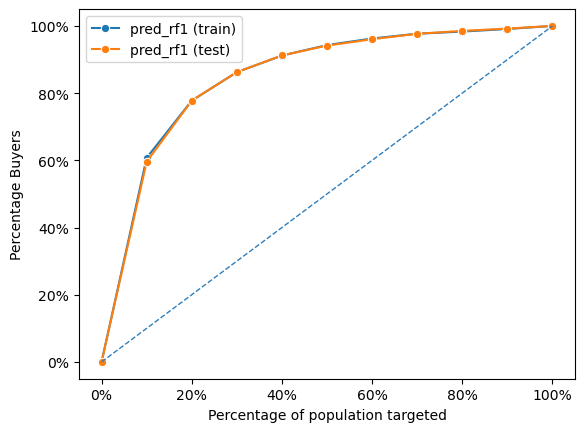

In [192]:
pentathlon_nptb_rf['pred_rf1'] = rf1_1.predict(pentathlon_nptb_rf)['prediction']

dct_rf1= {"train": pentathlon_nptb_rf[pentathlon_nptb_rf['training']==1], "test": pentathlon_nptb_rf[pentathlon_nptb_rf['training']==0]}
fig_rf1 = rsm.gains_plot(dct_rf1, "buyer", "yes", "pred_rf1")

In [193]:
pentathlon_nptb_rf_log_test = pentathlon_nptb_rf[pentathlon_nptb_rf['training'] == 0]

In [194]:
pentathlon_nptb_rf_log_test['p_endurance_rf'] = rf1_1.predict(pentathlon_nptb_rf_log_test, data_cmd={"message_endurance": 1 })["prediction"]
pentathlon_nptb_rf_log_test['p_strength_rf'] = rf1_1.predict(pentathlon_nptb_rf_log_test, data_cmd={"message_strength": 1 })["prediction"]
pentathlon_nptb_rf_log_test['p_water_rf'] = rf1_1.predict(pentathlon_nptb_rf_log_test, data_cmd={"message_water": 1 })["prediction"]
pentathlon_nptb_rf_log_test['p_team_rf'] = rf1_1.predict(pentathlon_nptb_rf_log_test, data_cmd={"message_team": 1 })["prediction"]
pentathlon_nptb_rf_log_test['p_backcountry_rf'] = rf1_1.predict(pentathlon_nptb_rf_log_test, data_cmd={"message_backcountry": 1 })["prediction"]
pentathlon_nptb_rf_log_test['p_racquet_rf'] = rf1_1.predict(pentathlon_nptb_rf_log_test, data_cmd={"message_racquet": 1 })["prediction"]
pentathlon_nptb_rf_log_test['p_control_rf'] = rf1_1.predict(pentathlon_nptb_rf_log_test, data_cmd={"message_control": 1 })["prediction"]
pentathlon_nptb_rf_log_test

/tmp/ipykernel_35906/3013672209.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pentathlon_nptb_rf_log_test['p_endurance_rf'] = rf1_1.predict(pentathlon_nptb_rf_log_test, data_cmd={"message_endurance": 1 })["prediction"]
/tmp/ipykernel_35906/3013672209.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pentathlon_nptb_rf_log_test['p_strength_rf'] = rf1_1.predict(pentathlon_nptb_rf_log_test, data_cmd={"message_strength": 1 })["prediction"]
/tmp/ipykernel_35906/3013672209.py:3: SettingWithCopyWarning: 
A

custid buyer  total_os female  income  education  children  \
1             U3    no         0      0   35000         22       1.0   
4            U25    no         0      1   65000         32       1.1   
6            U30    no         0      1   65000         62       0.5   
7            U55    no         0      0   35000         17       1.1   
15           U97    no         0      1   65000         40       0.7   
...          ...   ...       ...    ...     ...        ...       ...   
599991  U3462852    no         0      1   50000         19       1.1   
599994  U3462887    no         0      1   30000         14       0.9   
599996  U3462900    no         0      0   55000         32       0.9   
599998  U3462916    no         0      0   50000         35       0.6   
599999  U3462922    no         0      1   50000         25       0.7   

        freq_endurance  freq_strength  freq_water  ...  message_team  \
1                    0              0           0  ...             0   
4                    1              2           0  ...             0   
6                    1              5           0  ...             0   
7                    0              0           0  ...             0   
15                   4              6           1  ...             0   
...                ...            ...         ...  ...           ...   
599991               0              1           0  ...             0   
599994               1              0           0  ...             0   
599996               3              1           0  ...             1   
599998               2              2           0  ...             1   
599999               1              2           0  ...             0   

        message_water  pred_rf1  p_endurance_rf  p_strength_rf  p_water_rf  \
1                   0  0.004569        0.004571       0.004569    0.004569   
4                   0  0.020136        0.020139       0.020136    0.020136   
6                   0  0.068587        0.068587       0.068587    0.068593   
7                   0  0.004637        0.004638       0.004637    0.004637   
15                  0  0.042328        0.042328       0.042328    0.042328   
...               ...       ...             ...            ...         ...   
599991              1  0.007518        0.007518       0.007518    0.007518   
599994              0  0.004540        0.004541       0.004540    0.004540   
599996              0  0.013498        0.013498       0.013498    0.013498   
599998              0  0.010779        0.010779       0.010779    0.010779   
599999              0  0.007970        0.007970       0.007970    0.007970   

        p_team_rf  p_backcountry_rf  p_racquet_rf  p_control_rf  
1        0.004569          0.004569      0.004569      0.004569  
4        0.020142          0.020136      0.020136      0.020136  
6        0.068564          0.068587      0.068554      0.068587  
7        0.004637          0.004637      0.004637      0.004637  
15       0.042328          0.042328      0.042328      0.042328  
...           ...               ...           ...           ...  
599991   0.007518          0.007518      0.007518      0.007518  
599994   0.004540          0.004540      0.004540      0.004540  
599996   0.013498          0.013498      0.013498      0.013498  
599998   0.010779          0.010779      0.010779      0.010779  
599999   0.007970          0.007970      0.007970      0.007970  

[180000 rows x 32 columns]

In [195]:
#find best message for each customer
pentathlon_nptb_rf_log_test['best_message_rf'] = pentathlon_nptb_rf_log_test[['p_endurance_rf', 'p_strength_rf', 'p_water_rf', 'p_team_rf', 'p_backcountry_rf', 'p_racquet_rf', 'p_control_rf']].idxmax(axis=1).str.replace('p_', '').str.replace('_rf', '')
pentathlon_nptb_rf_log_test

/tmp/ipykernel_35906/2768954612.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pentathlon_nptb_rf_log_test['best_message_rf'] = pentathlon_nptb_rf_log_test[['p_endurance_rf', 'p_strength_rf', 'p_water_rf', 'p_team_rf', 'p_backcountry_rf', 'p_racquet_rf', 'p_control_rf']].idxmax(axis=1).str.replace('p_', '').str.replace('_rf', '')


custid buyer  total_os female  income  education  children  \
1             U3    no         0      0   35000         22       1.0   
4            U25    no         0      1   65000         32       1.1   
6            U30    no         0      1   65000         62       0.5   
7            U55    no         0      0   35000         17       1.1   
15           U97    no         0      1   65000         40       0.7   
...          ...   ...       ...    ...     ...        ...       ...   
599991  U3462852    no         0      1   50000         19       1.1   
599994  U3462887    no         0      1   30000         14       0.9   
599996  U3462900    no         0      0   55000         32       0.9   
599998  U3462916    no         0      0   50000         35       0.6   
599999  U3462922    no         0      1   50000         25       0.7   

        freq_endurance  freq_strength  freq_water  ...  message_water  \
1                    0              0           0  ...              0   
4                    1              2           0  ...              0   
6                    1              5           0  ...              0   
7                    0              0           0  ...              0   
15                   4              6           1  ...              0   
...                ...            ...         ...  ...            ...   
599991               0              1           0  ...              1   
599994               1              0           0  ...              0   
599996               3              1           0  ...              0   
599998               2              2           0  ...              0   
599999               1              2           0  ...              0   

        pred_rf1  p_endurance_rf  p_strength_rf  p_water_rf  p_team_rf  \
1       0.004569        0.004571       0.004569    0.004569   0.004569   
4       0.020136        0.020139       0.020136    0.020136   0.020142   
6       0.068587        0.068587       0.068587    0.068593   0.068564   
7       0.004637        0.004638       0.004637    0.004637   0.004637   
15      0.042328        0.042328       0.042328    0.042328   0.042328   
...          ...             ...            ...         ...        ...   
599991  0.007518        0.007518       0.007518    0.007518   0.007518   
599994  0.004540        0.004541       0.004540    0.004540   0.004540   
599996  0.013498        0.013498       0.013498    0.013498   0.013498   
599998  0.010779        0.010779       0.010779    0.010779   0.010779   
599999  0.007970        0.007970       0.007970    0.007970   0.007970   

        p_backcountry_rf  p_racquet_rf  p_control_rf  best_message_rf  
1               0.004569      0.004569      0.004569        endurance  
4               0.020136      0.020136      0.020136             team  
6               0.068587      0.068554      0.068587            water  
7               0.004637      0.004637      0.004637        endurance  
15              0.042328      0.042328      0.042328        endurance  
...                  ...           ...           ...              ...  
599991          0.007518      0.007518      0.007518        endurance  
599994          0.004540      0.004540      0.004540        endurance  
599996          0.013498      0.013498      0.013498        endurance  
599998          0.010779      0.010779      0.010779        endurance  
599999          0.007970      0.007970      0.007970        endurance  

[180000 rows x 33 columns]

In [196]:
pd.crosstab(index=pentathlon_nptb_rf_log_test.best_message_rf, columns="count").apply(rsm.format_nr)

col_0              count
best_message_rf         
backcountry            4
control            1,643
endurance        158,153
racquet              287
strength           4,222
team               4,960
water             10,731

Endurance here has the absolute majority at 158,153 customers, which is significantly more than the other message categories. 
The Water message, while significantly behind Endurance, is the second-highest assigned category.
Strenght and team are in the middle tier but their impact is far lower in comparison to the top 2. 
Control group is the best for about 1643 customers, suggesting that the Random Forest model believes there are some do-not-disturb customers in the customer base who do not want to see ads, and will organically purchase products. Insert comments


**RF**

2. For each message, report the percentage of customers for whom that message or no-
message  maximizes  their  probability  of  purchase.  Comment  on  the  distribution  of 
expected response across messages.

In [197]:
# Ensure all message types are included, even if their count is 0
all_messages = ['endurance', 'team', 'strength', 'water', 'backcountry', 'racquet', 'control']
percentages_msg_rf = pentathlon_nptb_rf_log_test['best_message_rf'].value_counts(normalize=True).reindex(all_messages, fill_value=0) * 100
percentages_msg_rf

best_message_rf
endurance      87.862778
team            2.755556
strength        2.345556
water           5.961667
backcountry     0.002222
racquet         0.159444
control         0.912778
Name: proportion, dtype: float64

The above is the distribution of expected response across messages.  

Endurance accounts for nearly 88% of the entire customer base. This overwhelming majority suggests that products in this category have universal appeal. 
Water is the next most effective message, but it is still 22 times less than the best message. 
Strength and team have minimal reach while backcountry, racquet and control are virtually irrelevant as the numbers aren't high enough to indicate a niche subset of customer worth targeting from an overall profit perspective. 

3. For  each  customer,  determine  the  message  (i.e.,  endurance,  strength,  water,  team, 
backcountry, racquet, or no-message) predicted to lead to the highest expected profit 
(COGS is 60%).

In [198]:
rf_os = rsm.rforest(
    data ={"pentathlon_nptb_rf": pentathlon_nptb_rf.query("training == 1 & buyer == 'yes'")},
    rvar ="total_os",
    evar = evar_rf,
    random_state=1234,
    mod_type= 'regression',
    max_depth = 5,
)
rf_os.summary()

Random Forest
Data                 : pentathlon_nptb_rf
Response variable    : total_os
Explanatory variables: income, education, children, freq_endurance, freq_strength, freq_water, freq_team, freq_backcountry, freq_racquet, message_control, message_endurance, message_racquet, message_strength, message_team, message_water, female, age_30_44, age_45_59, age_60a
OOB                  : True
Model type           : regression
Nr. of features      : (19, 19)
Nr. of observations  : 10,080
max_features         : sqrt (4)
n_estimators         : 100
min_samples_leaf     : 1
max_samples          : 1.0
random_state         : 1234
Model fit            :
      n     r2       mse     mae
  10080  0.065  3638.087  38.172
Extra arguments      : max_depth=5

Estimation data      :
 income  education  children  freq_endurance  freq_strength  freq_water  freq_team  freq_backcountry  freq_racquet  message_control  message_endurance  message_racquet  message_strength  message_team  message_water  age_30_44

In [199]:
import math 
features = math.sqrt(len(evar_rf))
features

4.358898943540674

In [200]:
param_gridrf = {
    #"n_estimators": list(range(500, 1000, 100)),
    "max_features": range(2, 7),
    "max_samples": np.arange(0.5, 0.9, 0.1)
}
param_gridrf

{'max_features': range(2, 7), 'max_samples': array([0.5, 0.6, 0.7, 0.8])}

In [201]:
import os
from sklearn.model_selection import KFold, GridSearchCV

if os.path.exists('cv-objects/cross-validation-object_rfos.pkl'):
    cvrfos = rsm.load_state('cv-objects/cross-validation-object_rfos.pkl')["cv"]
else:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1234)
    cvrfos = GridSearchCV(
        rf_os.fitted,
        param_gridrf,
        scoring={"r2": "r2", 'MAE':'neg_mean_absolute_error', 'MSE':'neg_mean_squared_error'},
        cv= kfold,
        n_jobs=5,
        refit="r2",
        verbose=5
    ).fit(rf_os.data_onehot, rf_os.data.total_os)
    
    if not os.path.exists('cv-objects'):
        os.mkdir('cv-objects')
    rsm.save_state({"cv": cvrfos}, 'cv-objects/cross-validation-object_rfos.pkl')

In [202]:
cvrfos.best_params_

{'max_features': 6, 'max_samples': 0.7}

In [203]:
rf_os_1 = rsm.rforest(
    data ={"pentathlon_nptb_rf": pentathlon_nptb_rf.query("training == 1 & buyer == 'yes'")},
    rvar ="total_os",
    evar = evar_rf,
    random_state=1234,
    mod_type= 'regression',
    max_depth = 5,
    **cvrfos.best_params_
    
)
rf_os_1.summary()

Random Forest
Data                 : pentathlon_nptb_rf
Response variable    : total_os
Explanatory variables: income, education, children, freq_endurance, freq_strength, freq_water, freq_team, freq_backcountry, freq_racquet, message_control, message_endurance, message_racquet, message_strength, message_team, message_water, female, age_30_44, age_45_59, age_60a
OOB                  : True
Model type           : regression
Nr. of features      : (19, 19)
Nr. of observations  : 10,080
max_features         : 6 (6)
n_estimators         : 100
min_samples_leaf     : 1
max_samples          : 0.7
random_state         : 1234
Model fit            :
      n     r2       mse     mae
  10080  0.068  3628.451  38.104
Extra arguments      : max_depth=5

Estimation data      :
 income  education  children  freq_endurance  freq_strength  freq_water  freq_team  freq_backcountry  freq_racquet  message_control  message_endurance  message_racquet  message_strength  message_team  message_water  age_30_44  a

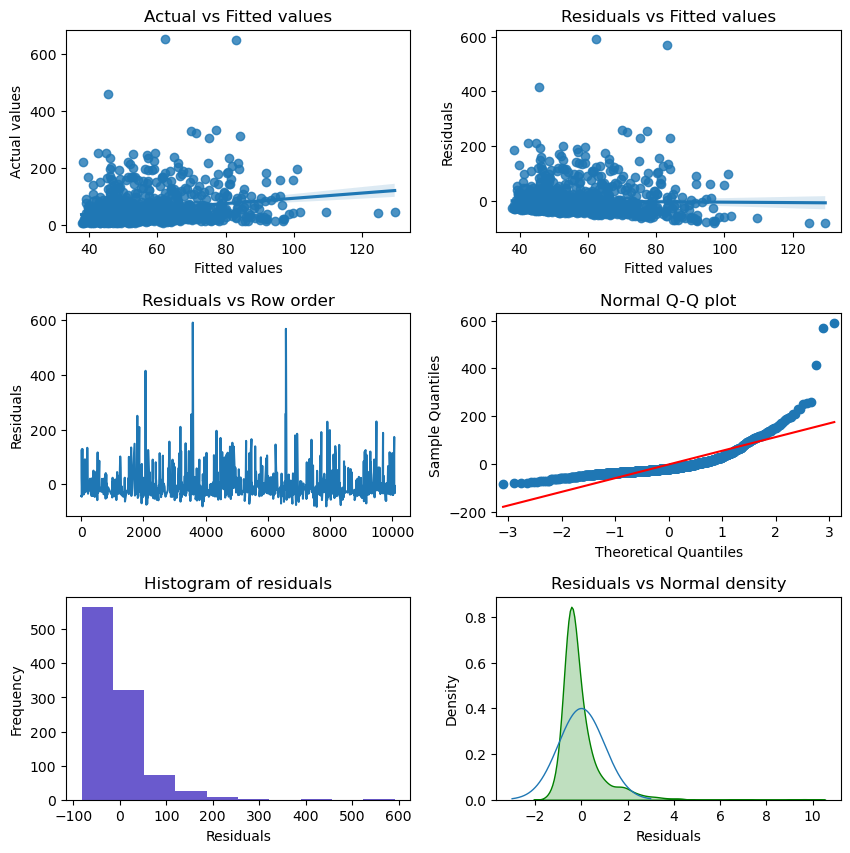

In [204]:
rf_os_1.plot("dashboard")

In [205]:
# predictions for total_os
pentathlon_nptb_rf['rf_os'] = rf_os_1.predict(pentathlon_nptb_rf)['prediction']
pentathlon_nptb_rf

custid buyer  total_os female  income  education  children  \
0             U1    no         0      0   55000         19       0.8   
1             U3    no         0      0   35000         22       1.0   
2            U13    no         0      1   45000         33       0.7   
3            U20    no         0      1   25000         24       0.2   
4            U25    no         0      1   65000         32       1.1   
...          ...   ...       ...    ...     ...        ...       ...   
599995  U3462888    no         0      1   40000         26       0.6   
599996  U3462900    no         0      0   55000         32       0.9   
599997  U3462902    no         0      1   55000         32       0.9   
599998  U3462916    no         0      0   50000         35       0.6   
599999  U3462922    no         0      1   50000         25       0.7   

        freq_endurance  freq_strength  freq_water  ...  age_45_59  age_60a  \
0                    0              4           0  ...          0        0   
1                    0              0           0  ...          1        0   
2                    0              0           0  ...          1        0   
3                    0              0           0  ...          1        0   
4                    1              2           0  ...          0        1   
...                ...            ...         ...  ...        ...      ...   
599995               0              0           0  ...          0        1   
599996               3              1           0  ...          0        0   
599997               0              5           0  ...          0        0   
599998               2              2           0  ...          0        0   
599999               1              2           0  ...          0        0   

        message_control  message_endurance  message_racquet  message_strength  \
0                     0                  0                0                 0   
1                     0                  0                0                 0   
2                     0                  1                0                 0   
3                     0                  0                0                 0   
4                     0                  0                1                 0   
...                 ...                ...              ...               ...   
599995                0                  0                0                 0   
599996                0                  0                0                 0   
599997                0                  0                0                 0   
599998                0                  0                0                 0   
599999                0                  1                0                 0   

        message_team  message_water  pred_rf1      rf_os  
0                  1              0  0.013189  38.833453  
1                  0              0  0.004569  43.157160  
2                  0              0  0.010148  51.046186  
3                  0              1  0.004382  42.757750  
4                  0              0  0.020136  46.833639  
...              ...            ...       ...        ...  
599995             0              1  0.004509  44.683191  
599996             1              0  0.013498  42.957726  
599997             1              0  0.016238  43.774025  
599998             1              0  0.010779  38.993100  
599999             0              0  0.007970  38.994524  

[600000 rows x 26 columns]

In [206]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

baseline_prediction = np.mean(pentathlon_nptb_rf[(pentathlon_nptb_rf['training']==1)&(pentathlon_nptb_rf['buyer']=='yes')]['total_os']) 
y_baseline = np.full_like(pentathlon_nptb_rf[(pentathlon_nptb_rf['training']==0)&(pentathlon_nptb_rf['buyer']=='yes')]['total_os'], baseline_prediction)
mse_baseline = mean_squared_error(pentathlon_nptb_rf[(pentathlon_nptb_rf['training']==0)&(pentathlon_nptb_rf['buyer']=='yes')]['total_os'], y_baseline)

mse_rf = mean_squared_error(pentathlon_nptb_rf[(pentathlon_nptb_rf['training']==0)&(pentathlon_nptb_rf['buyer']=='yes')]['total_os'], pentathlon_nptb_rf[(pentathlon_nptb_rf['training']==0)&(pentathlon_nptb_rf['buyer']=='yes')]['rf_os'])

mae_rf = mean_absolute_error(pentathlon_nptb_rf[(pentathlon_nptb_rf['training']==0)&(pentathlon_nptb_rf['buyer']=='yes')]['total_os'], pentathlon_nptb_rf[(pentathlon_nptb_rf['training']==0)&(pentathlon_nptb_rf['buyer']=='yes')]['rf_os'])
mae_baseline = mean_absolute_error(pentathlon_nptb_rf[(pentathlon_nptb_rf['training']==0)&(pentathlon_nptb_rf['buyer']=='yes')]['total_os'], y_baseline)

r2_rf = r2_score(pentathlon_nptb_rf[(pentathlon_nptb_rf['training']==0)&(pentathlon_nptb_rf['buyer']=='yes')]['total_os'], pentathlon_nptb_rf[(pentathlon_nptb_rf['training']==0)&(pentathlon_nptb_rf['buyer']=='yes')]['rf_os'])
r2_baseline = r2_score(pentathlon_nptb_rf[(pentathlon_nptb_rf['training']==0)&(pentathlon_nptb_rf['buyer']=='yes')]['total_os'], y_baseline)

print(f"Random Forest MSE: {mse_rf:.4f}, Baseline MSE: {mse_baseline:.4f}")
print(f"Random Forest MAE: {mae_rf:.4f}, Baseline MAE: {mae_baseline:.4f}")
print(f"Random Forest R² Score: {r2_rf:.4f}, Baseline R² Score: {r2_baseline:.4f}")

Random Forest MSE: 3587.7206, Baseline MSE: 3859.4333
Random Forest MAE: 37.6679, Baseline MAE: 39.5319
Random Forest R² Score: 0.0703, Baseline R² Score: -0.0001


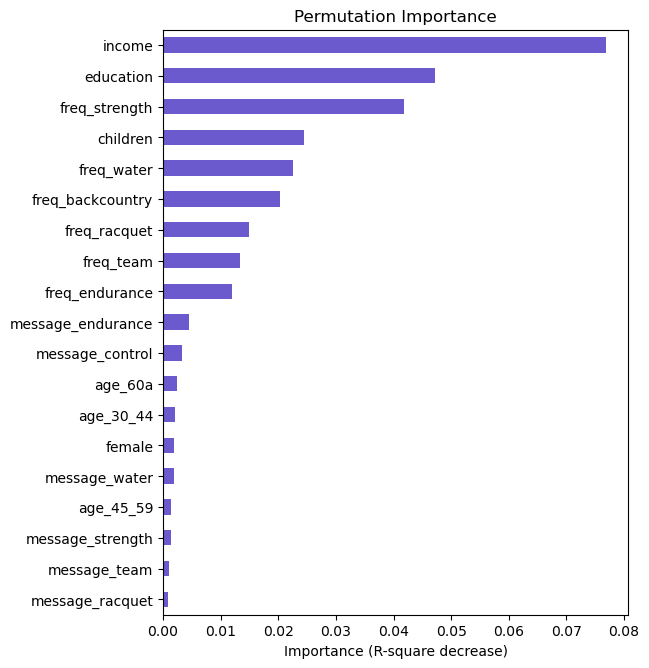

In [207]:
rf_os_1.plot("vimp")

Based on the results, the Random Forest model has an MSE of 3587.7206, which is slightly better than the baseline MSE of 3859.4333, and a MAE of 37.6679 compared to the baseline 39.5319. However, the R² score is very low (0.0703), and the baseline R² score is negative (-0.0001). This suggests that the model is only marginally better than the baseline but still has poor explanatory power.


We also look into the baselines on a per message basis, and the results are as follows:

In [208]:
pentathlon_nptb_rf = pentathlon_nptb_rf.merge(pentathlon_nptb[['custid', 'message']], on='custid', how='left')
pentathlon_nptb_rf

custid buyer  total_os female  income  education  children  \
0             U1    no         0      0   55000         19       0.8   
1             U3    no         0      0   35000         22       1.0   
2            U13    no         0      1   45000         33       0.7   
3            U20    no         0      1   25000         24       0.2   
4            U25    no         0      1   65000         32       1.1   
...          ...   ...       ...    ...     ...        ...       ...   
599995  U3462888    no         0      1   40000         26       0.6   
599996  U3462900    no         0      0   55000         32       0.9   
599997  U3462902    no         0      1   55000         32       0.9   
599998  U3462916    no         0      0   50000         35       0.6   
599999  U3462922    no         0      1   50000         25       0.7   

        freq_endurance  freq_strength  freq_water  ...  age_60a  \
0                    0              4           0  ...        0   
1                    0              0           0  ...        0   
2                    0              0           0  ...        0   
3                    0              0           0  ...        0   
4                    1              2           0  ...        1   
...                ...            ...         ...  ...      ...   
599995               0              0           0  ...        1   
599996               3              1           0  ...        0   
599997               0              5           0  ...        0   
599998               2              2           0  ...        0   
599999               1              2           0  ...        0   

        message_control  message_endurance  message_racquet  message_strength  \
0                     0                  0                0                 0   
1                     0                  0                0                 0   
2                     0                  1                0                 0   
3                     0                  0                0                 0   
4                     0                  0                1                 0   
...                 ...                ...              ...               ...   
599995                0                  0                0                 0   
599996                0                  0                0                 0   
599997                0                  0                0                 0   
599998                0                  0                0                 0   
599999                0                  1                0                 0   

        message_team  message_water  pred_rf1      rf_os      message  
0                  1              0  0.013189  38.833453         team  
1                  0              0  0.004569  43.157160  backcountry  
2                  0              0  0.010148  51.046186    endurance  
3                  0              1  0.004382  42.757750        water  
4                  0              0  0.020136  46.833639      racquet  
...              ...            ...       ...        ...          ...  
599995             0              1  0.004509  44.683191        water  
599996             1              0  0.013498  42.957726         team  
599997             1              0  0.016238  43.774025         team  
599998             1              0  0.010779  38.993100         team  
599999             0              0  0.007970  38.994524    endurance  

[600000 rows x 27 columns]

In [209]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

message_types = ['endurance', 'strength', 'water', 'team', 'backcountry', 'racquet', 'control']

for message in message_types:
    y_true = pentathlon_nptb_rf[(pentathlon_nptb_rf['training'] == 0)&(pentathlon_nptb_rf['buyer']=='yes')]['total_os']
    y_pred = pentathlon_nptb_rf_log_test[(pentathlon_nptb_rf_log_test['buyer']=='yes')][f'p_{message}_rf']
    
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"Message: {message.capitalize()}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    print("-" * 30)
    
    y_true_baseline = pentathlon_nptb_rf[(pentathlon_nptb_rf['training'] == 0)&(pentathlon_nptb_rf['buyer']=='yes')]['total_os']
    y_pred_baseline = np.full_like(y_true_baseline, baseline_prediction)

    mse_baseline = mean_squared_error(y_true_baseline, y_pred_baseline)
    mae_baseline = mean_absolute_error(y_true_baseline, y_pred_baseline)
    r2_baseline = r2_score(y_true_baseline, y_pred_baseline)

    print("Baseline Metrics")
    print(f"MSE: {mse_baseline:.4f}")
    print(f"MAE: {mae_baseline:.4f}")
    print(f"R² Score: {r2_baseline:.4f}")
    print("-" * 30) 


Message: Endurance
MSE: 7146.3519
MAE: 57.3636
R² Score: -0.8518
------------------------------
Baseline Metrics
MSE: 3859.4333
MAE: 39.5319
R² Score: -0.0001
------------------------------
Message: Strength
MSE: 7146.3865
MAE: 57.3638
R² Score: -0.8518
------------------------------
Baseline Metrics
MSE: 3859.4333
MAE: 39.5319
R² Score: -0.0001
------------------------------
Message: Water
MSE: 7146.3808
MAE: 57.3638
R² Score: -0.8518
------------------------------
Baseline Metrics
MSE: 3859.4333
MAE: 39.5319
R² Score: -0.0001
------------------------------
Message: Team
MSE: 7146.3895
MAE: 57.3638
R² Score: -0.8518
------------------------------
Baseline Metrics
MSE: 3859.4333
MAE: 39.5319
R² Score: -0.0001
------------------------------
Message: Backcountry
MSE: 7146.3897
MAE: 57.3639
R² Score: -0.8518
------------------------------
Baseline Metrics
MSE: 3859.4333
MAE: 39.5319
R² Score: -0.0001
------------------------------
Message: Racquet
MSE: 7146.4246
MAE: 57.3641
R² Score: -0.

The results indicate that none of the message types (Endurance, Strength, Water, Team, Backcountry, Racquet, Control) meaningfully improve the model’s performance. In fact, the MSE and R² scores are slightly worse than the baseline in all cases.

Key Takeaways:
The model is performing worse than the baseline (historical average).

The R² scores are negative, meaning the model is doing worse than simply predicting the mean.
The MSE values are slightly higher than the baseline.
Message types have no predictive power.

This aligns with the feature importance plot, where message-related variables had near-zero importance.
Including these variables is likely adding noise rather than improving predictions.


Due to the low R^2 of the total_os prediction model and the poor comparisons against baselines when filtered by message type, we will not use the predictions from the RF model for total_os.

In [210]:
pentathlon_nptb_rf_log_test

custid buyer  total_os female  income  education  children  \
1             U3    no         0      0   35000         22       1.0   
4            U25    no         0      1   65000         32       1.1   
6            U30    no         0      1   65000         62       0.5   
7            U55    no         0      0   35000         17       1.1   
15           U97    no         0      1   65000         40       0.7   
...          ...   ...       ...    ...     ...        ...       ...   
599991  U3462852    no         0      1   50000         19       1.1   
599994  U3462887    no         0      1   30000         14       0.9   
599996  U3462900    no         0      0   55000         32       0.9   
599998  U3462916    no         0      0   50000         35       0.6   
599999  U3462922    no         0      1   50000         25       0.7   

        freq_endurance  freq_strength  freq_water  ...  message_water  \
1                    0              0           0  ...              0   
4                    1              2           0  ...              0   
6                    1              5           0  ...              0   
7                    0              0           0  ...              0   
15                   4              6           1  ...              0   
...                ...            ...         ...  ...            ...   
599991               0              1           0  ...              1   
599994               1              0           0  ...              0   
599996               3              1           0  ...              0   
599998               2              2           0  ...              0   
599999               1              2           0  ...              0   

        pred_rf1  p_endurance_rf  p_strength_rf  p_water_rf  p_team_rf  \
1       0.004569        0.004571       0.004569    0.004569   0.004569   
4       0.020136        0.020139       0.020136    0.020136   0.020142   
6       0.068587        0.068587       0.068587    0.068593   0.068564   
7       0.004637        0.004638       0.004637    0.004637   0.004637   
15      0.042328        0.042328       0.042328    0.042328   0.042328   
...          ...             ...            ...         ...        ...   
599991  0.007518        0.007518       0.007518    0.007518   0.007518   
599994  0.004540        0.004541       0.004540    0.004540   0.004540   
599996  0.013498        0.013498       0.013498    0.013498   0.013498   
599998  0.010779        0.010779       0.010779    0.010779   0.010779   
599999  0.007970        0.007970       0.007970    0.007970   0.007970   

        p_backcountry_rf  p_racquet_rf  p_control_rf  best_message_rf  
1               0.004569      0.004569      0.004569        endurance  
4               0.020136      0.020136      0.020136             team  
6               0.068587      0.068554      0.068587            water  
7               0.004637      0.004637      0.004637        endurance  
15              0.042328      0.042328      0.042328        endurance  
...                  ...           ...           ...              ...  
599991          0.007518      0.007518      0.007518        endurance  
599994          0.004540      0.004540      0.004540        endurance  
599996          0.013498      0.013498      0.013498        endurance  
599998          0.010779      0.010779      0.010779        endurance  
599999          0.007970      0.007970      0.007970        endurance  

[180000 rows x 33 columns]

In [211]:
pred_response_rate_rf = pentathlon_nptb_rf_log_test.loc[pentathlon_nptb_rf_log_test.training == 0, ['p_endurance_rf', 'p_strength_rf', 'p_water_rf', 'p_team_rf', 'p_backcountry_rf', 'p_racquet_rf', 'p_control_rf']].agg("mean").sort_values(
    ascending=False
).apply(rsm.format_nr, perc=True)
pred_response_rate_rf

p_endurance_rf      2.41%
p_water_rf          2.41%
p_strength_rf       2.41%
p_team_rf           2.41%
p_backcountry_rf    2.41%
p_control_rf        2.41%
p_racquet_rf        2.41%
dtype: object

In [212]:
# Filter the dataset for buyers who responded "yes"
buyers_yes = pentathlon_nptb_log_test[pentathlon_nptb_log_test['buyer'] == 'yes']

# Calculate average order sizes for each message type based on past data
avg_order_sizes_rf = buyers_yes.groupby('message', observed=False)['total_os'].mean()
avg_order_sizes_rf

message
backcountry    59.091339
control        50.040984
endurance      53.686275
racquet        61.222597
strength       54.489185
team           60.122186
water          63.358578
Name: total_os, dtype: float64

In [213]:
profits_on_message_type_rf = avg_order_sizes_rf * 0.4
profits_on_message_type_rf

message
backcountry    23.636535
control        20.016393
endurance      21.474510
racquet        24.489039
strength       21.795674
team           24.048875
water          25.343431
Name: total_os, dtype: float64

In [214]:
# Calculate expected profit for each message type by multiplying the average order sizes with the profit
pentathlon_nptb_rf_log_test["ep_endurance_rf"] = pentathlon_nptb_rf_log_test.p_endurance_rf * profits_on_message_type_rf["endurance"]
pentathlon_nptb_rf_log_test["ep_strength_rf"] = pentathlon_nptb_rf_log_test.p_strength_rf * profits_on_message_type_rf["strength"]
pentathlon_nptb_rf_log_test["ep_water_rf"] = pentathlon_nptb_rf_log_test.p_water_rf * profits_on_message_type_rf["water"]
pentathlon_nptb_rf_log_test["ep_team_rf"] = pentathlon_nptb_rf_log_test.p_team_rf * profits_on_message_type_rf["team"]
pentathlon_nptb_rf_log_test["ep_backcountry_rf"] = pentathlon_nptb_rf_log_test.p_backcountry_rf * profits_on_message_type_rf["backcountry"]
pentathlon_nptb_rf_log_test["ep_racquet_rf"] = pentathlon_nptb_rf_log_test.p_racquet_rf * profits_on_message_type_rf["racquet"]
pentathlon_nptb_rf_log_test["ep_control_rf"] = pentathlon_nptb_rf_log_test.p_control_rf * profits_on_message_type_rf["control"]
pentathlon_nptb_rf_log_test


/tmp/ipykernel_35906/1531884213.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pentathlon_nptb_rf_log_test["ep_endurance_rf"] = pentathlon_nptb_rf_log_test.p_endurance_rf * profits_on_message_type_rf["endurance"]
/tmp/ipykernel_35906/1531884213.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pentathlon_nptb_rf_log_test["ep_strength_rf"] = pentathlon_nptb_rf_log_test.p_strength_rf * profits_on_message_type_rf["strength"]
/tmp/ipykernel_35906/1531884213.py:4: SettingWithCopyWarning: 
A value is tryin

custid buyer  total_os female  income  education  children  \
1             U3    no         0      0   35000         22       1.0   
4            U25    no         0      1   65000         32       1.1   
6            U30    no         0      1   65000         62       0.5   
7            U55    no         0      0   35000         17       1.1   
15           U97    no         0      1   65000         40       0.7   
...          ...   ...       ...    ...     ...        ...       ...   
599991  U3462852    no         0      1   50000         19       1.1   
599994  U3462887    no         0      1   30000         14       0.9   
599996  U3462900    no         0      0   55000         32       0.9   
599998  U3462916    no         0      0   50000         35       0.6   
599999  U3462922    no         0      1   50000         25       0.7   

        freq_endurance  freq_strength  freq_water  ...  p_racquet_rf  \
1                    0              0           0  ...      0.004569   
4                    1              2           0  ...      0.020136   
6                    1              5           0  ...      0.068554   
7                    0              0           0  ...      0.004637   
15                   4              6           1  ...      0.042328   
...                ...            ...         ...  ...           ...   
599991               0              1           0  ...      0.007518   
599994               1              0           0  ...      0.004540   
599996               3              1           0  ...      0.013498   
599998               2              2           0  ...      0.010779   
599999               1              2           0  ...      0.007970   

        p_control_rf  best_message_rf  ep_endurance_rf  ep_strength_rf  \
1           0.004569        endurance         0.098157        0.099592   
4           0.020136             team         0.432478        0.438875   
6           0.068587            water         1.472863        1.494891   
7           0.004637        endurance         0.099609        0.101066   
15          0.042328        endurance         0.908968        0.922563   
...              ...              ...              ...             ...   
599991      0.007518        endurance         0.161447        0.163861   
599994      0.004540        endurance         0.097520        0.098946   
599996      0.013498        endurance         0.289865        0.294200   
599998      0.010779        endurance         0.231466        0.234927   
599999      0.007970        endurance         0.171156        0.173716   

        ep_water_rf  ep_team_rf  ep_backcountry_rf  ep_racquet_rf  \
1          0.115803    0.109888           0.108004       0.111899   
4          0.510313    0.484396           0.475943       0.493109   
6          1.738379    1.648889           1.621149       1.678822   
7          0.117517    0.111514           0.109602       0.113555   
15         1.072731    1.017936           1.000482       1.036567   
...             ...         ...                ...            ...   
599991     0.190534    0.180801           0.177701       0.184110   
599994     0.115052    0.109175           0.107303       0.111173   
599996     0.342088    0.324614           0.319049       0.330556   
599998     0.273167    0.259214           0.254769       0.263958   
599999     0.201992    0.191674           0.188388       0.195183   

        ep_control_rf  
1            0.091462  
4            0.403048  
6            1.372873  
7            0.092815  
15           0.847250  
...               ...  
599991       0.150485  
599994       0.090868  
599996       0.270183  
599998       0.215749  
599999       0.159535  

[180000 rows x 40 columns]

In [215]:
repl = {"ep_endurance_rf": "endurance", "ep_strength_rf": "strength", "ep_water_rf": "water", "ep_team_rf": "team", "ep_backcountry_rf": "backcountry", "ep_racquet_rf": "racquet", "ep_control_rf": "control"}
pentathlon_nptb_rf_log_test['msg_ep_rf'] = pentathlon_nptb_rf_log_test[['ep_endurance_rf', 'ep_strength_rf', 'ep_water_rf', 'ep_team_rf', 'ep_backcountry_rf', 'ep_racquet_rf', 'ep_control_rf']].idxmax(axis=1).map(repl)

pentathlon_nptb_rf_log_test

/tmp/ipykernel_35906/2421114383.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pentathlon_nptb_rf_log_test['msg_ep_rf'] = pentathlon_nptb_rf_log_test[['ep_endurance_rf', 'ep_strength_rf', 'ep_water_rf', 'ep_team_rf', 'ep_backcountry_rf', 'ep_racquet_rf', 'ep_control_rf']].idxmax(axis=1).map(repl)


custid buyer  total_os female  income  education  children  \
1             U3    no         0      0   35000         22       1.0   
4            U25    no         0      1   65000         32       1.1   
6            U30    no         0      1   65000         62       0.5   
7            U55    no         0      0   35000         17       1.1   
15           U97    no         0      1   65000         40       0.7   
...          ...   ...       ...    ...     ...        ...       ...   
599991  U3462852    no         0      1   50000         19       1.1   
599994  U3462887    no         0      1   30000         14       0.9   
599996  U3462900    no         0      0   55000         32       0.9   
599998  U3462916    no         0      0   50000         35       0.6   
599999  U3462922    no         0      1   50000         25       0.7   

        freq_endurance  freq_strength  freq_water  ...  p_control_rf  \
1                    0              0           0  ...      0.004569   
4                    1              2           0  ...      0.020136   
6                    1              5           0  ...      0.068587   
7                    0              0           0  ...      0.004637   
15                   4              6           1  ...      0.042328   
...                ...            ...         ...  ...           ...   
599991               0              1           0  ...      0.007518   
599994               1              0           0  ...      0.004540   
599996               3              1           0  ...      0.013498   
599998               2              2           0  ...      0.010779   
599999               1              2           0  ...      0.007970   

        best_message_rf  ep_endurance_rf  ep_strength_rf  ep_water_rf  \
1             endurance         0.098157        0.099592     0.115803   
4                  team         0.432478        0.438875     0.510313   
6                 water         1.472863        1.494891     1.738379   
7             endurance         0.099609        0.101066     0.117517   
15            endurance         0.908968        0.922563     1.072731   
...                 ...              ...             ...          ...   
599991        endurance         0.161447        0.163861     0.190534   
599994        endurance         0.097520        0.098946     0.115052   
599996        endurance         0.289865        0.294200     0.342088   
599998        endurance         0.231466        0.234927     0.273167   
599999        endurance         0.171156        0.173716     0.201992   

        ep_team_rf  ep_backcountry_rf  ep_racquet_rf  ep_control_rf  msg_ep_rf  
1         0.109888           0.108004       0.111899       0.091462      water  
4         0.484396           0.475943       0.493109       0.403048      water  
6         1.648889           1.621149       1.678822       1.372873      water  
7         0.111514           0.109602       0.113555       0.092815      water  
15        1.017936           1.000482       1.036567       0.847250      water  
...            ...                ...            ...            ...        ...  
599991    0.180801           0.177701       0.184110       0.150485      water  
599994    0.109175           0.107303       0.111173       0.090868      water  
599996    0.324614           0.319049       0.330556       0.270183      water  
599998    0.259214           0.254769       0.263958       0.215749      water  
599999    0.191674           0.188388       0.195183       0.159535      water  

[180000 rows x 41 columns]

In [216]:
pentathlon_nptb_rf_log_test["ep_max_rf"] = pentathlon_nptb_rf_log_test[['ep_endurance_rf', 'ep_strength_rf', 'ep_water_rf', 'ep_team_rf', 'ep_backcountry_rf', 'ep_racquet_rf', 'ep_control_rf']].max(axis=1)
pentathlon_nptb_rf_log_test

/tmp/ipykernel_35906/305833973.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pentathlon_nptb_rf_log_test["ep_max_rf"] = pentathlon_nptb_rf_log_test[['ep_endurance_rf', 'ep_strength_rf', 'ep_water_rf', 'ep_team_rf', 'ep_backcountry_rf', 'ep_racquet_rf', 'ep_control_rf']].max(axis=1)


custid buyer  total_os female  income  education  children  \
1             U3    no         0      0   35000         22       1.0   
4            U25    no         0      1   65000         32       1.1   
6            U30    no         0      1   65000         62       0.5   
7            U55    no         0      0   35000         17       1.1   
15           U97    no         0      1   65000         40       0.7   
...          ...   ...       ...    ...     ...        ...       ...   
599991  U3462852    no         0      1   50000         19       1.1   
599994  U3462887    no         0      1   30000         14       0.9   
599996  U3462900    no         0      0   55000         32       0.9   
599998  U3462916    no         0      0   50000         35       0.6   
599999  U3462922    no         0      1   50000         25       0.7   

        freq_endurance  freq_strength  freq_water  ...  best_message_rf  \
1                    0              0           0  ...        endurance   
4                    1              2           0  ...             team   
6                    1              5           0  ...            water   
7                    0              0           0  ...        endurance   
15                   4              6           1  ...        endurance   
...                ...            ...         ...  ...              ...   
599991               0              1           0  ...        endurance   
599994               1              0           0  ...        endurance   
599996               3              1           0  ...        endurance   
599998               2              2           0  ...        endurance   
599999               1              2           0  ...        endurance   

        ep_endurance_rf  ep_strength_rf  ep_water_rf  ep_team_rf  \
1              0.098157        0.099592     0.115803    0.109888   
4              0.432478        0.438875     0.510313    0.484396   
6              1.472863        1.494891     1.738379    1.648889   
7              0.099609        0.101066     0.117517    0.111514   
15             0.908968        0.922563     1.072731    1.017936   
...                 ...             ...          ...         ...   
599991         0.161447        0.163861     0.190534    0.180801   
599994         0.097520        0.098946     0.115052    0.109175   
599996         0.289865        0.294200     0.342088    0.324614   
599998         0.231466        0.234927     0.273167    0.259214   
599999         0.171156        0.173716     0.201992    0.191674   

        ep_backcountry_rf  ep_racquet_rf  ep_control_rf  msg_ep_rf  ep_max_rf  
1                0.108004       0.111899       0.091462      water   0.115803  
4                0.475943       0.493109       0.403048      water   0.510313  
6                1.621149       1.678822       1.372873      water   1.738379  
7                0.109602       0.113555       0.092815      water   0.117517  
15               1.000482       1.036567       0.847250      water   1.072731  
...                   ...            ...            ...        ...        ...  
599991           0.177701       0.184110       0.150485      water   0.190534  
599994           0.107303       0.111173       0.090868      water   0.115052  
599996           0.319049       0.330556       0.270183      water   0.342088  
599998           0.254769       0.263958       0.215749      water   0.273167  
599999           0.188388       0.195183       0.159535      water   0.201992  

[180000 rows x 42 columns]

In [217]:
message_ep_counts_rf = pd.crosstab(index=pentathlon_nptb_rf_log_test.loc[pentathlon_nptb_rf_log_test.training == 0, "msg_ep_rf"], columns="count").reindex(['backcountry', 'control', 'endurance', 'racquet', 'strength', 'team', 'water'], fill_value=0).applymap(rsm.format_nr)
message_ep_counts_rf

/tmp/ipykernel_35906/2454845478.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  message_ep_counts_rf = pd.crosstab(index=pentathlon_nptb_rf_log_test.loc[pentathlon_nptb_rf_log_test.training == 0, "msg_ep_rf"], columns="count").reindex(['backcountry', 'control', 'endurance', 'racquet', 'strength', 'team', 'water'], fill_value=0).applymap(rsm.format_nr)


col_0          count
msg_ep_rf           
backcountry        0
control            0
endurance          0
racquet            0
strength           0
team               0
water        180,000

This distribution is unique in that it isn't a distribution, it's a complete monopoly. 
This shows that the best message to maximise profit is Water and it is that way for the entire consumer base. 
It is an unexpected shift from previous findings. 

4.  Report for each message, i.e., endurance, racket, etc., and no-message, the percentage 
of customers for whom that (no) message maximizes their expected profit. Comment on 
the distribution of expected profit across messages. 


In [218]:
message_ep_counts_rf['count'] = message_ep_counts_rf['count'].str.replace(',', '').astype(int)


In [219]:
#Calculate the percentage of customers for whom each message maximizes their expected profit
message_ep_percentages_rf = message_ep_counts_rf['count'] / message_ep_counts_rf['count'].sum() * 100

# Display the percentages
message_ep_percentages_rf.rename("percentage of customers", inplace=True)
message_ep_percentages_rf

message_ep_perc_rf = pd.DataFrame(
    {
        "message": message_ep_percentages_rf.index,
        "percentage of customers": message_ep_percentages_rf.values,
    }
)     

message_ep_perc_rf


message  percentage of customers
0  backcountry                      0.0
1      control                      0.0
2    endurance                      0.0
3      racquet                      0.0
4     strength                      0.0
5         team                      0.0
6        water                    100.0

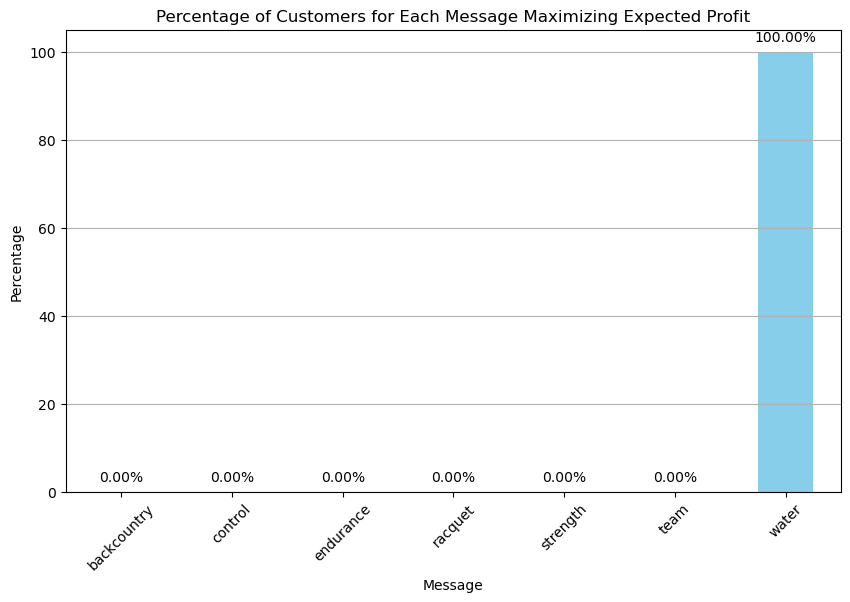

In [220]:
import matplotlib.pyplot as plt

# Plot the message_ep_percentages
ax = message_ep_percentages_rf.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Percentage of Customers for Each Message Maximizing Expected Profit')
plt.xlabel('Message')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Add percentage values on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

Random Forest model has exclusively chosen Water as the most profitable message.
No customers are assigned to endurance, strength, racquet, team, backcountry, or control. This is because all customers are equally likely of responding to each type of message. This could happen if the training data did not provide clear distinguishing factors for other messages.

5.  What  expected  profit  can  we  obtain,  on  average,  per  customer  if  we  customize  the 
message to each customer? Include no-message as an option as well. 


In [221]:
# Calculate the average expected profit per customer
average_expected_profit_rf = pentathlon_nptb_rf_log_test['ep_max_rf'].mean()
print(f"Average expected profit per customer: {average_expected_profit_rf:.2f} Euros")

Average expected profit per customer: 0.61 Euros


6.  What is the expected profit per e-mailed customer if every customer receives the same 
message?  Answer  this  question  for  each  of  the  possible  messages  (i.e.,  endurance, 
strength, water, team, backcountry, racquet) and the no-message option. Comment on 
the distribution of expected profit across messages and the no-message option. 


In [222]:
# Calculate the average expected profit for each message type
avg_ep_values_rf = pentathlon_nptb_rf_log_test[['ep_endurance_rf', 'ep_strength_rf', 'ep_water_rf', 'ep_team_rf', 'ep_backcountry_rf', 'ep_racquet_rf', 'ep_control_rf']].mean()

# Create a table to compare the values
avg_ep_table_rf = pd.DataFrame(avg_ep_values_rf, columns=['Expected Profit'])
avg_ep_table_rf.index = avg_ep_table_rf.index.str.replace('ep_', '').str.replace('_rf', '').str.capitalize()
avg_ep_table_rf

Expected Profit
Endurance           0.517680
Strength            0.524860
Water               0.610400
Team                0.579099
Backcountry         0.569139
Racquet             0.589390
Control             0.481776

Water messages (0.6103) generate the highest profit per customer, outperforming all other categories and suggests that customers that engage with this content are likely to have larger order sizes or buy higher value items. 
Racquet (0.58) and Team (0.579) emails also show high expected profits.
Endurance (0.517) performs worse than Water, racquet, team, and backcountry in terms of profit.
This suggests that Endurance messages lead to more purchases but lower-value orders.

Every message type outperforms the Control group (0.481), confirming that sending promotional emails is always better than not sending them.



7.  What is the expected profit per e-mailed customer if every customer is assigned randomly 
to one of the messages or the no-message condition?   


In [223]:
pentathlon_nptb_rf_log_test = pentathlon_nptb_rf_log_test.merge(pentathlon_nptb[['custid', 'message']], on='custid', how='left')
pentathlon_nptb_rf_log_test

custid buyer  total_os female  income  education  children  \
0             U3    no         0      0   35000         22       1.0   
1            U25    no         0      1   65000         32       1.1   
2            U30    no         0      1   65000         62       0.5   
3            U55    no         0      0   35000         17       1.1   
4            U97    no         0      1   65000         40       0.7   
...          ...   ...       ...    ...     ...        ...       ...   
179995  U3462852    no         0      1   50000         19       1.1   
179996  U3462887    no         0      1   30000         14       0.9   
179997  U3462900    no         0      0   55000         32       0.9   
179998  U3462916    no         0      0   50000         35       0.6   
179999  U3462922    no         0      1   50000         25       0.7   

        freq_endurance  freq_strength  freq_water  ...  ep_endurance_rf  \
0                    0              0           0  ...         0.098157   
1                    1              2           0  ...         0.432478   
2                    1              5           0  ...         1.472863   
3                    0              0           0  ...         0.099609   
4                    4              6           1  ...         0.908968   
...                ...            ...         ...  ...              ...   
179995               0              1           0  ...         0.161447   
179996               1              0           0  ...         0.097520   
179997               3              1           0  ...         0.289865   
179998               2              2           0  ...         0.231466   
179999               1              2           0  ...         0.171156   

        ep_strength_rf  ep_water_rf  ep_team_rf  ep_backcountry_rf  \
0             0.099592     0.115803    0.109888           0.108004   
1             0.438875     0.510313    0.484396           0.475943   
2             1.494891     1.738379    1.648889           1.621149   
3             0.101066     0.117517    0.111514           0.109602   
4             0.922563     1.072731    1.017936           1.000482   
...                ...          ...         ...                ...   
179995        0.163861     0.190534    0.180801           0.177701   
179996        0.098946     0.115052    0.109175           0.107303   
179997        0.294200     0.342088    0.324614           0.319049   
179998        0.234927     0.273167    0.259214           0.254769   
179999        0.173716     0.201992    0.191674           0.188388   

        ep_racquet_rf  ep_control_rf  msg_ep_rf  ep_max_rf      message  
0            0.111899       0.091462      water   0.115803  backcountry  
1            0.493109       0.403048      water   0.510313      racquet  
2            1.678822       1.372873      water   1.738379    endurance  
3            0.113555       0.092815      water   0.117517     strength  
4            1.036567       0.847250      water   1.072731    endurance  
...               ...            ...        ...        ...          ...  
179995       0.184110       0.150485      water   0.190534        water  
179996       0.111173       0.090868      water   0.115052      control  
179997       0.330556       0.270183      water   0.342088         team  
179998       0.263958       0.215749      water   0.273167         team  
179999       0.195183       0.159535      water   0.201992    endurance  

[180000 rows x 43 columns]

In [224]:
message_counts_rf = pentathlon_nptb_rf_log_test[pentathlon_nptb_rf_log_test.training == 0]['message'].value_counts()
print(message_counts_rf)

message
racquet        26316
backcountry    26179
control        26043
team           25942
water          25496
strength       25251
endurance      24773
Name: count, dtype: int64


In [225]:
# profits based on message col

pentathlon_nptb_rf_log_test['profits'] = pentathlon_nptb_rf_log_test['total_os'] * 0.4
pentathlon_nptb_rf_log_test


custid buyer  total_os female  income  education  children  \
0             U3    no         0      0   35000         22       1.0   
1            U25    no         0      1   65000         32       1.1   
2            U30    no         0      1   65000         62       0.5   
3            U55    no         0      0   35000         17       1.1   
4            U97    no         0      1   65000         40       0.7   
...          ...   ...       ...    ...     ...        ...       ...   
179995  U3462852    no         0      1   50000         19       1.1   
179996  U3462887    no         0      1   30000         14       0.9   
179997  U3462900    no         0      0   55000         32       0.9   
179998  U3462916    no         0      0   50000         35       0.6   
179999  U3462922    no         0      1   50000         25       0.7   

        freq_endurance  freq_strength  freq_water  ...  ep_strength_rf  \
0                    0              0           0  ...        0.099592   
1                    1              2           0  ...        0.438875   
2                    1              5           0  ...        1.494891   
3                    0              0           0  ...        0.101066   
4                    4              6           1  ...        0.922563   
...                ...            ...         ...  ...             ...   
179995               0              1           0  ...        0.163861   
179996               1              0           0  ...        0.098946   
179997               3              1           0  ...        0.294200   
179998               2              2           0  ...        0.234927   
179999               1              2           0  ...        0.173716   

        ep_water_rf  ep_team_rf  ep_backcountry_rf  ep_racquet_rf  \
0          0.115803    0.109888           0.108004       0.111899   
1          0.510313    0.484396           0.475943       0.493109   
2          1.738379    1.648889           1.621149       1.678822   
3          0.117517    0.111514           0.109602       0.113555   
4          1.072731    1.017936           1.000482       1.036567   
...             ...         ...                ...            ...   
179995     0.190534    0.180801           0.177701       0.184110   
179996     0.115052    0.109175           0.107303       0.111173   
179997     0.342088    0.324614           0.319049       0.330556   
179998     0.273167    0.259214           0.254769       0.263958   
179999     0.201992    0.191674           0.188388       0.195183   

        ep_control_rf  msg_ep_rf  ep_max_rf      message  profits  
0            0.091462      water   0.115803  backcountry      0.0  
1            0.403048      water   0.510313      racquet      0.0  
2            1.372873      water   1.738379    endurance      0.0  
3            0.092815      water   0.117517     strength      0.0  
4            0.847250      water   1.072731    endurance      0.0  
...               ...        ...        ...          ...      ...  
179995       0.150485      water   0.190534        water      0.0  
179996       0.090868      water   0.115052      control      0.0  
179997       0.270183      water   0.342088         team      0.0  
179998       0.215749      water   0.273167         team      0.0  
179999       0.159535      water   0.201992    endurance      0.0  

[180000 rows x 44 columns]

In [226]:
pentathlon_nptb_rf_log_test['profits'].mean()

0.5518799999999999

The expected profit per e-mailed customer if every customer is assigned randomly 
to one of the messages or the no-message condition is 0.55187 Euros 

8.  For the typical promotional e-mail blast to 5,000,000 customers, what improvement (in 
percent and in total Euros) could Pentathlon achieve by customizing the message (or no-
message) to each customer. Compare the performance predictions from this personalized 
approach to scenarios where (1) each customer is sent the same message selected based 
on average performance, (2) a random message assignment approach is used (i.e., the 
status quo), and (3) no message is sent (i.e., the control condition)? 

In [227]:
avg_profits_msg_rf = pentathlon_nptb_rf_log_test[['ep_endurance_rf', 'ep_strength_rf', 'ep_water_rf', 'ep_team_rf', 'ep_backcountry_rf', 'ep_racquet_rf']].mean()
avg_profits_msg_rf


ep_endurance_rf      0.517680
ep_strength_rf       0.524860
ep_water_rf          0.610400
ep_team_rf           0.579099
ep_backcountry_rf    0.569139
ep_racquet_rf        0.589390
dtype: float64

In [228]:
n = 5_000_000
extrpolated_p_rf = pentathlon_nptb_rf_log_test['ep_max_rf'].mean() * n #best scenario from targeting
extrpolated_p_rf

3051997.795138087

In [229]:

#1
avg_profits_max_rf = avg_profits_msg_rf.max()
e_profits1_rf = avg_profits_max_rf * n

print("Extrapolated profits based on each customer if sent the same message selected based on average performance: ", e_profits1_rf)
print("Improvement in profits (in Euros) if each customer is sent a personalized msg vs the same msg selected based on average performance: ",  extrpolated_p_rf - e_profits1_rf, "Euros")
print("Improvement in profits (in %) if each customer is sent a personalized msg vs the same msg selected based on average performance:  ",  (extrpolated_p_rf - e_profits1_rf) / e_profits1_rf * 100, "%")



Extrapolated profits based on each customer if sent the same message selected based on average performance:  3051997.795138087
Improvement in profits (in Euros) if each customer is sent a personalized msg vs the same msg selected based on average performance:  0.0 Euros
Improvement in profits (in %) if each customer is sent a personalized msg vs the same msg selected based on average performance:   0.0 %


In [230]:
#2
extrpolated_profit_random_rf = pentathlon_nptb_rf_log_test['profits'].mean() * n # profits extrapolated based on random assignment

print("Profit improvement (in %) by using the best message as compared to random messaging: ", (extrpolated_p_rf - extrpolated_profit_random_rf)/extrpolated_profit_random_rf * 100, "%")
print("Profit improvement (in Euros) by using the best message as compared to random messaging: ", extrpolated_p_rf - extrpolated_profit_random_rf, "Euros")


Profit improvement (in %) by using the best message as compared to random messaging:  10.603674535699342 %
Profit improvement (in Euros) by using the best message as compared to random messaging:  292597.7951380876 Euros


In [231]:
#3
avg_e_profit_control_rf = pentathlon_nptb_rf_log_test['ep_control_rf'].mean()
extrapolated_control_profit_rf = avg_e_profit_control_rf * n
print("extrapoltes profit by best message: ", extrpolated_p_rf)
print("Extrapolated profits based on control message: ", extrapolated_control_profit_rf)
print("Profit improvement (in Euros) by using the best message as compared to control message: ", extrpolated_p_rf - extrapolated_control_profit_rf, "Euros")
print("Profit improvement (in %) by using the best message as compared to control message: ", (extrpolated_p_rf - extrapolated_control_profit_rf) / extrapolated_control_profit_rf * 100, "%")


extrapoltes profit by best message:  3051997.795138087
Extrapolated profits based on control message:  2408878.5177651853
Profit improvement (in Euros) by using the best message as compared to control message:  643119.2773729018 Euros
Profit improvement (in %) by using the best message as compared to control message:  26.697870923335298 %


Overall Analysis:

Using best message selection per customer increases profit by 10.6% compared to random message assignment.
Randomly assigning emails is suboptimal, reinforcing the need for data-driven targeting.

Not sending any emails at all results in a massive profit loss.
Sending any promotional emails is always better than sending none, leading to a 26.7% improvement in profit over no-email strategies.

Assigning the best message per customer does not improve profits over sending a single best-performing message to all customers because the best message was solely Water for all consumers. comments

### XG BOOST

2. For each message, report the percentage of customers for whom that message or no-
message  maximizes  their  probability  of  purchase.  Comment  on  the  distribution  of 
expected response across messages.

In [232]:
## loading the data - this dataset must NOT be changed
pentathlon_nptb_xgb = pd.read_parquet("data/pentathlon_nptb_xgboost.parquet")
pentathlon_nptb_xgb.head()

custid buyer  total_os      message           age female  income  education  \
0     U1    no         0         team      30 to 44     no   55000         19   
1     U3    no         0  backcountry      45 to 59     no   35000         22   
2    U13    no         0    endurance      45 to 59    yes   45000         33   
3    U20    no         0        water      45 to 59    yes   25000         24   
4    U25    no         0      racquet  60 and older    yes   65000         32   

   children  freq_endurance  freq_strength  freq_water  freq_team  \
0       0.8               0              4           0          4   
1       1.0               0              0           0          1   
2       0.7               0              0           0          0   
3       0.2               0              0           0          0   
4       1.1               1              2           0          0   

   freq_backcountry  freq_racquet  training  
0                 0             1       1.0  
1                 0             0       0.0  
2                 2             2       1.0  
3                 0             0       1.0  
4                 2             2       0.0

In [233]:
# One hot encode 'message', 'age', and 'female' columns
pentathlon_nptb_xgb = pd.get_dummies(pentathlon_nptb_xgb, columns=['message', 'age'], drop_first=False)

# Rename columns
pentathlon_nptb_xgb.rename(columns={'30 to 44': '30_44', '45 to 59': '45_59', '60 and older': '60a'}, inplace=True)

# Display the transformed dataset
pentathlon_nptb_xgb.head()

custid buyer  total_os female  income  education  children  freq_endurance  \
0     U1    no         0     no   55000         19       0.8               0   
1     U3    no         0     no   35000         22       1.0               0   
2    U13    no         0    yes   45000         33       0.7               0   
3    U20    no         0    yes   25000         24       0.2               0   
4    U25    no         0    yes   65000         32       1.1               1   

   freq_strength  freq_water  ...  message_control  message_endurance  \
0              4           0  ...            False              False   
1              0           0  ...            False              False   
2              0           0  ...            False               True   
3              0           0  ...            False              False   
4              2           0  ...            False              False   

   message_racquet  message_strength  message_team  message_water  \
0            False             False          True          False   
1            False             False         False          False   
2            False             False         False          False   
3            False             False         False           True   
4             True             False         False          False   

   age_less than 30  age_30 to 44  age_45 to 59  age_60 and older  
0             False          True         False             False  
1             False         False          True             False  
2             False         False          True             False  
3             False         False          True             False  
4             False         False         False              True  

[5 rows x 25 columns]

In [234]:
#create a binary column for message_control, message_endurance, message_racquet, message_strength, message_team, message_water, age, female
binary_columns = ['message_backcountry',
       'message_control', 'message_endurance', 'message_racquet',
       'message_strength', 'message_team', 'message_water', 'age_less than 30',
       'age_30 to 44', 'age_45 to 59', 'age_60 and older'
       ]

for col in binary_columns:
    pentathlon_nptb_xgb[col] = pentathlon_nptb_xgb[col].astype(int)

pentathlon_nptb_xgb['female'] = pentathlon_nptb_xgb['female'].apply(lambda x: 1 if x == 'yes' else 0)
pentathlon_nptb_xgb

custid buyer  total_os female  income  education  children  \
0             U1    no         0      0   55000         19       0.8   
1             U3    no         0      0   35000         22       1.0   
2            U13    no         0      1   45000         33       0.7   
3            U20    no         0      1   25000         24       0.2   
4            U25    no         0      1   65000         32       1.1   
...          ...   ...       ...    ...     ...        ...       ...   
599995  U3462888    no         0      1   40000         26       0.6   
599996  U3462900    no         0      0   55000         32       0.9   
599997  U3462902    no         0      1   55000         32       0.9   
599998  U3462916    no         0      0   50000         35       0.6   
599999  U3462922    no         0      1   50000         25       0.7   

        freq_endurance  freq_strength  freq_water  ...  message_control  \
0                    0              4           0  ...                0   
1                    0              0           0  ...                0   
2                    0              0           0  ...                0   
3                    0              0           0  ...                0   
4                    1              2           0  ...                0   
...                ...            ...         ...  ...              ...   
599995               0              0           0  ...                0   
599996               3              1           0  ...                0   
599997               0              5           0  ...                0   
599998               2              2           0  ...                0   
599999               1              2           0  ...                0   

        message_endurance  message_racquet  message_strength  message_team  \
0                       0                0                 0             1   
1                       0                0                 0             0   
2                       1                0                 0             0   
3                       0                0                 0             0   
4                       0                1                 0             0   
...                   ...              ...               ...           ...   
599995                  0                0                 0             0   
599996                  0                0                 0             1   
599997                  0                0                 0             1   
599998                  0                0                 0             1   
599999                  1                0                 0             0   

        message_water  age_less than 30  age_30 to 44  age_45 to 59  \
0                   0                 0             1             0   
1                   0                 0             0             1   
2                   0                 0             0             1   
3                   1                 0             0             1   
4                   0                 0             0             0   
...               ...               ...           ...           ...   
599995              1                 0             0             0   
599996              0                 1             0             0   
599997              0                 1             0             0   
599998              0                 1             0             0   
599999              0                 0             1             0   

        age_60 and older  
0                      0  
1                      0  
2                      0  
3                      0  
4                      1  
...                  ...  
599995                 1  
599996                 0  
599997                 0  
599998                 0  
599999                 0  

[600000 rows x 25 columns]

In [235]:
pentathlon_nptb_xgb_train = pentathlon_nptb_xgb[pentathlon_nptb_xgb['training'] == 1]
pentathlon_nptb_xgb_test = pentathlon_nptb_xgb[pentathlon_nptb_xgb['training'] == 0]

In [236]:
pentathlon_nptb_xgb.columns

Index(['custid', 'buyer', 'total_os', 'female', 'income', 'education',
       'children', 'freq_endurance', 'freq_strength', 'freq_water',
       'freq_team', 'freq_backcountry', 'freq_racquet', 'training',
       'message_backcountry', 'message_control', 'message_endurance',
       'message_racquet', 'message_strength', 'message_team', 'message_water',
       'age_less than 30', 'age_30 to 44', 'age_45 to 59', 'age_60 and older'],
      dtype='object')

In [237]:
evar_xgb = ['income', 'education', 'children',
       'freq_endurance', 'freq_strength', 'freq_water', 'freq_team',
       'freq_backcountry', 'freq_racquet', 'message_backcountry',
       'message_control', 'message_endurance', 'message_racquet',
       'message_strength', 'message_team', 'message_water', 'age_less than 30',
       'age_30 to 44', 'age_45 to 59', 'age_60 and older', 'female']

In [238]:
xgb1 = rsm.model.xgboost(
    {"pentathlon_nptb_xgb_train": pentathlon_nptb_xgb_train},
    rvar="buyer",
    lev="yes",
    evar=evar_xgb,
    n_estimators=100,
    max_depth=5,
    random_state=1234,
)
xgb1.summary()

XGBoost
Data                 : pentathlon_nptb_xgb_train
Response variable    : buyer
Level                : yes
Explanatory variables: income, education, children, freq_endurance, freq_strength, freq_water, freq_team, freq_backcountry, freq_racquet, message_backcountry, message_control, message_endurance, message_racquet, message_strength, message_team, message_water, age_less than 30, age_30 to 44, age_45 to 59, age_60 and older, female
Model type           : classification
Nr. of features      : (21, 21)
Nr. of observations  : 420,000
n_estimators         : 100
max_depth            : 5
min_child_weight     : 1
learning_rate        : 0.3
subsample            : 1.0
colsample_bytree     : 1.0
random_state         : 1234
AUC                  : 0.903

Estimation data      :
 income  education  children  freq_endurance  freq_strength  freq_water  freq_team  freq_backcountry  freq_racquet  message_backcountry  message_control  message_endurance  message_racquet  message_strength  message_t

In [239]:
pentathlon_nptb_xgb['pred_logit_xgb1_c1'] = xgb1.predict(pentathlon_nptb_xgb)['prediction']
pentathlon_nptb_xgb.head()

custid buyer  total_os female  income  education  children  freq_endurance  \
0     U1    no         0      0   55000         19       0.8               0   
1     U3    no         0      0   35000         22       1.0               0   
2    U13    no         0      1   45000         33       0.7               0   
3    U20    no         0      1   25000         24       0.2               0   
4    U25    no         0      1   65000         32       1.1               1   

   freq_strength  freq_water  ...  message_endurance  message_racquet  \
0              4           0  ...                  0                0   
1              0           0  ...                  0                0   
2              0           0  ...                  1                0   
3              0           0  ...                  0                0   
4              2           0  ...                  0                1   

   message_strength  message_team  message_water  age_less than 30  \
0                 0             1              0                 0   
1                 0             0              0                 0   
2                 0             0              0                 0   
3                 0             0              1                 0   
4                 0             0              0                 0   

   age_30 to 44  age_45 to 59  age_60 and older  pred_logit_xgb1_c1  
0             1             0                 0            0.007414  
1             0             1                 0            0.001490  
2             0             1                 0            0.007871  
3             0             1                 0            0.000794  
4             0             0                 1            0.008743  

[5 rows x 26 columns]

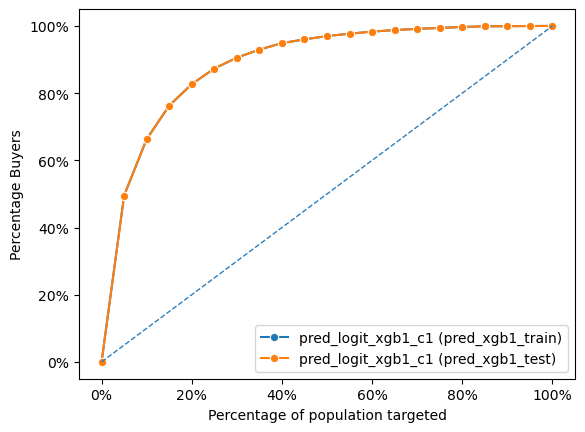

In [240]:
dct_xgb1 = {"pred_xgb1_train": pentathlon_nptb_xgb.query("training == 1"), "pred_xgb1_test": pentathlon_nptb_xgb.query("training == 1")}
fig_xgb1 = rsm.gains_plot(dct_xgb1, "buyer", "yes", 'pred_logit_xgb1_c1', qnt=20)

In [241]:
import numpy as np

param_grid = {
    'n_estimators': np.arange(1, 200, 50),
    'max_depth': np.arange(2,6,1)
    
}
param_grid

{'n_estimators': array([  1,  51, 101, 151]), 'max_depth': array([2, 3, 4, 5])}

In [242]:
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

if os.path.exists('cv-objects/cross-validation-object_xgb1.pkl'):
    cvxgb=rsm.load_state('cv-objects/cross-validation-object_xgb1.pkl')["cv"]
else:
    stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
    cvxgb=GridSearchCV(xgb1.fitted, param_grid, scoring = {"AUC": "roc_auc"}, cv=stratified_k_fold, n_jobs=5,refit="AUC", verbose=5).fit(xgb1.data_onehot, xgb1.data.buyer)
    if not os.path.exists('cv-objects'):
        os.mkdir('cv-objects')
    rsm.save_state({"cv": cvxgb},'cv-objects/cross-validation-object_xgb1.pkl')

In [243]:
cvxgb.best_params_

{'max_depth': 5, 'n_estimators': 51}

In [244]:
xgb1_1 = rsm.model.xgboost(
    {"pentathlon_nptb_xgb_train": pentathlon_nptb_xgb_train},
    rvar="buyer",
    lev="yes",
    evar=evar_xgb,
    random_state=1234,
    **cvxgb.best_params_,
)
xgb1_1.summary()

XGBoost
Data                 : pentathlon_nptb_xgb_train
Response variable    : buyer
Level                : yes
Explanatory variables: income, education, children, freq_endurance, freq_strength, freq_water, freq_team, freq_backcountry, freq_racquet, message_backcountry, message_control, message_endurance, message_racquet, message_strength, message_team, message_water, age_less than 30, age_30 to 44, age_45 to 59, age_60 and older, female
Model type           : classification
Nr. of features      : (21, 21)
Nr. of observations  : 420,000
n_estimators         : 51
max_depth            : 5
min_child_weight     : 1
learning_rate        : 0.3
subsample            : 1.0
colsample_bytree     : 1.0
random_state         : 1234
AUC                  : 0.899

Estimation data      :
 income  education  children  freq_endurance  freq_strength  freq_water  freq_team  freq_backcountry  freq_racquet  message_backcountry  message_control  message_endurance  message_racquet  message_strength  message_te

In [245]:
pentathlon_nptb_xgb['pred_logit_xgb1_1'] = xgb1_1.predict(pentathlon_nptb_xgb)['prediction']
pentathlon_nptb_xgb.head()

custid buyer  total_os female  income  education  children  freq_endurance  \
0     U1    no         0      0   55000         19       0.8               0   
1     U3    no         0      0   35000         22       1.0               0   
2    U13    no         0      1   45000         33       0.7               0   
3    U20    no         0      1   25000         24       0.2               0   
4    U25    no         0      1   65000         32       1.1               1   

   freq_strength  freq_water  ...  message_racquet  message_strength  \
0              4           0  ...                0                 0   
1              0           0  ...                0                 0   
2              0           0  ...                0                 0   
3              0           0  ...                0                 0   
4              2           0  ...                1                 0   

   message_team  message_water  age_less than 30  age_30 to 44  age_45 to 59  \
0             1              0                 0             1             0   
1             0              0                 0             0             1   
2             0              0                 0             0             1   
3             0              1                 0             0             1   
4             0              0                 0             0             0   

   age_60 and older  pred_logit_xgb1_c1  pred_logit_xgb1_1  
0                 0            0.007414           0.011256  
1                 0            0.001490           0.001753  
2                 0            0.007871           0.007950  
3                 0            0.000794           0.001097  
4                 1            0.008743           0.009879  

[5 rows x 27 columns]

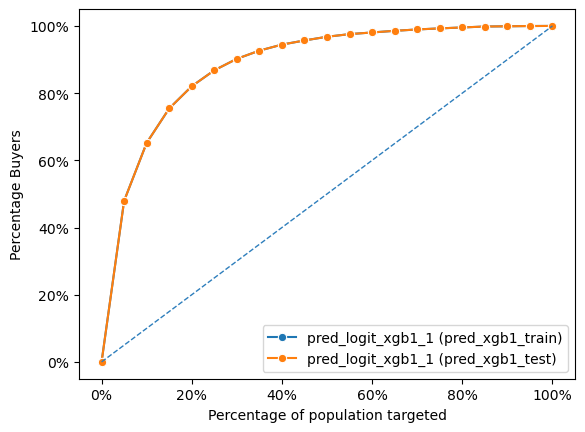

In [246]:
dct_xgb1 = {"pred_xgb1_train": pentathlon_nptb_xgb.query("training == 1"), "pred_xgb1_test": pentathlon_nptb_xgb.query("training == 1")}
fig_xgb1 = rsm.gains_plot(dct_xgb1, "buyer", "yes", 'pred_logit_xgb1_1', qnt=20)

In [247]:
pentathlon_nptb_xgb_test['p_endurance'] = xgb1.predict(pentathlon_nptb_xgb_test, data_cmd={"message_endurance": 1 })["prediction"]
pentathlon_nptb_xgb_test['p_strength'] = xgb1.predict(pentathlon_nptb_xgb_test, data_cmd={"message_strength": 1 })["prediction"]
pentathlon_nptb_xgb_test['p_water'] = xgb1.predict(pentathlon_nptb_xgb_test, data_cmd={"message_water": 1 })["prediction"]
pentathlon_nptb_xgb_test['p_team'] = xgb1.predict(pentathlon_nptb_xgb_test, data_cmd={"message_team": 1 })["prediction"]
pentathlon_nptb_xgb_test['p_backcountry'] = xgb1.predict(pentathlon_nptb_xgb_test, data_cmd={"message_backcountry": 1 })["prediction"]
pentathlon_nptb_xgb_test['p_racquet'] = xgb1.predict(pentathlon_nptb_xgb_test, data_cmd={"message_racquet": 1 })["prediction"]
pentathlon_nptb_xgb_test['p_control'] = xgb1.predict(pentathlon_nptb_xgb_test, data_cmd={"message_control": 1 })["prediction"]
pentathlon_nptb_xgb_test


/tmp/ipykernel_35906/2833433448.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pentathlon_nptb_xgb_test['p_endurance'] = xgb1.predict(pentathlon_nptb_xgb_test, data_cmd={"message_endurance": 1 })["prediction"]
/tmp/ipykernel_35906/2833433448.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pentathlon_nptb_xgb_test['p_strength'] = xgb1.predict(pentathlon_nptb_xgb_test, data_cmd={"message_strength": 1 })["prediction"]
/tmp/ipykernel_35906/2833433448.py:3: SettingWithCopyWarning: 
A value is trying to 

custid buyer  total_os female  income  education  children  \
1             U3    no         0      0   35000         22       1.0   
4            U25    no         0      1   65000         32       1.1   
6            U30    no         0      1   65000         62       0.5   
7            U55    no         0      0   35000         17       1.1   
15           U97    no         0      1   65000         40       0.7   
...          ...   ...       ...    ...     ...        ...       ...   
599991  U3462852    no         0      1   50000         19       1.1   
599994  U3462887    no         0      1   30000         14       0.9   
599996  U3462900    no         0      0   55000         32       0.9   
599998  U3462916    no         0      0   50000         35       0.6   
599999  U3462922    no         0      1   50000         25       0.7   

        freq_endurance  freq_strength  freq_water  ...  age_30 to 44  \
1                    0              0           0  ...             0   
4                    1              2           0  ...             0   
6                    1              5           0  ...             0   
7                    0              0           0  ...             1   
15                   4              6           1  ...             0   
...                ...            ...         ...  ...           ...   
599991               0              1           0  ...             1   
599994               1              0           0  ...             0   
599996               3              1           0  ...             0   
599998               2              2           0  ...             0   
599999               1              2           0  ...             1   

        age_45 to 59  age_60 and older  p_endurance  p_strength   p_water  \
1                  1                 0     0.002229    0.001829  0.001521   
4                  0                 1     0.010954    0.007624  0.008709   
6                  0                 0     0.065856    0.073830  0.060575   
7                  0                 0     0.001630    0.000868  0.000886   
15                 0                 0     0.013611    0.012607  0.013763   
...              ...               ...          ...         ...       ...   
599991             0                 0     0.004432    0.004722  0.003948   
599994             0                 0     0.003069    0.001591  0.001426   
599996             0                 0     0.003755    0.003579  0.003346   
599998             0                 0     0.003609    0.003673  0.003352   
599999             0                 0     0.009704    0.011386  0.008851   

          p_team  p_backcountry  p_racquet  p_control  
1       0.001497       0.001490   0.001490   0.001447  
4       0.009097       0.008743   0.008743   0.007871  
6       0.065856       0.062730   0.056322   0.056171  
7       0.000872       0.000908   0.000874   0.000718  
15      0.013611       0.013226   0.012921   0.013225  
...          ...            ...        ...        ...  
599991  0.003965       0.003656   0.004546   0.003373  
599994  0.001484       0.001300   0.001868   0.001426  
599996  0.003582       0.003268   0.003582   0.003247  
599998  0.003676       0.003450   0.003676   0.003540  
599999  0.010097       0.009248   0.011082   0.009693  

[180000 rows x 32 columns]

In [248]:
#find best message for each customer
pentathlon_nptb_xgb_test['best_message_xgb'] = pentathlon_nptb_xgb_test[['p_endurance', 'p_strength', 'p_water', 'p_team', 'p_backcountry', 'p_racquet', 'p_control']].idxmax(axis=1).str.replace('p_', '')
pentathlon_nptb_xgb_test

/tmp/ipykernel_35906/1402964695.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pentathlon_nptb_xgb_test['best_message_xgb'] = pentathlon_nptb_xgb_test[['p_endurance', 'p_strength', 'p_water', 'p_team', 'p_backcountry', 'p_racquet', 'p_control']].idxmax(axis=1).str.replace('p_', '')


custid buyer  total_os female  income  education  children  \
1             U3    no         0      0   35000         22       1.0   
4            U25    no         0      1   65000         32       1.1   
6            U30    no         0      1   65000         62       0.5   
7            U55    no         0      0   35000         17       1.1   
15           U97    no         0      1   65000         40       0.7   
...          ...   ...       ...    ...     ...        ...       ...   
599991  U3462852    no         0      1   50000         19       1.1   
599994  U3462887    no         0      1   30000         14       0.9   
599996  U3462900    no         0      0   55000         32       0.9   
599998  U3462916    no         0      0   50000         35       0.6   
599999  U3462922    no         0      1   50000         25       0.7   

        freq_endurance  freq_strength  freq_water  ...  age_45 to 59  \
1                    0              0           0  ...             1   
4                    1              2           0  ...             0   
6                    1              5           0  ...             0   
7                    0              0           0  ...             0   
15                   4              6           1  ...             0   
...                ...            ...         ...  ...           ...   
599991               0              1           0  ...             0   
599994               1              0           0  ...             0   
599996               3              1           0  ...             0   
599998               2              2           0  ...             0   
599999               1              2           0  ...             0   

        age_60 and older  p_endurance  p_strength   p_water    p_team  \
1                      0     0.002229    0.001829  0.001521  0.001497   
4                      1     0.010954    0.007624  0.008709  0.009097   
6                      0     0.065856    0.073830  0.060575  0.065856   
7                      0     0.001630    0.000868  0.000886  0.000872   
15                     0     0.013611    0.012607  0.013763  0.013611   
...                  ...          ...         ...       ...       ...   
599991                 0     0.004432    0.004722  0.003948  0.003965   
599994                 0     0.003069    0.001591  0.001426  0.001484   
599996                 0     0.003755    0.003579  0.003346  0.003582   
599998                 0     0.003609    0.003673  0.003352  0.003676   
599999                 0     0.009704    0.011386  0.008851  0.010097   

        p_backcountry  p_racquet  p_control  best_message_xgb  
1            0.001490   0.001490   0.001447         endurance  
4            0.008743   0.008743   0.007871         endurance  
6            0.062730   0.056322   0.056171          strength  
7            0.000908   0.000874   0.000718         endurance  
15           0.013226   0.012921   0.013225             water  
...               ...        ...        ...               ...  
599991       0.003656   0.004546   0.003373          strength  
599994       0.001300   0.001868   0.001426         endurance  
599996       0.003268   0.003582   0.003247         endurance  
599998       0.003450   0.003676   0.003540              team  
599999       0.009248   0.011082   0.009693          strength  

[180000 rows x 33 columns]

In [249]:
pd.crosstab(index=pentathlon_nptb_xgb_test[pentathlon_nptb_xgb_test.training == 0].best_message_xgb, columns="count").apply(rsm.format_nr)

col_0              count
best_message_xgb        
backcountry       13,765
control           11,011
endurance         94,707
racquet           11,264
strength          42,579
team               3,207
water              3,467

2. For each message, report the percentage of customers for whom that message or no-
message  maximizes  their  probability  of  purchase.  Comment  on  the  distribution  of 
expected response across messages.

In [250]:
# Ensure all message types are included, even if their count is 0
all_messages = ['endurance', 'team', 'strength', 'water', 'backcountry', 'racquet', 'control']
percentage_msg_xgb = pentathlon_nptb_xgb_test['best_message_xgb'].value_counts(normalize=True).reindex(all_messages, fill_value=0) * 100
percentage_msg_xgb

best_message_xgb
endurance      52.615000
team            1.781667
strength       23.655000
water           1.926111
backcountry     7.647222
racquet         6.257778
control         6.117222
Name: proportion, dtype: float64

Over 52.6% of all customers are assigned the Endurance message.
This suggests that Endurance-related promotions are the most profitable for the majority of customers.

Strength messages account for 23.6% of all assignments.
This suggests that a large secondary customer segment responds best to Strength-related promotions.

7.6% of customers are assigned Backcountry, and 6.3% are assigned Racquet.
These numbers indicate that these categories hold some profitable customer segments, but they are far less dominant than Endurance or Strength.

Only 1.9% (Water) and 1.8% (Team) of customers are assigned these messages.
This suggests that Water and Team messages are the least profitable compared to others.

6.1% of customers are assigned to the control group which likely implies that XGB identified some customers to be do-not-disturbs. 

3. For  each  customer,  determine  the  message  (i.e.,  endurance,  strength,  water,  team, 
backcountry, racquet, or no-message) predicted to lead to the highest expected profit 
(COGS is 60%).

In [251]:
xgb1_os = rsm.xgboost(
    {"pentathlon_nptb_xgb_os_train": pentathlon_nptb_xgb_train.query("buyer == 'yes'")},
    rvar="total_os",
    evar=evar_xgb,
    n_estimators=100,
    max_depth=5,
    random_state=1234,
    mod_type= 'regression',

)
xgb1_os.summary()

XGBoost
Data                 : pentathlon_nptb_xgb_os_train
Response variable    : total_os
Explanatory variables: income, education, children, freq_endurance, freq_strength, freq_water, freq_team, freq_backcountry, freq_racquet, message_backcountry, message_control, message_endurance, message_racquet, message_strength, message_team, message_water, age_less than 30, age_30 to 44, age_45 to 59, age_60 and older, female
Model type           : regression
Nr. of features      : (21, 21)
Nr. of observations  : 10,080
n_estimators         : 100
max_depth            : 5
min_child_weight     : 1
learning_rate        : 0.3
subsample            : 1.0
colsample_bytree     : 1.0
random_state         : 1234
Model fit            :
      n     r2       mse    mae
  10080  0.466  2077.139  29.47

Estimation data      :
 income  education  children  freq_endurance  freq_strength  freq_water  freq_team  freq_backcountry  freq_racquet  message_backcountry  message_control  message_endurance  message_racq

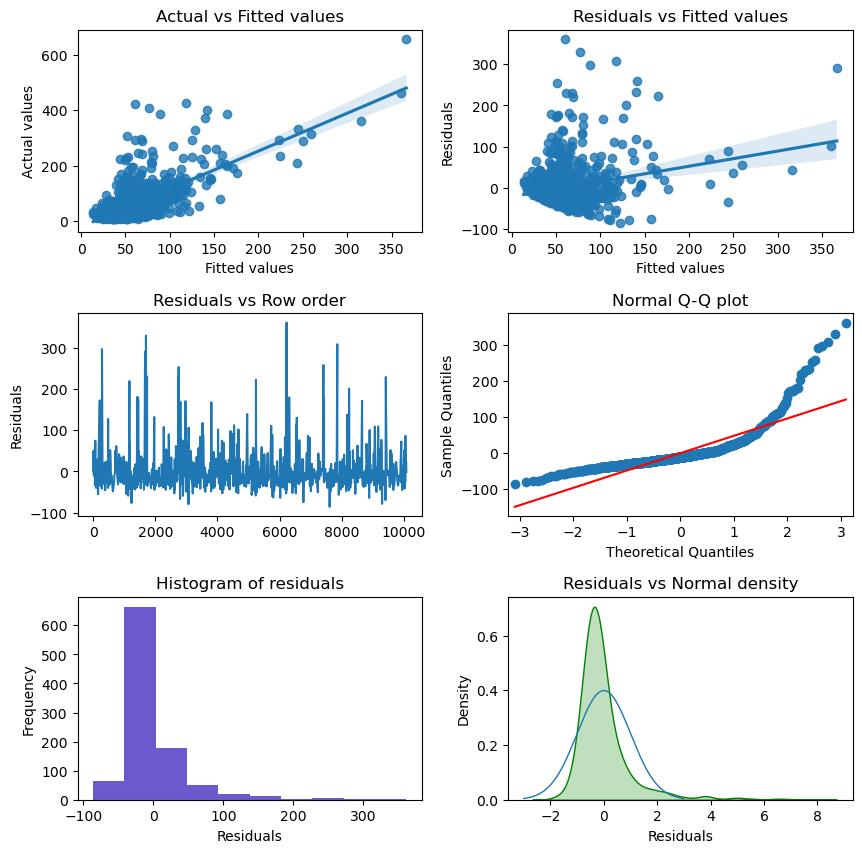

In [252]:
xgb1_os.plot('dashboard')

In [253]:
import numpy as np

param_grid_xgb = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': np.arange(1,7,1)
    
}
param_grid_xgb

{'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
 'max_depth': array([1, 2, 3, 4, 5, 6])}

The features to tune are decided as: 
learning rate - as it had the biggest impact on mae and mse and r2 by controlling convergence
max depth - influences overfitting & underfitting affecting the model's ability to generalize

In [254]:
import os
from sklearn.model_selection import KFold, GridSearchCV

if os.path.exists('cv-objects/cross-validation-object_xgbos.pkl'):
    cvxgbos = rsm.load_state('cv-objects/cross-validation-object_xgbos.pkl')["cv"]
else:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1234)
    cvxgbos = GridSearchCV(
        xgb1_os.fitted,
        param_grid_xgb,
        scoring={"r2": "r2", 'MAE':'neg_mean_absolute_error', 'MSE':'neg_mean_squared_error'},
        cv= kfold,
        n_jobs=5,
        refit="r2",
        verbose=5
    ).fit(xgb1_os.data_onehot, xgb1_os.data.total_os)
    
    if not os.path.exists('cv-objects'):
        os.mkdir('cv-objects')
    rsm.save_state({"cv": cvxgbos}, 'cv-objects/cross-validation-object_xgbos.pkl')

In [255]:
cvxgbos.best_params_

{'learning_rate': 0.2, 'max_depth': 1}

In [256]:
xgb1_os_1 = rsm.xgboost(
    {"pentathlon_nptb_xgb_os_train": pentathlon_nptb_xgb_train.query("buyer == 'yes'")},
    rvar="total_os",
    evar=evar_xgb,
    n_estimators=100,
    random_state=1234,
    mod_type= 'regression',
    **cvxgbos.best_params_,

)
xgb1_os_1.summary()

XGBoost
Data                 : pentathlon_nptb_xgb_os_train
Response variable    : total_os
Explanatory variables: income, education, children, freq_endurance, freq_strength, freq_water, freq_team, freq_backcountry, freq_racquet, message_backcountry, message_control, message_endurance, message_racquet, message_strength, message_team, message_water, age_less than 30, age_30 to 44, age_45 to 59, age_60 and older, female
Model type           : regression
Nr. of features      : (21, 21)
Nr. of observations  : 10,080
n_estimators         : 100
max_depth            : 1
min_child_weight     : 1
learning_rate        : 0.2
subsample            : 1.0
colsample_bytree     : 1.0
random_state         : 1234
Model fit            :
      n     r2       mse     mae
  10080  0.091  3538.245  37.471

Estimation data      :
 income  education  children  freq_endurance  freq_strength  freq_water  freq_team  freq_backcountry  freq_racquet  message_backcountry  message_control  message_endurance  message_ra

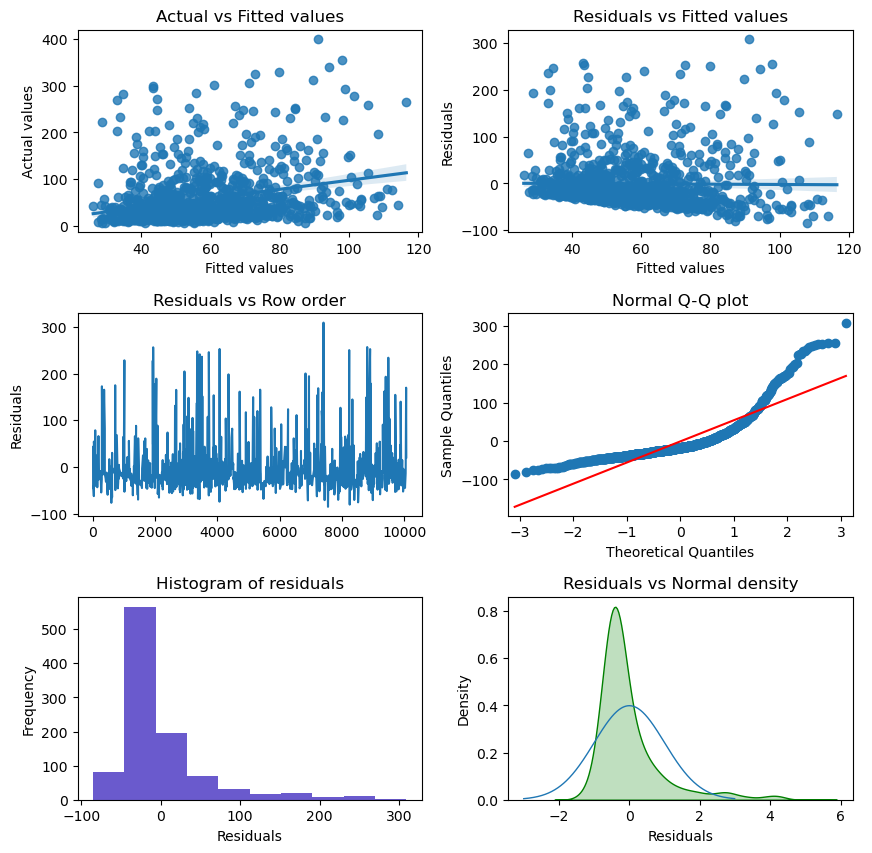

In [257]:
xgb1_os_1.plot('dashboard')

In [258]:
pentathlon_nptb_xgb_test['pred_logit_xgb1_os_1'] = xgb1_os_1.predict(pentathlon_nptb_xgb_test)['prediction']
pentathlon_nptb_xgb_test.head()

/tmp/ipykernel_35906/2309819370.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pentathlon_nptb_xgb_test['pred_logit_xgb1_os_1'] = xgb1_os_1.predict(pentathlon_nptb_xgb_test)['prediction']


custid buyer  total_os female  income  education  children  freq_endurance  \
1      U3    no         0      0   35000         22       1.0               0   
4     U25    no         0      1   65000         32       1.1               1   
6     U30    no         0      1   65000         62       0.5               1   
7     U55    no         0      0   35000         17       1.1               0   
15    U97    no         0      1   65000         40       0.7               4   

    freq_strength  freq_water  ...  age_60 and older  p_endurance  p_strength  \
1               0           0  ...                 0     0.002229    0.001829   
4               2           0  ...                 1     0.010954    0.007624   
6               5           0  ...                 0     0.065856    0.073830   
7               0           0  ...                 0     0.001630    0.000868   
15              6           1  ...                 0     0.013611    0.012607   

     p_water    p_team  p_backcountry  p_racquet  p_control  best_message_xgb  \
1   0.001521  0.001497       0.001490   0.001490   0.001447         endurance   
4   0.008709  0.009097       0.008743   0.008743   0.007871         endurance   
6   0.060575  0.065856       0.062730   0.056322   0.056171          strength   
7   0.000886  0.000872       0.000908   0.000874   0.000718         endurance   
15  0.013763  0.013611       0.013226   0.012921   0.013225             water   

    pred_logit_xgb1_os_1  
1              47.715466  
4              42.910927  
6              54.746197  
7              41.692394  
15             40.419827  

[5 rows x 34 columns]

In [287]:
pentathlon_nptb_xgb['pred_logit_xgb1_os_1'] = xgb1_os_1.predict(pentathlon_nptb_xgb)['prediction']
pentathlon_nptb_xgb.head()

custid buyer  total_os female  income  education  children  freq_endurance  \
0     U1    no         0      0   55000         19       0.8               0   
1     U3    no         0      0   35000         22       1.0               0   
2    U13    no         0      1   45000         33       0.7               0   
3    U20    no         0      1   25000         24       0.2               0   
4    U25    no         0      1   65000         32       1.1               1   

   freq_strength  freq_water  ...  message_strength  message_team  \
0              4           0  ...                 0             1   
1              0           0  ...                 0             0   
2              0           0  ...                 0             0   
3              0           0  ...                 0             0   
4              2           0  ...                 0             0   

   message_water  age_less than 30  age_30 to 44  age_45 to 59  \
0              0                 0             1             0   
1              0                 0             0             1   
2              0                 0             0             1   
3              1                 0             0             1   
4              0                 0             0             0   

   age_60 and older  pred_logit_xgb1_c1  pred_logit_xgb1_1  \
0                 0            0.007414           0.011256   
1                 0            0.001490           0.001753   
2                 0            0.007871           0.007950   
3                 0            0.000794           0.001097   
4                 1            0.008743           0.009879   

   pred_logit_xgb1_os_1  
0             27.157551  
1             47.715466  
2             54.889389  
3             41.454811  
4             42.910927  

[5 rows x 28 columns]

In [288]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#additional filter on buyer == yes
baseline_prediction = np.mean(pentathlon_nptb_xgb[(pentathlon_nptb_xgb['training']==1) & (pentathlon_nptb_xgb['buyer'] == 'yes')]['total_os'])

y_baseline = np.full_like(pentathlon_nptb_xgb[(pentathlon_nptb_xgb['training']==0) & (pentathlon_nptb_xgb['buyer'] == 'yes')]['total_os'], baseline_prediction)
mse_baseline = mean_squared_error(pentathlon_nptb_xgb[(pentathlon_nptb_xgb['training']==0) & (pentathlon_nptb_xgb['buyer'] == 'yes')]['total_os'], y_baseline)

mse_xgb = mean_squared_error(pentathlon_nptb_xgb[(pentathlon_nptb_xgb['training']==0) & (pentathlon_nptb_xgb['buyer'] == 'yes')]['total_os'], pentathlon_nptb_xgb[(pentathlon_nptb_xgb['training']==0) & (pentathlon_nptb_xgb['buyer'] == 'yes')]['pred_logit_xgb1_os_1'])

mae_xgb = mean_absolute_error(pentathlon_nptb_xgb[(pentathlon_nptb_xgb['training']==0) & (pentathlon_nptb_xgb['buyer'] == 'yes')]['total_os'], pentathlon_nptb_xgb[(pentathlon_nptb_xgb['training']==0) & (pentathlon_nptb_xgb['buyer'] == 'yes')]['pred_logit_xgb1_os_1'])
mae_baseline = mean_absolute_error(pentathlon_nptb_xgb[(pentathlon_nptb_xgb['training']==0) & (pentathlon_nptb_xgb['buyer'] == 'yes')]['total_os'].astype(float), y_baseline.astype(float))
#
r2_xgb = r2_score(pentathlon_nptb_xgb[(pentathlon_nptb_xgb['training']==0) & (pentathlon_nptb_xgb['buyer'] == 'yes')]['total_os'], pentathlon_nptb_xgb[(pentathlon_nptb_xgb['training']==0) & (pentathlon_nptb_xgb['buyer'] == 'yes')]['pred_logit_xgb1_os_1'])
r2_baseline = r2_score(pentathlon_nptb_xgb[(pentathlon_nptb_xgb['training']==0) & (pentathlon_nptb_xgb['buyer'] == 'yes')]['total_os'], y_baseline)

print(f"XG Boost MSE: {mse_xgb:.4f}, Baseline MSE: {mse_baseline:.4f}")
print(f"XG Boost MAE: {mae_xgb:.4f}, Baseline MAE: {mae_baseline:.4f}")
print(f"XG Boost R² Score: {r2_xgb:.4f}, Baseline R² Score: {r2_baseline:.4f}")

XG Boost MSE: 3572.6139, Baseline MSE: 3859.4333
XG Boost MAE: 37.4844, Baseline MAE: 39.5319
XG Boost R² Score: 0.0743, Baseline R² Score: -0.0001


In [260]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

message_types = ['endurance', 'strength', 'water', 'team', 'backcountry', 'racquet', 'control']

for message in message_types:
    y_true = pentathlon_nptb_xgb_test[(pentathlon_nptb_xgb_test['training']==0) & (pentathlon_nptb_xgb_test['buyer'] == 'yes')]['total_os']
    y_pred = pentathlon_nptb_xgb_test[pentathlon_nptb_xgb_test['buyer']=='yes'][f'p_{message}']
    
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"Message: {message.capitalize()}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    print("-" * 30)
    
    y_true_baseline = pentathlon_nptb_xgb[(pentathlon_nptb_xgb['training'] == 0)&(pentathlon_nptb_xgb_test['buyer'] == 'yes')]['total_os']
    y_pred_baseline = np.full_like(y_true_baseline, baseline_prediction)

    mse_baseline = mean_squared_error(y_true_baseline, y_pred_baseline)
    mae_baseline = mean_absolute_error(y_true_baseline, y_pred_baseline)
    r2_baseline = r2_score(y_true_baseline, y_pred_baseline)

    print("Baseline Metrics")
    print(f"MSE: {mse_baseline:.4f}")
    print(f"MAE: {mae_baseline:.4f}")
    print(f"R² Score: {r2_baseline:.4f}")
    print("-" * 30)

Message: Endurance
MSE: 7138.2956
MAE: 57.3088
R² Score: -0.8497
------------------------------
Baseline Metrics
MSE: 7164.0083
MAE: 2147483590.5125
R² Score: -1194986378306606.5000
------------------------------
Message: Strength
MSE: 7138.9309
MAE: 57.3125
R² Score: -0.8498
------------------------------
Baseline Metrics
MSE: 7164.0083
MAE: 2147483590.5125
R² Score: -1194986378306606.5000
------------------------------


/opt/conda/lib/python3.12/site-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')
/opt/conda/lib/python3.12/site-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


Message: Water
MSE: 7139.7622
MAE: 57.3183
R² Score: -0.8501
------------------------------
Baseline Metrics
MSE: 7164.0083
MAE: 2147483590.5125
R² Score: -1194986378306606.5000
------------------------------
Message: Team
MSE: 7140.5914
MAE: 57.3242
R² Score: -0.8503
------------------------------
Baseline Metrics
MSE: 7164.0083
MAE: 2147483590.5125
R² Score: -1194986378306606.5000
------------------------------


/opt/conda/lib/python3.12/site-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')
/opt/conda/lib/python3.12/site-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


Message: Backcountry
MSE: 7141.0389
MAE: 57.3276
R² Score: -0.8504
------------------------------
Baseline Metrics
MSE: 7164.0083
MAE: 2147483590.5125
R² Score: -1194986378306606.5000
------------------------------
Message: Racquet
MSE: 7141.6030
MAE: 57.3305
R² Score: -0.8505
------------------------------


/opt/conda/lib/python3.12/site-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')
/opt/conda/lib/python3.12/site-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


Baseline Metrics
MSE: 7164.0083
MAE: 2147483590.5125
R² Score: -1194986378306606.5000
------------------------------
Message: Control
MSE: 7142.2295
MAE: 57.3363
R² Score: -0.8507
------------------------------
Baseline Metrics
MSE: 7164.0083
MAE: 2147483590.5125
R² Score: -1194986378306606.5000
------------------------------


/opt/conda/lib/python3.12/site-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


The results indicate that none of the message types (Endurance, Strength, Water, Team, Backcountry, Racquet, Control) meaningfully improve the model’s performance. In fact, the MSE and R² scores are slightly worse than the baseline in all cases.

Key Takeaways:
The model is performing worse than the baseline (historical average).

The R² scores are negative, meaning the model is doing worse than simply predicting the mean.
The MSE values are slightly higher than the baseline.
Message types have no predictive power.

This aligns with the feature importance plot, where message-related variables had near-zero importance.
Including these variables is likely adding noise rather than improving predictions.

In [261]:
pred_response_rate_xgb = pentathlon_nptb_xgb_test.loc[pentathlon_nptb_xgb_test.training == 0, ['p_endurance', 'p_strength', 'p_water', 'p_team', 'p_backcountry', 'p_racquet', 'p_control']].agg("mean").sort_values(
    ascending=False
).apply(rsm.format_nr, perc=True)
pred_response_rate_xgb

p_endurance      2.81%
p_strength       2.67%
p_water          2.48%
p_team           2.43%
p_backcountry    2.41%
p_racquet        2.38%
p_control        2.23%
dtype: object

In [262]:
pentathlon_nptb_xgb_og = pd.read_parquet("data/pentathlon_nptb_xgboost.parquet")
pentathlon_nptb_xgb_og.head()

custid buyer  total_os      message           age female  income  education  \
0     U1    no         0         team      30 to 44     no   55000         19   
1     U3    no         0  backcountry      45 to 59     no   35000         22   
2    U13    no         0    endurance      45 to 59    yes   45000         33   
3    U20    no         0        water      45 to 59    yes   25000         24   
4    U25    no         0      racquet  60 and older    yes   65000         32   

   children  freq_endurance  freq_strength  freq_water  freq_team  \
0       0.8               0              4           0          4   
1       1.0               0              0           0          1   
2       0.7               0              0           0          0   
3       0.2               0              0           0          0   
4       1.1               1              2           0          0   

   freq_backcountry  freq_racquet  training  
0                 0             1       1.0  
1                 0             0       0.0  
2                 2             2       1.0  
3                 0             0       1.0  
4                 2             2       0.0

In [263]:
#join the message column from pentathlon_nptb_xgb_og onto pentathlon_nptb_xgb_test using customer_id
pentathlon_nptb_xgb_test = pentathlon_nptb_xgb_test.merge(pentathlon_nptb_xgb_og[['custid', 'message']], on='custid', how='left')
pentathlon_nptb_xgb_test

custid buyer  total_os female  income  education  children  \
0             U3    no         0      0   35000         22       1.0   
1            U25    no         0      1   65000         32       1.1   
2            U30    no         0      1   65000         62       0.5   
3            U55    no         0      0   35000         17       1.1   
4            U97    no         0      1   65000         40       0.7   
...          ...   ...       ...    ...     ...        ...       ...   
179995  U3462852    no         0      1   50000         19       1.1   
179996  U3462887    no         0      1   30000         14       0.9   
179997  U3462900    no         0      0   55000         32       0.9   
179998  U3462916    no         0      0   50000         35       0.6   
179999  U3462922    no         0      1   50000         25       0.7   

        freq_endurance  freq_strength  freq_water  ...  p_endurance  \
0                    0              0           0  ...     0.002229   
1                    1              2           0  ...     0.010954   
2                    1              5           0  ...     0.065856   
3                    0              0           0  ...     0.001630   
4                    4              6           1  ...     0.013611   
...                ...            ...         ...  ...          ...   
179995               0              1           0  ...     0.004432   
179996               1              0           0  ...     0.003069   
179997               3              1           0  ...     0.003755   
179998               2              2           0  ...     0.003609   
179999               1              2           0  ...     0.009704   

        p_strength   p_water    p_team  p_backcountry  p_racquet  p_control  \
0         0.001829  0.001521  0.001497       0.001490   0.001490   0.001447   
1         0.007624  0.008709  0.009097       0.008743   0.008743   0.007871   
2         0.073830  0.060575  0.065856       0.062730   0.056322   0.056171   
3         0.000868  0.000886  0.000872       0.000908   0.000874   0.000718   
4         0.012607  0.013763  0.013611       0.013226   0.012921   0.013225   
...            ...       ...       ...            ...        ...        ...   
179995    0.004722  0.003948  0.003965       0.003656   0.004546   0.003373   
179996    0.001591  0.001426  0.001484       0.001300   0.001868   0.001426   
179997    0.003579  0.003346  0.003582       0.003268   0.003582   0.003247   
179998    0.003673  0.003352  0.003676       0.003450   0.003676   0.003540   
179999    0.011386  0.008851  0.010097       0.009248   0.011082   0.009693   

        best_message_xgb  pred_logit_xgb1_os_1      message  
0              endurance             47.715466  backcountry  
1              endurance             42.910927      racquet  
2               strength             54.746197    endurance  
3              endurance             41.692394     strength  
4                  water             40.419827    endurance  
...                  ...                   ...          ...  
179995          strength             41.618214        water  
179996         endurance             33.309612      control  
179997         endurance             41.779419         team  
179998              team             31.737270         team  
179999          strength             29.935863    endurance  

[180000 rows x 35 columns]

In [264]:
# Filter the dataset for buyers who responded "yes"
buyers_yes = pentathlon_nptb_xgb_test[pentathlon_nptb_xgb_test['buyer'] == 'yes']

# Calculate average order sizes for each message type based on past data
avg_order_sizes_xgb = buyers_yes.groupby('message', observed=False)['total_os'].mean()
avg_order_sizes_xgb

message
backcountry    59.091339
control        50.040984
endurance      53.686275
racquet        61.222597
strength       54.489185
team           60.122186
water          63.358578
Name: total_os, dtype: float64

In [265]:
profits_on_message_type_xgb = avg_order_sizes_xgb * 0.4
profits_on_message_type_xgb

message
backcountry    23.636535
control        20.016393
endurance      21.474510
racquet        24.489039
strength       21.795674
team           24.048875
water          25.343431
Name: total_os, dtype: float64

In [266]:
# Calculate expected profit for each message type by multiplying the average order sizes with the profit
pentathlon_nptb_xgb_test["ep_endurance_xgb"] = pentathlon_nptb_xgb_test.p_endurance * profits_on_message_type_xgb["endurance"]
pentathlon_nptb_xgb_test["ep_strength_xgb"] = pentathlon_nptb_xgb_test.p_strength * profits_on_message_type_xgb["strength"]
pentathlon_nptb_xgb_test["ep_water_xgb"] = pentathlon_nptb_xgb_test.p_water * profits_on_message_type_xgb["water"]
pentathlon_nptb_xgb_test["ep_team_xgb"] = pentathlon_nptb_xgb_test.p_team * profits_on_message_type_xgb["team"]
pentathlon_nptb_xgb_test["ep_backcountry_xgb"] = pentathlon_nptb_xgb_test.p_backcountry * profits_on_message_type_xgb["backcountry"]
pentathlon_nptb_xgb_test["ep_racquet_xgb"] = pentathlon_nptb_xgb_test.p_racquet * profits_on_message_type_xgb["racquet"]
pentathlon_nptb_xgb_test["ep_control_xgb"] = pentathlon_nptb_xgb_test.p_control * profits_on_message_type_xgb["control"]
pentathlon_nptb_xgb_test


custid buyer  total_os female  income  education  children  \
0             U3    no         0      0   35000         22       1.0   
1            U25    no         0      1   65000         32       1.1   
2            U30    no         0      1   65000         62       0.5   
3            U55    no         0      0   35000         17       1.1   
4            U97    no         0      1   65000         40       0.7   
...          ...   ...       ...    ...     ...        ...       ...   
179995  U3462852    no         0      1   50000         19       1.1   
179996  U3462887    no         0      1   30000         14       0.9   
179997  U3462900    no         0      0   55000         32       0.9   
179998  U3462916    no         0      0   50000         35       0.6   
179999  U3462922    no         0      1   50000         25       0.7   

        freq_endurance  freq_strength  freq_water  ...  best_message_xgb  \
0                    0              0           0  ...         endurance   
1                    1              2           0  ...         endurance   
2                    1              5           0  ...          strength   
3                    0              0           0  ...         endurance   
4                    4              6           1  ...             water   
...                ...            ...         ...  ...               ...   
179995               0              1           0  ...          strength   
179996               1              0           0  ...         endurance   
179997               3              1           0  ...         endurance   
179998               2              2           0  ...              team   
179999               1              2           0  ...          strength   

        pred_logit_xgb1_os_1      message  ep_endurance_xgb  ep_strength_xgb  \
0                  47.715466  backcountry          0.047856         0.039860   
1                  42.910927      racquet          0.235228         0.166166   
2                  54.746197    endurance          1.414224         1.609164   
3                  41.692394     strength          0.035006         0.018915   
4                  40.419827    endurance          0.292299         0.274783   
...                      ...          ...               ...              ...   
179995             41.618214        water          0.095170         0.102911   
179996             33.309612      control          0.065914         0.034675   
179997             41.779419         team          0.080640         0.077999   
179998             31.737270         team          0.077504         0.080056   
179999             29.935863    endurance          0.208384         0.248171   

        ep_water_xgb  ep_team_xgb  ep_backcountry_xgb  ep_racquet_xgb  \
0           0.038546     0.035993            0.035227        0.036497   
1           0.220704     0.218782            0.206652        0.214105   
2           1.535179     1.583761            1.482715        1.379270   
3           0.022446     0.020959            0.021468        0.021412   
4           0.348807     0.327340            0.312610        0.316425   
...              ...          ...                 ...             ...   
179995      0.100057     0.095346            0.086427        0.111335   
179996      0.036130     0.035686            0.030734        0.045753   
179997      0.084795     0.086142            0.077236        0.087718   
179998      0.084940     0.088414            0.081548        0.090032   
179999      0.224316     0.242817            0.218580        0.271399   

        ep_control_xgb  
0             0.028967  
1             0.157540  
2             1.124345  
3             0.014363  
4             0.264712  
...                ...  
179995        0.067512  
179996        0.028536  
179997        0.064993  
179998        0.070867  
179999        0.194014  

[180000 rows x 42 columns]

In [267]:
repl = {"ep_endurance_xgb": "endurance", "ep_strength_xgb": "strength", "ep_water_xgb": "water", "ep_team_xgb": "team", "ep_backcountry_xgb": "backcountry", "ep_racquet_xgb": "racquet", "ep_control_xgb": "control"}
pentathlon_nptb_xgb_test['msg_ep_xgb'] = pentathlon_nptb_xgb_test[['ep_endurance_xgb', 'ep_strength_xgb', 'ep_water_xgb', 'ep_team_xgb', 'ep_backcountry_xgb', 'ep_racquet_xgb', 'ep_control_xgb']].idxmax(axis=1).map(repl)

pentathlon_nptb_xgb_test

custid buyer  total_os female  income  education  children  \
0             U3    no         0      0   35000         22       1.0   
1            U25    no         0      1   65000         32       1.1   
2            U30    no         0      1   65000         62       0.5   
3            U55    no         0      0   35000         17       1.1   
4            U97    no         0      1   65000         40       0.7   
...          ...   ...       ...    ...     ...        ...       ...   
179995  U3462852    no         0      1   50000         19       1.1   
179996  U3462887    no         0      1   30000         14       0.9   
179997  U3462900    no         0      0   55000         32       0.9   
179998  U3462916    no         0      0   50000         35       0.6   
179999  U3462922    no         0      1   50000         25       0.7   

        freq_endurance  freq_strength  freq_water  ...  pred_logit_xgb1_os_1  \
0                    0              0           0  ...             47.715466   
1                    1              2           0  ...             42.910927   
2                    1              5           0  ...             54.746197   
3                    0              0           0  ...             41.692394   
4                    4              6           1  ...             40.419827   
...                ...            ...         ...  ...                   ...   
179995               0              1           0  ...             41.618214   
179996               1              0           0  ...             33.309612   
179997               3              1           0  ...             41.779419   
179998               2              2           0  ...             31.737270   
179999               1              2           0  ...             29.935863   

            message  ep_endurance_xgb  ep_strength_xgb  ep_water_xgb  \
0       backcountry          0.047856         0.039860      0.038546   
1           racquet          0.235228         0.166166      0.220704   
2         endurance          1.414224         1.609164      1.535179   
3          strength          0.035006         0.018915      0.022446   
4         endurance          0.292299         0.274783      0.348807   
...             ...               ...              ...           ...   
179995        water          0.095170         0.102911      0.100057   
179996      control          0.065914         0.034675      0.036130   
179997         team          0.080640         0.077999      0.084795   
179998         team          0.077504         0.080056      0.084940   
179999    endurance          0.208384         0.248171      0.224316   

        ep_team_xgb  ep_backcountry_xgb  ep_racquet_xgb  ep_control_xgb  \
0          0.035993            0.035227        0.036497        0.028967   
1          0.218782            0.206652        0.214105        0.157540   
2          1.583761            1.482715        1.379270        1.124345   
3          0.020959            0.021468        0.021412        0.014363   
4          0.327340            0.312610        0.316425        0.264712   
...             ...                 ...             ...             ...   
179995     0.095346            0.086427        0.111335        0.067512   
179996     0.035686            0.030734        0.045753        0.028536   
179997     0.086142            0.077236        0.087718        0.064993   
179998     0.088414            0.081548        0.090032        0.070867   
179999     0.242817            0.218580        0.271399        0.194014   

        msg_ep_xgb  
0        endurance  
1        endurance  
2         strength  
3        endurance  
4            water  
...            ...  
179995     racquet  
179996   endurance  
179997     racquet  
179998     racquet  
179999     racquet  

[180000 rows x 43 columns]

In [268]:
pentathlon_nptb_xgb_test["ep_max_xgb"] = pentathlon_nptb_xgb_test[['ep_endurance_xgb', 'ep_strength_xgb', 'ep_water_xgb', 'ep_team_xgb', 'ep_backcountry_xgb', 'ep_racquet_xgb', 'ep_control_xgb']].max(axis=1)
pentathlon_nptb_xgb_test

custid buyer  total_os female  income  education  children  \
0             U3    no         0      0   35000         22       1.0   
1            U25    no         0      1   65000         32       1.1   
2            U30    no         0      1   65000         62       0.5   
3            U55    no         0      0   35000         17       1.1   
4            U97    no         0      1   65000         40       0.7   
...          ...   ...       ...    ...     ...        ...       ...   
179995  U3462852    no         0      1   50000         19       1.1   
179996  U3462887    no         0      1   30000         14       0.9   
179997  U3462900    no         0      0   55000         32       0.9   
179998  U3462916    no         0      0   50000         35       0.6   
179999  U3462922    no         0      1   50000         25       0.7   

        freq_endurance  freq_strength  freq_water  ...      message  \
0                    0              0           0  ...  backcountry   
1                    1              2           0  ...      racquet   
2                    1              5           0  ...    endurance   
3                    0              0           0  ...     strength   
4                    4              6           1  ...    endurance   
...                ...            ...         ...  ...          ...   
179995               0              1           0  ...        water   
179996               1              0           0  ...      control   
179997               3              1           0  ...         team   
179998               2              2           0  ...         team   
179999               1              2           0  ...    endurance   

        ep_endurance_xgb  ep_strength_xgb  ep_water_xgb  ep_team_xgb  \
0               0.047856         0.039860      0.038546     0.035993   
1               0.235228         0.166166      0.220704     0.218782   
2               1.414224         1.609164      1.535179     1.583761   
3               0.035006         0.018915      0.022446     0.020959   
4               0.292299         0.274783      0.348807     0.327340   
...                  ...              ...           ...          ...   
179995          0.095170         0.102911      0.100057     0.095346   
179996          0.065914         0.034675      0.036130     0.035686   
179997          0.080640         0.077999      0.084795     0.086142   
179998          0.077504         0.080056      0.084940     0.088414   
179999          0.208384         0.248171      0.224316     0.242817   

        ep_backcountry_xgb  ep_racquet_xgb  ep_control_xgb  msg_ep_xgb  \
0                 0.035227        0.036497        0.028967   endurance   
1                 0.206652        0.214105        0.157540   endurance   
2                 1.482715        1.379270        1.124345    strength   
3                 0.021468        0.021412        0.014363   endurance   
4                 0.312610        0.316425        0.264712       water   
...                    ...             ...             ...         ...   
179995            0.086427        0.111335        0.067512     racquet   
179996            0.030734        0.045753        0.028536   endurance   
179997            0.077236        0.087718        0.064993     racquet   
179998            0.081548        0.090032        0.070867     racquet   
179999            0.218580        0.271399        0.194014     racquet   

        ep_max_xgb  
0         0.047856  
1         0.235228  
2         1.609164  
3         0.035006  
4         0.348807  
...            ...  
179995    0.111335  
179996    0.065914  
179997    0.087718  
179998    0.090032  
179999    0.271399  

[180000 rows x 44 columns]

In [269]:
message_ep_counts_xgb = pd.crosstab(index=pentathlon_nptb_xgb_test.loc[pentathlon_nptb_xgb_test.training == 0, "msg_ep_xgb"], columns="count").reindex(['backcountry', 'control', 'endurance', 'racquet', 'strength', 'team', 'water'], fill_value=0).applymap(rsm.format_nr)
message_ep_counts_xgb

/tmp/ipykernel_35906/1259612330.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  message_ep_counts_xgb = pd.crosstab(index=pentathlon_nptb_xgb_test.loc[pentathlon_nptb_xgb_test.training == 0, "msg_ep_xgb"], columns="count").reindex(['backcountry', 'control', 'endurance', 'racquet', 'strength', 'team', 'water'], fill_value=0).applymap(rsm.format_nr)


col_0         count
msg_ep_xgb         
backcountry  15,433
control       4,228
endurance    68,017
racquet      23,562
strength     31,102
team          5,947
water        31,711

insert comments


4. Report for each message, i.e., endurance, racket, etc., and no-message, the percentage 
of customers for whom that (no) message maximizes their expected profit. Comment on 
the distribution of expected profit across messages.

In [270]:
message_ep_counts_xgb = pd.crosstab(index=pentathlon_nptb_xgb_test.loc[pentathlon_nptb_xgb_test.training == 0, "msg_ep_xgb"], columns="count").reindex(['backcountry', 'control', 'endurance', 'racquet', 'strength', 'team', 'water'], fill_value=0).applymap(rsm.format_nr)
message_ep_counts_xgb

/tmp/ipykernel_35906/1259612330.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  message_ep_counts_xgb = pd.crosstab(index=pentathlon_nptb_xgb_test.loc[pentathlon_nptb_xgb_test.training == 0, "msg_ep_xgb"], columns="count").reindex(['backcountry', 'control', 'endurance', 'racquet', 'strength', 'team', 'water'], fill_value=0).applymap(rsm.format_nr)


col_0         count
msg_ep_xgb         
backcountry  15,433
control       4,228
endurance    68,017
racquet      23,562
strength     31,102
team          5,947
water        31,711

In [271]:
#changing count datatype to integer by removing , and converting to int
message_ep_counts_xgb['count'] = message_ep_counts_xgb['count'].str.replace(',', '').astype(int)

In [272]:
#Calculate the percentage of customers for whom each message maximizes their expected profit
message_ep_percentages_xgb = message_ep_counts_xgb['count'] / message_ep_counts_xgb['count'].sum() * 100

# Display the percentages
message_ep_percentages_xgb.rename("percentage of customers", inplace=True)
message_ep_percentages_xgb

message_ep_perc_xgb = pd.DataFrame(
    {
        "message": message_ep_percentages_xgb.index,
        "percentage of customers": message_ep_percentages_xgb.values,
    }
)     

message_ep_perc_xgb

message  percentage of customers
0  backcountry                 8.573889
1      control                 2.348889
2    endurance                37.787222
3      racquet                13.090000
4     strength                17.278889
5         team                 3.303889
6        water                17.617222

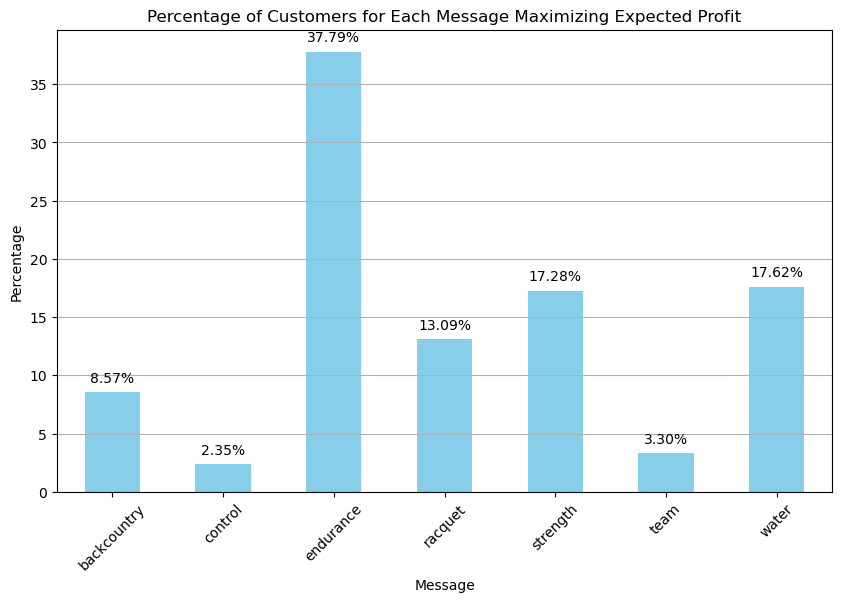

In [273]:
import matplotlib.pyplot as plt

# Plot the message_ep_percentages
ax = message_ep_percentages_xgb.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Percentage of Customers for Each Message Maximizing Expected Profit')
plt.xlabel('Message')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Add percentage values on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

This bar chart shows the distribution of customers assigned to each message type based on expected profit maximization.
Endurance dominates with 37.79%, making it the most profitable message for the largest customer segment. Water (17.62%) and Strength (17.28%) follow, suggesting they are also highly effective. Racquet (13.09%) and Backcountry (8.57%) cater to smaller but significant segments.

Team (3.30%) and Control (2.35%) have the lowest assignments, indicating that these messages yield the least expected profit. The control group’s low percentage suggests that almost all customers benefit from receiving some promotional message rather than none.

5. What  expected  profit  can  we  obtain,  on  average,  per  customer  if  we  customize  the 
message to each customer? Include no-message as an option as well.

In [274]:
# Calculate the average expected profit per customer
average_expected_profit_xgb = pentathlon_nptb_xgb_test['ep_max_xgb'].mean()
print(f"Average expected profit per customer: {average_expected_profit_xgb:.2f} Euros")

Average expected profit per customer: 0.70 Euros


6. What is the expected profit per e-mailed customer if every customer receives the same 
message?  Answer  this  question  for  each  of  the  possible  messages  (i.e.,  endurance, 
strength, water, team, backcountry, racquet) and the no-message option. Comment on 
the distribution of expected profit across messages and the no-message option

In [275]:
# Calculate the average expected profit for each message type
avg_ep_values_xgb = pentathlon_nptb_xgb_test[['ep_endurance_xgb', 'ep_strength_xgb', 'ep_water_xgb', 'ep_team_xgb', 'ep_backcountry_xgb', 'ep_racquet_xgb', 'ep_control_xgb']].mean()

# Create a table to compare the values
avg_ep_table_xgb = pd.DataFrame(avg_ep_values_xgb, columns=['Expected Profit'])
avg_ep_table_xgb.index = avg_ep_table_xgb.index.str.replace('ep_', '').str.replace('_xgb', '').str.capitalize()
avg_ep_table_xgb

Expected Profit
Endurance           0.602918
Strength            0.581438
Water               0.627376
Team                0.584759
Backcountry         0.568583
Racquet             0.582555
Control             0.446941

Water yields the highest expected profit (0.6274), making it the most profitable message when sent to all customers.
Endurance (0.6029) follows closely, indicating strong profitability but slightly lower than Water.
Racquet (0.5826), Strength (0.5814), and Team (0.5848) have comparable profit levels, suggesting they are viable but not optimal choices.
Backcountry (0.5689) is the least profitable message, showing it has limited effectiveness.
Control (0.4469) is the worst-performing option, reinforcing that sending any message is more profitable than sending none.

For maximizing profit, sending Water promotions is the best option, while avoiding Control (no message) is crucial.

7. What is the expected profit per e-mailed customer if every customer is assigned randomly 
to one of the messages or the no-message condition? 

In [276]:
message_counts_xgb = pentathlon_nptb_xgb_test[pentathlon_nptb_xgb_test.training == 0]['message'].value_counts()
print(message_counts_xgb)

message
racquet        26316
backcountry    26179
control        26043
team           25942
water          25496
strength       25251
endurance      24773
Name: count, dtype: int64


In [277]:
# profits based on message col

pentathlon_nptb_xgb_test['profits'] = pentathlon_nptb_xgb_test['total_os'] * 0.4
pentathlon_nptb_xgb_test

custid buyer  total_os female  income  education  children  \
0             U3    no         0      0   35000         22       1.0   
1            U25    no         0      1   65000         32       1.1   
2            U30    no         0      1   65000         62       0.5   
3            U55    no         0      0   35000         17       1.1   
4            U97    no         0      1   65000         40       0.7   
...          ...   ...       ...    ...     ...        ...       ...   
179995  U3462852    no         0      1   50000         19       1.1   
179996  U3462887    no         0      1   30000         14       0.9   
179997  U3462900    no         0      0   55000         32       0.9   
179998  U3462916    no         0      0   50000         35       0.6   
179999  U3462922    no         0      1   50000         25       0.7   

        freq_endurance  freq_strength  freq_water  ...  ep_endurance_xgb  \
0                    0              0           0  ...          0.047856   
1                    1              2           0  ...          0.235228   
2                    1              5           0  ...          1.414224   
3                    0              0           0  ...          0.035006   
4                    4              6           1  ...          0.292299   
...                ...            ...         ...  ...               ...   
179995               0              1           0  ...          0.095170   
179996               1              0           0  ...          0.065914   
179997               3              1           0  ...          0.080640   
179998               2              2           0  ...          0.077504   
179999               1              2           0  ...          0.208384   

        ep_strength_xgb  ep_water_xgb  ep_team_xgb  ep_backcountry_xgb  \
0              0.039860      0.038546     0.035993            0.035227   
1              0.166166      0.220704     0.218782            0.206652   
2              1.609164      1.535179     1.583761            1.482715   
3              0.018915      0.022446     0.020959            0.021468   
4              0.274783      0.348807     0.327340            0.312610   
...                 ...           ...          ...                 ...   
179995         0.102911      0.100057     0.095346            0.086427   
179996         0.034675      0.036130     0.035686            0.030734   
179997         0.077999      0.084795     0.086142            0.077236   
179998         0.080056      0.084940     0.088414            0.081548   
179999         0.248171      0.224316     0.242817            0.218580   

        ep_racquet_xgb  ep_control_xgb  msg_ep_xgb  ep_max_xgb  profits  
0             0.036497        0.028967   endurance    0.047856      0.0  
1             0.214105        0.157540   endurance    0.235228      0.0  
2             1.379270        1.124345    strength    1.609164      0.0  
3             0.021412        0.014363   endurance    0.035006      0.0  
4             0.316425        0.264712       water    0.348807      0.0  
...                ...             ...         ...         ...      ...  
179995        0.111335        0.067512     racquet    0.111335      0.0  
179996        0.045753        0.028536   endurance    0.065914      0.0  
179997        0.087718        0.064993     racquet    0.087718      0.0  
179998        0.090032        0.070867     racquet    0.090032      0.0  
179999        0.271399        0.194014     racquet    0.271399      0.0  

[180000 rows x 45 columns]

In [278]:
print("Average profit  per customer when a each customer is randomly assigned a message: ", pentathlon_nptb_xgb_test['profits'].mean(), 'Euros')


Average profit  per customer when a each customer is randomly assigned a message:  0.5518799999999999 Euros


8. For the typical promotional e-mail blast to 5,000,000 customers, what improvement (in 
percent and in total Euros) could Pentathlon achieve by customizing the message (or no-
message) to each customer. Compare the performance predictions from this personalized 
approach to scenarios where (1) each customer is sent the same message selected based 
on average performance, (2) a random message assignment approach is used (i.e., the 
status quo), and (3) no message is sent (i.e., the control condition)? 

In [279]:
avg_profits_msg_xgb = pentathlon_nptb_xgb_test[['ep_endurance_xgb', 'ep_strength_xgb', 'ep_water_xgb', 'ep_team_xgb', 'ep_backcountry_xgb', 'ep_racquet_xgb', 'ep_control_xgb']].mean()
avg_profits_msg_xgb

ep_endurance_xgb      0.602918
ep_strength_xgb       0.581438
ep_water_xgb          0.627376
ep_team_xgb           0.584759
ep_backcountry_xgb    0.568583
ep_racquet_xgb        0.582555
ep_control_xgb        0.446941
dtype: float32

In [280]:
n = 5_000_000
extrpolated_p_xgb = pentathlon_nptb_xgb_test['ep_max_xgb'].mean() * n #best scenario from targeting
extrpolated_p_xgb

3486245.572566986

In [281]:
#1
avg_profits_max_xgb = avg_profits_msg_xgb.max()
e_profits1_xgb = avg_profits_max_xgb * n


print("Extrapolated profits based on each customer if sent the same message selected based on average performance: ", e_profits1_xgb)
print("Improvement in profits (in Euros) if each customer is sent a personalized msg vs the same msg selected based on average performance: ",  extrpolated_p_xgb - e_profits1_xgb, "Euros")
print("Improvement in profits (in %) if each customer is sent a personalized msg vs the same msg selected based on average performance:  ",  (extrpolated_p_xgb - e_profits1_xgb) / e_profits1_xgb * 100, "%")

Extrapolated profits based on each customer if sent the same message selected based on average performance:  3136878.6096572876
Improvement in profits (in Euros) if each customer is sent a personalized msg vs the same msg selected based on average performance:  349366.9629096985 Euros
Improvement in profits (in %) if each customer is sent a personalized msg vs the same msg selected based on average performance:   11.13740779876298 %


In [282]:
#2
extrpolated_profit_random_xgb = pentathlon_nptb_xgb_test['profits'].mean() * n # profits extrapolated based on random assignment

print("Profit improvement (in %) by using the personalized message as compared to random messaging: ", (extrpolated_p_xgb - extrpolated_profit_random_xgb)/extrpolated_profit_random_xgb * 100, "%")
print("Profit improvement (in Euros) by using the personalized message as compared to random messaging: ", extrpolated_p_xgb - extrpolated_profit_random_xgb, "Euros")

Profit improvement (in %) by using the personalized message as compared to random messaging:  26.340710754765045 %
Profit improvement (in Euros) by using the personalized message as compared to random messaging:  726845.5725669865 Euros


In [283]:
#3
avg_e_profit_control_xgb = pentathlon_nptb_xgb_test['ep_control_xgb'].mean()
extrapolated_control_profit_xgb = avg_e_profit_control_xgb * n
print("Extrapolted profit by personalized message: ", extrpolated_p_xgb)
print("Extrapolated profits based on control message: ", extrapolated_control_profit_xgb)
print("Profit improvement (in Euros) by using the personalized message as compared to control message: ", extrpolated_p_xgb - extrapolated_control_profit_xgb, "Euros")
print("Profit improvement (in %) by using the personalized message as compared to control message: ", (extrpolated_p_xgb - extrapolated_control_profit_xgb) / extrapolated_control_profit_xgb * 100, "%")

Extrapolted profit by personalized message:  3486245.572566986
Extrapolated profits based on control message:  2234703.7494182587
Profit improvement (in Euros) by using the personalized message as compared to control message:  1251541.8231487274 Euros
Profit improvement (in %) by using the personalized message as compared to control message:  56.00482048121728 %


Overall Analysis:

Using the best message for each customer results in the highest profits, proving that personalization significantly increases revenue.
Compared to sending the same best message to all customers, personalization still boosts profits by 11.14%. Assigning one universally best-performing message is still much better than random assignment (+14%) or no messages (+40%). However, it underperforms compared to full personalization by 11.14%. Randomly assigning messages is better than sending no emails at all but significantly underperforms personalized or optimized messaging. Not sending emails results, of course, in the lowest revenue. This confirms that email marketing—when optimized—drives significant revenue gains.



## CONCLUSION

From comparing the 4 models in general, utilizing personalized messages is providing a better profit than same or random or no messages. Overall, XGBoost seems to be the best option to predict purchase probability as it has the best fit and the best AUC. The ordersize must be predicted utilizing historical average data, since all other models have provided poor R^2 on the train and test sets indicating that they are unable to explain the variablility in the data well. Lastly, XGBoost personalized messaging also delivers greater profit improvements compared to the other models.

## Campaign design recommendations going forward

### Proposal for an Optimized Promotional Email Allocation Strategy  

To enhance the effectiveness of our promotional email campaigns, we propose a data-driven allocation strategy that balances short-term profitability with long-term customer insights. Rather than limiting email selection to only the historically best-performing messages, this approach ensures continuous learning and adaptability by integrating controlled experimentation and uplift modeling.  

#### **Key Components of the Proposed Strategy:**  

1. **Dynamic Email Allocation**  
   - Each month, the analytics team determines the two message types that yield the highest expected profit for each customer.  
   - These top-performing messages will form the primary allocation strategy, but additional mechanisms will be introduced to avoid over-reliance on a narrow set of messages.  

2. **A/B Testing for Continuous Learning**  
   - A randomized subset of customers will receive message types beyond the two best-performing ones.  
   - This controlled experimentation allows us to assess whether other messages might drive engagement or conversions in ways that the current model does not capture.  
   - Results from these trials will inform future email allocations, ensuring a more comprehensive understanding of customer preferences over time.  

3. **Uplift Modeling to Measure True Impact**  
   - Instead of evaluating messages solely based on historical purchase correlations, we will leverage uplift modeling to assess their causal impact.  
   - The key metric will be the difference in probability between purchases made with and without receiving a given email (uplift): Probability(Purchase | Message) - Probability(Purchase | No Message) 
   - This approach accounts for external factors such as seasonality, self-selection bias, and pre-existing purchase intent, ensuring a more accurate measurement of email effectiveness.  

4. **Iterative Refinement and Optimization**  
   - Each month, insights from randomized trials and uplift modeling will be used to refine the email allocation process.  
   - The strategy will dynamically adjust to changes in customer behavior, preventing message fatigue and improving long-term engagement.  

By implementing this approach, we ensure that our promotional email campaigns remain not only profitable but also adaptable and data-driven, leading to sustained customer engagement and revenue growth.